# Imports & Functions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# read in our dataframe
df = pd.read_spss('../data/CCAM SPSS Data 2008-2018.sav')

#resave dataframe
# this removes some weirdness with the .sav file structure that doesn't 
# let rows be completely removed
df.to_csv('../data/CCAM SPSS Data 2008-2018.csv', index=False)

# read in our new dataframe
df = pd.read_csv('../data/CCAM SPSS Data 2008-2018.csv')

In [3]:
# geo = pd.read_csv('../data/YCOM6.0_2021_Data_.csv', encoding='latin-1')

In [4]:
def columns_info(df):
    columns_df = pd.DataFrame({'nulls': [df[col].isna().sum() for col in df.keys()], 
                         'dtype': [df[col].dtype for col in df.keys()], 
                         'nunique_values': [df[col].nunique() for col in df.keys()], 
                         'unique_values': [df[col].unique()for col in df.keys()], 
                         'value_counts': [df[col].value_counts() for col in df.keys()]}, 
                         index=[col for col in df.keys()])
    return columns_df

In [5]:
def distgraph(var,title):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.barh(df[var].value_counts(normalize=True).index,
              width = df[var].value_counts(normalize=True))

    # label each bar
    ax.bar_label(ax.containers[0],
                    fmt="%.3f",
                   padding = 3)

    # fluff
    ax.set_xlabel('% of Responses')
    ax.set_title(title+'\n\nDistribution',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left');

def propgraph(var,var_order,title):
    fig, ax = plt.subplots()

    df.groupby(var)['happening'].value_counts(normalize=True)\
        .unstack().loc[var_order].T\
        .loc[['No', "Don't know", 'Yes']].T\
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'deepskyblue', 'palegreen'], 
              ax=ax)
    ax.set_title(title+'\n\nProportion of Belief in Climate Change',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(None)
    ax.legend(loc=(1.05,0.88));

# Initial Inspection 

## Review Target Column
**Recently, you may have noticed that global warming has been getting some attention in the news. Global warming refers to the idea that the world’s average temperature has been increasing over the past 150 years, may be increasing more in the future, and that the world’s climate may change as a result. What do you think: Do you think that global warming is happening?**

In [6]:
df.happening.value_counts(normalize=True)

Yes           0.665373
Don't know    0.170325
No            0.161135
Refused       0.003167
Name: happening, dtype: float64

The target for our dataset will be the question on whether or not the respondent thinks global warming is happening.

There are four options for the answer, one of which is "Refused". For the purposes of this analysis, and because it is 0.3% of the responses, these survey rows will be dropped leaving us with only three possible responses:
  1.  Yes
  2.  Don't Know
  3.  No

In [7]:
# drop Refused
df = df[df.happening != "Refused"]

## Review Exploratory Variables

In [8]:
df.shape

(22345, 54)

The dataset contains 53 exploratory variables and 1 target variable across 22,345 rows, each indicating a survey response.

Below is a quick summary of the variables, nulls, types of values, etc. in the dataset

In [9]:
columns_info(df)

nulls    dtype  nunique_values  \
case_ID                          0  float64           22345   
wave                             0   object              19   
year                             0    int64              10   
weight_wave                      0  float64            8225   
weight_aggregate                 0  float64           11637   
happening                        0   object               3   
cause_original                   0   object               5   
cause_other_text             20358   object            1389   
cause_recoded                    0   object               7   
sci_consensus                 1330   object               5   
worry                            0   object               5   
harm_personally                  0   object               6   
harm_US                          0   object               6   
harm_dev_countries               0   object               6   
harm_future_gen                  0   object               6   
harm_plants_animals           1330   object               6   
when_harm_US                     0   object               7   
reg_CO2_pollutant              998   object               5   
reg_utilities                 5026   object               5   
fund_research                    0   object               5   
reg_coal_emissions            9034   object               5   
discuss_GW                       0   object               5   
hear_GW_media                13587   object               7   
gender                           0   object               2   
age                              0  float64              78   
age_category                     0   object               3   
generation                       0   object               6   
educ                             0   object              14   
educ_category                    0   object               4   
income                           0   object              21   
income_category                  0   object               3   
race                             0   object               4   
ideology                         0   object               6   
party                            0   object               6   
party_w_leaners                  0   object               5   
party_x_ideo                     0   object               7   
registered_voter                 0   object               6   
region9                          0   object               9   
region4                          0   object               4   
religion                         0   object              16   
religion_other_nonchristian  22253   object              65   
evangelical                      0   object               4   
service_attendance               0   object               7   
marit_status                     0   object               6   
employment                       0   object               7   
house_head                       0   object               2   
house_size                       0  float64              13   
house_ages0to1                   0  float64               7   
house_ages2to5                   0  float64               5   
house_ages6to12                  0  float64               7   
house_ages13to17                 0  float64               5   
house_ages18plus                 0  float64              11   
house_type                       0   object               5   
house_own                        0   object               3   

                                                                 unique_values  \
case_ID                      [2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0...   
wave                         [Nov 2008, Jan 2010, Jun 2010, May 2011, Nov 2...   
year                         [2008, 2010, 2011, 2012, 2013, 2014, 2015, 201...   
weight_wave                  [0.5400000000000001, 0.85, 0.49, 0.29, 1.29, 2...   
weight_aggregate             [0.2944021792003114, 0.4634108376301197, 0.267...   
happening                                                [Yes, Don't kn

---
---

# Eploratory Data Analysis

### Patterns of Missingness

#### Questions with "Refused" possible answers

happening
cause_original
cause_recoded
sci_consensus
worry
harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals
when_harm_US
reg_CO2_pollutant
reg_utilities
fund_research
reg_coal_emissions
discuss_GW
hear_GW_media
ideology
party
party_w_leaners
party_x_ideo
registered_voter
religion
evangelical
service_attendance

In [10]:
# create binary df where refused is 1 and everything else is 0
refused_df = df.applymap(lambda x: 1 if x == 'Refused' else 0)

pd.concat(
    # keep columns with a sum > 0 (at least 1 refused)
    [pd.Series(refused_df.loc[:,refused_df.sum()>0].sum(),
              name = '# of Refused'),
     
    # divide # of refusals by total rows
    pd.Series(refused_df.loc[:,refused_df.sum()>0].sum()/
              refused_df.loc[:,refused_df.sum()>0].shape[0],
              name = '% of Refused')],
    axis = 1)

# of Refused  % of Refused
cause_original                 50      0.002238
cause_recoded                  50      0.002238
sci_consensus                  45      0.002014
worry                          42      0.001880
harm_personally                60      0.002685
harm_US                        82      0.003670
harm_dev_countries             92      0.004117
harm_future_gen                85      0.003804
harm_plants_animals            91      0.004072
when_harm_US                  166      0.007429
reg_CO2_pollutant             504      0.022555
reg_utilities                 442      0.019781
fund_research                 500      0.022376
reg_coal_emissions            142      0.006355
discuss_GW                     37      0.001656
hear_GW_media                  63      0.002819
ideology                      420      0.018796
party                         205      0.009174
party_w_leaners               205      0.009174
party_x_ideo                  308      0.013784
registered_voter              182      0.008145
religion                      276      0.012352
evangelical                   267      0.011949
service_attendance            292      0.013068

In [11]:
# pattern = refused_df[~refused_df.duplicated()].applymap(lambda x: int(x))

# lister = [] # count up appearance of each pattern

# for i in range(len(pattern)):
#     counter = 0

#     for j in refused_df.values:
#         if np.array_equal(j, pattern.values[i]):
#             counter += 1 
#     lister.append(counter)

# pattern.reset_index(drop=True, 
#                     inplace = True) # reset index

# # num of missing values per pattern
# pattern['num_per_row'] = pattern.sum(axis=1).values

# pattern['count'] = lister # number of times a pattern appears in dataset

# pattern.sort_values('num_per_row', ascending=False) # sort values

In [12]:
refused_df['num_per_row'] = refused_df.sum(axis=1).values

In [13]:
refused_df.num_per_row.value_counts().sort_index()

0     20532
1       996
2       233
3       249
4       111
5        45
6        24
7        40
8        36
9        12
10       13
11       16
12       12
13        3
14        4
15        1
16        2
17        4
18        1
19        1
20        4
21        2
22        3
23        1
Name: num_per_row, dtype: int64

In [14]:
print(refused_df.shape, '\n')

print('Questions answered "Refused":')

print('80% or more "Refused"',  - round(24 * .20), 'Questions - ',
      refused_df[refused_df.num_per_row >= 5]['happening'].count(), 'people -', 
      round((refused_df[refused_df.num_per_row >= 5]['happening'].count() / df.shape[0]) * 100, 2), 
      '% of dataset'
     )

print('75% or more "Refused"',  - round(24 * .25), 'Questions - ',
      refused_df[refused_df.num_per_row >= 6]['happening'].count(), 'people -', 
      round((refused_df[refused_df.num_per_row >= 6]['happening'].count() / df.shape[0]) * 100, 2), 
      '% of dataset'
     )

print('50% or more "Refused"', -round(24 * .50), 'Questions - ',
      refused_df[refused_df.num_per_row >= 12]['happening'].count(), 'people -', 
      round((refused_df[refused_df.num_per_row >= 12]['happening'].count() / df.shape[0]) * 100, 2), 
      '% of dataset'
     )

(22345, 55) 

Questions answered "Refused":
80% or more "Refused" -5 Questions -  224 people - 1.0 % of dataset
75% or more "Refused" -6 Questions -  179 people - 0.8 % of dataset
50% or more "Refused" -12 Questions -  38 people - 0.17 % of dataset


In [15]:
df.drop(index=refused_df[refused_df.num_per_row >= 5]['happening'].index, inplace=True)
df.reset_index(drop=True, inplace=True)

#### Null Responses

The survey was carried out in a series of waves across the years. Some questions were not included in every single wave of survey questioning which led to there being nulls in the dataset.

In [16]:
pd.concat(
    [pd.Series(df.loc[:,(df.isnull()).any()].isnull().sum(),
              name = '# of nulls'),
    pd.Series(df.loc[:,(df.isnull()).any()].isnull().sum()/
              df.loc[:,(df.isnull()).any()].shape[0],
              name = '% of nulls')],
    axis = 1)

# of nulls  % of nulls
cause_other_text                  20146    0.910718
sci_consensus                      1324    0.059853
harm_plants_animals                1324    0.059853
reg_CO2_pollutant                   984    0.044483
reg_utilities                      5002    0.226120
reg_coal_emissions                 8910    0.402785
hear_GW_media                     13419    0.606618
religion_other_nonchristian       22030    0.995886

In [17]:
# pattern_null = df.isnull()[~df.isnull().duplicated()].applymap(lambda x: int(x))

# lister = [] # count up appearance of each pattern

# for i in range(len(pattern_null)):
#     counter = 0

#     for j in df.isnull().values:
#         if np.array_equal(j, pattern_null.values[i]):
#             counter += 1 
#     lister.append(counter)

# pattern_null.reset_index(drop=True, 
#                     inplace = True) # reset index

# # num of missing values per pattern
# pattern_null['num_per_row'] = pattern_null.sum(axis=1).values

# pattern_null['count'] = lister # number of times a pattern appears in dataset

# pattern_null.sort_values('num_per_row', ascending=False) # sort values

In [18]:
null_counts = df.isnull().applymap(lambda x: int(x))

null_counts['num_per_row'] = null_counts.sum(axis=1).values

null_counts[null_counts.num_per_row >= 20]['happening'].count()

0

In [19]:
null_counts.num_per_row.value_counts().sort_index()

0       7
1     465
2    4876
3    6242
4    8459
5    2072
Name: num_per_row, dtype: int64

#### Impute Refused as Null

In [20]:
# finally impute these as null
df = df.applymap(lambda x: np.nan if x == 'Refused' else x)

### Review Variables

#### `happening` (target)

In [21]:
df.happening.value_counts(normalize=True).to_frame()

happening
Yes          0.670042
Don't know   0.168211
No           0.161747

A majority of our dataset (66.7%) thinks global warming is happening with Don't Know and No being neck and neck for the second most popular answer.

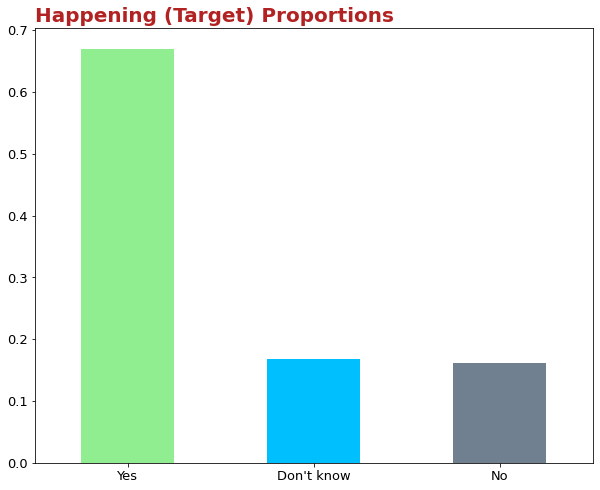

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

df.happening.value_counts(normalize=True).plot(kind='bar', 
                                               fontsize=13, 
                                               color=['lightgreen', 
                                                      'deepskyblue', 
                                                      'slategrey'])

ax.set_title('happening Proportions', 
                fontsize=15, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')

plt.xticks(rotation = 0)

ax.set_title('Happening (Target) Proportions', 
                fontsize=20, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')
plt.tight_layout;

#### `Case_ID`

`CASE_ID` is the individual identifier of the survey respondent and will have no value for our model. Drop it.

In [23]:
df.drop('case_ID', axis=1, inplace=True)

#### `Wave`

In [24]:
# reorder wave to be YYYY MMM instead of MMM YYYY
df.wave = [' '.join(wave.split(' ')[::-1]) for wave in df.wave]

In [25]:
df.wave.value_counts().sort_index().to_frame()

wave
2008 Nov  2132
2010 Jan   970
2010 Jun  1018
2011 May   984
2011 Nov   960
2012 Mar   984
2012 Sep  1049
2013 Apr  1023
2013 Nov   813
2014 Apr   998
2014 Oct  1264
2015 Mar  1254
2015 Oct  1324
2016 Mar  1194
2016 Nov  1224
2017 May  1260
2017 Oct  1298
2018 Dec  1110
2018 Mar  1262

In [26]:
df.wave.value_counts().sort_index()[1:].values.mean()

1110.5

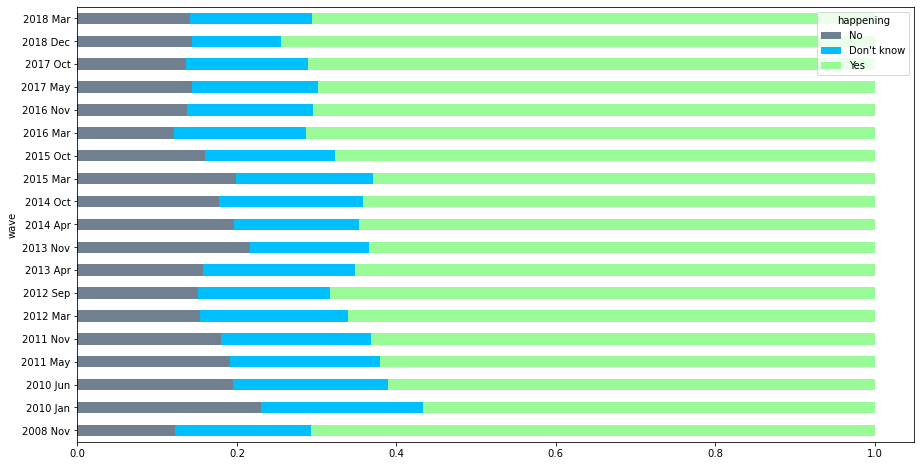

In [27]:
df.groupby('wave')['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
    .plot(kind='barh',
          figsize=(15, 8), 
          stacked=True,
          color=['slategrey', 'deepskyblue', 'palegreen']);

**Wave**

Observation
- The first poll had the largest number of responses. 
- Each poll afterwards had 1125 responses on average. 
- It seems like the number of people in each poll was divided in half after the first year. 

#### `Year`

**Proportion of Belief in Climate Change over 2008 - 2018**

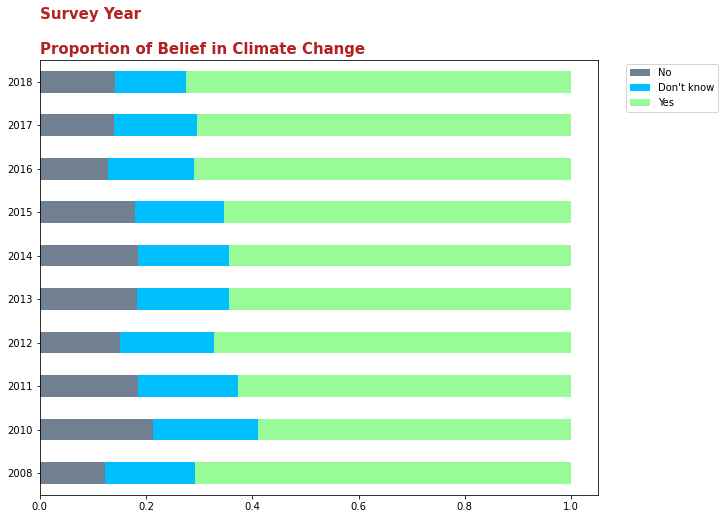

In [28]:
propgraph('year',
          df.year.unique(),
          'Survey Year')

In [29]:
df.year.value_counts().to_frame()

year
2015  2578
2017  2558
2016  2418
2018  2372
2014  2262
2008  2132
2012  2033
2010  1988
2011  1944
2013  1836

In [30]:
df.groupby('year')['happening'].value_counts(normalize=True).to_frame().unstack()

happening                    
happening Don't know        No       Yes
year                                    
2008        0.170732  0.122420  0.706848
2010        0.199195  0.212274  0.588531
2011        0.187757  0.185700  0.626543
2012        0.175603  0.151992  0.672405
2013        0.172113  0.183551  0.644336
2014        0.170203  0.185676  0.644120
2015        0.167184  0.178821  0.653995
2016        0.162117  0.129032  0.708850
2017        0.155199  0.139953  0.704848
2018        0.134064  0.142074  0.723862

#### `Weight Wave`

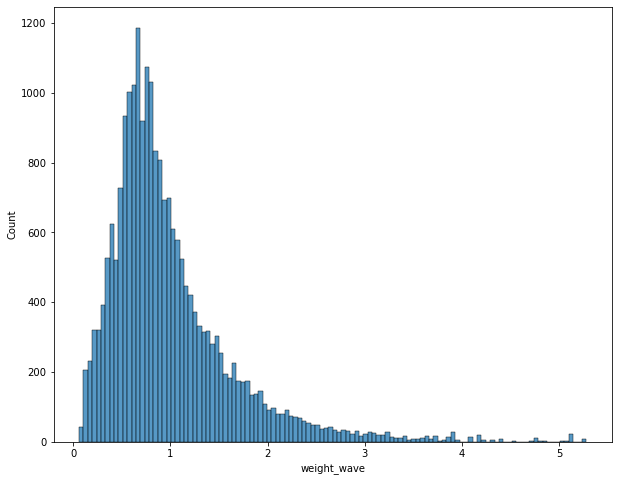

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df, x='weight_wave', ax=ax);

In [32]:
df.weight_wave.describe()

count    22121.000000
mean         0.997421
std          0.656767
min          0.060000
25%          0.586600
50%          0.824200
75%          1.220000
max          5.280000
Name: weight_wave, dtype: float64

In [33]:
df.groupby('year')['weight_wave'].value_counts().to_frame()

weight_wave
year weight_wave             
2008 0.5500                30
     0.5400                29
     0.5800                29
     0.1400                27
     0.5700                27
...                       ...
2018 3.2767                 1
     3.2917                 1
     3.4013                 1
     3.6874                 1
     3.7050                 1

[10985 rows x 1 columns]

**weight_wave**

Observation
- Not sure how they calculated the sampling weight for different waves of polling 
- I don't see how this feature would be useful in modeling or analyzing relationships between features and target

#### `Cause Original`
Assuming global warming is happening do you think it is...

In [34]:
x = df.groupby('happening')['cause_original'].value_counts().to_frame().unstack().T
x['num_per_row'] = x.sum(axis=1).values
x

happening                                                          Don't know  \
               cause_original                                                   
cause_original Caused mostly by human activities                         1095   
               Caused mostly by natural changes in the environ...        1849   
               None of the above because global warming isn't ...         340   
               Other (Please specify)                                     427   

happening                                                            No  \
               cause_original                                             
cause_original Caused mostly by human activities                    340   
               Caused mostly by natural changes in the environ...  1846   
               None of the above because global warming isn't ...  1086   
               Other (Please specify)                               302   

happening                                                            Yes  \
               cause_original                                              
cause_original Caused mostly by human activities                   10004   
               Caused mostly by natural changes in the environ...   3402   
               None of the above because global warming isn't ...     30   
               Other (Please specify)                               1376   

happening                                                          num_per_row  
               cause_original                                                   
cause_original Caused mostly by human activities                         11439  
               Caused mostly by natural changes in the environ...         7097  
               None of the above because global warming isn't ...         1456  
               Other (Please specify)                                     2105

''

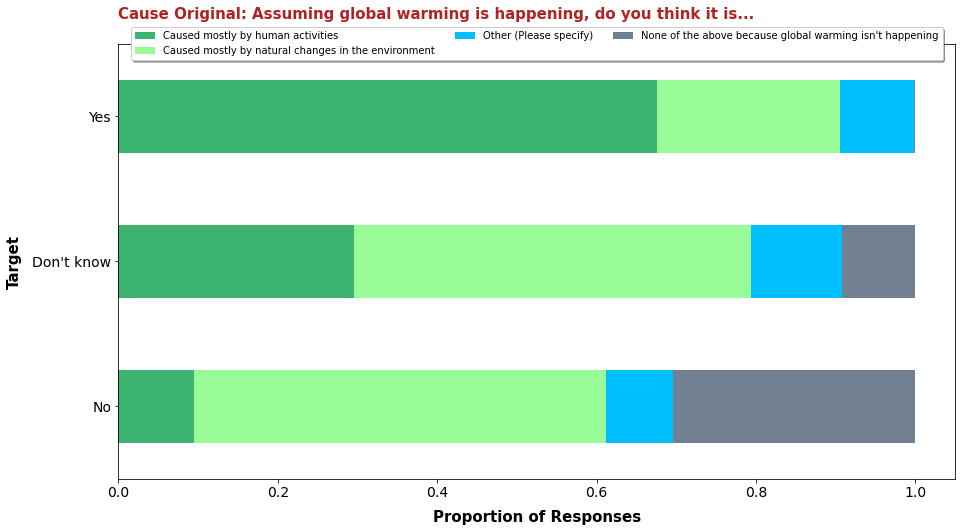

In [35]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_original'].value_counts(normalize=True)\
.unstack().loc[['No', "Don't know", 'Yes']].T\
          .loc[['Caused mostly by human activities',
               'Caused mostly by natural changes in the environment',
               'Other (Please specify)',
               "None of the above because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            fontsize=14,
                                            color=['mediumseagreen', 
                                                   'palegreen',
                                                   'deepskyblue', 
                                                   'slategrey',
                                                   'black'], 
                                           label=('1', '2'))
ax.set_title('Cause Original: Assuming global warming is happening, do you think it is...', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Proportion of Responses', weight='bold', fontsize=15, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Original**

Observation 
- 95 people refused to answer this question 
- For each `happening` subgroup, some people "None of the above because global warming isn't happening." 30 people who said "Yes" to `happening` selected this response for this question 
- For the 'No' subgroup of `happening`, 2,960 people selected either of the two choices that state what the cause of global warming is. This is a contradiction. 
- Drop "Refused" when ordinal encoding feature
    1. "None of the above because global warming isn't happening"
    2. "Other (Please specify)"
    3. "Caused mostly by natural changes in the environment"
    4. "Caused mostly by human activities"

In [36]:
df.drop(columns=['cause_original'], axis=1, inplace=True)

#### `Cause Other Text`

[Other - Specify] Assuming global warming is happening, do you think it is...

- This feature had empty strings that I converted to np.nan
- Were these questions only answered if cause_original responses was "Other"

In [37]:
# Number of "Other (Please specify)" in cause_original
# df[df.cause_original == 'Other (Please specify)']['cause_original'].count()

In [38]:
# People who answer 'other' in 1st question, but didn't specify here as directed
# df.cause_other_text.fillna('', inplace=True)

# df[(df.cause_original == 'Other (Please specify)') & 
#    (df.cause_other_text == '')]['cause_other_text'].count()

In [39]:
# Responses to cause_original for people who didn't answer this question 
# df[df.cause_other_text == '']['cause_original'].value_counts().to_frame()

In [40]:
df.cause_other_text.value_counts(dropna=False)

NaN                                                        20146
both                                                         115
Both                                                          60
both of the above                                             29
combination of both                                           23
                                                           ...  
combo of natural and human                                     1
I'm not sure                                                   1
natural changes somewhat influenced by human activities        1
caused by both human and enviroment                            1
it is caused by both                                           1
Name: cause_other_text, Length: 1386, dtype: int64

In [41]:
# How many people did answer this question 
df[df.cause_other_text != '']['happening'].count()

22121

In [42]:
df.cause_other_text.nunique()

1385

**Cause Other Text**

- there are a 2126 unique answers. Many of them mean the same thing and could be grouped. It could be interesting to investigate further and get more ideas about the data.  
    - lots of people said it was both, meaning both human activity and natural causes 
    - lots of people reference God
    - lot of people said they don't know 
- 1991 people responded to this question
- 135 people who answered "Other" for `cause_original` did not specify here as instructed
- Because only 9% of people answered this question, and it overlaps with `cause_original`, this feature is unlikely to be useful

In [43]:
df.drop(columns=['cause_other_text'], axis=1, inplace=True)

#### `Cause Recorded`

Assuming global warming is happening, do you think it is... (Recoded to include open-ends)

- it seems this feature was created from combining both `cause_original` and `cause_original_text`

In [44]:
# df.cause_recoded.value_counts().to_frame()

x = df.groupby('happening')['cause_recoded'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)
x.astype(dtype=int, errors='ignore')

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_31466/2947318618.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening                                      cause_recoded  Don't know  \
0                                                          0          10   
1             Caused by human activities and natural changes         226   
2                          Caused mostly by human activities        1103   
3          Caused mostly by natural changes in the enviro...        1906   
4                                                 Don't know          69   
5             Neither because global warming isn't happening         343   
6                                     Other (Please specify)          64   
(sum)                                                      0        3721   

happening    No    Yes  (sum)  
0             4     10     24  
1            46   1090   1362  
2           345  10078  11526  
3          1990   3479   7375  
4             5     44    118  
5          1099     30   1472  
6            89     91    244  
(sum)      3578  14822  22121

''

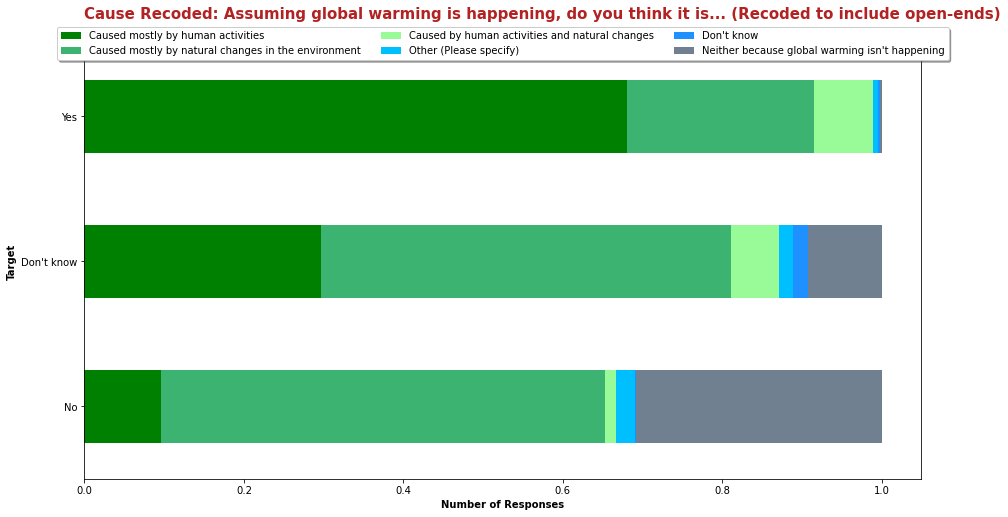

In [45]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_recoded'].value_counts(normalize=True).unstack()\
.loc[['No', "Don't know", 'Yes']].T\
.loc[['Caused mostly by human activities', 
      'Caused mostly by natural changes in the environment', 
      'Caused by human activities and natural changes', 
      'Other (Please specify)', 
      "Don't know", 
      "Neither because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True, 
                                            color=['g', 
                                                   'mediumseagreen', 
                                                   'palegreen', 
                                                   'deepskyblue',
                                                   'dodgerblue', 
                                                   'slategrey'], 
                                           label=('1', '2'))
ax.set_title('Cause Recoded: Assuming global warming is happening, do you think it is... (Recoded to include open-ends)', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold')
ax.set_xlabel('Number of Responses', weight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Recoded**

Observation 
- "Don't Know" and "Caused by human activities and natural changes" were added. 
- "Refused" had no change between `cause_original` and `cause_original_text`
- Differences in answers from `cause_original` = "Other (Please specify) and `cause_recoded`
    - 17 people answered "Neither because global warming isn't happening" here
    - 1647 people answered either the 1st 2 questions meaning they believe in Global Warming 
    - 252 people still responded "Other (Please specify)" 

In [46]:
my_dict = {'Caused mostly by human activities': 'Yes',
           'Caused mostly by natural changes in the environment': 'Yes',
           'Caused by human activities and natural changes': 'Yes',
           'Other (Please specify)': "Don't know",
           "Don't know": "Don't know",
           "Neither because global warming isn't happening": 'No'}

df.cause_recoded = df.cause_recoded.replace({i:j for i,j in my_dict.items()})

#### `SCI Concensus `

Scientist Consensus: Which comes closest to your own view?
- Not asked in Oct 2015

In [47]:
# Number of Nulls in sci_consensus from "2016 Oct"
df.sci_consensus.isnull().sum()

1350

In [48]:
x = df.groupby('happening')['sci_consensus'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_31466/2592813390.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening                                      sci_consensus  Don't know  \
0                                                          0         222   
1                                   Don't know enough to say        1429   
2          Most scientists think global warming is happening         433   
3          Most scientists think global warming is not ha...          56   
4          There is a lot of disagreement among scientist...        1581   
(sum)                                                      0        3721   

happening    No    Yes  (sum)  
0           217    911   1350  
1           386   1686   3501  
2           230   8678   9341  
3           512    133    701  
4          2233   3414   7228  
(sum)      3578  14822  22121

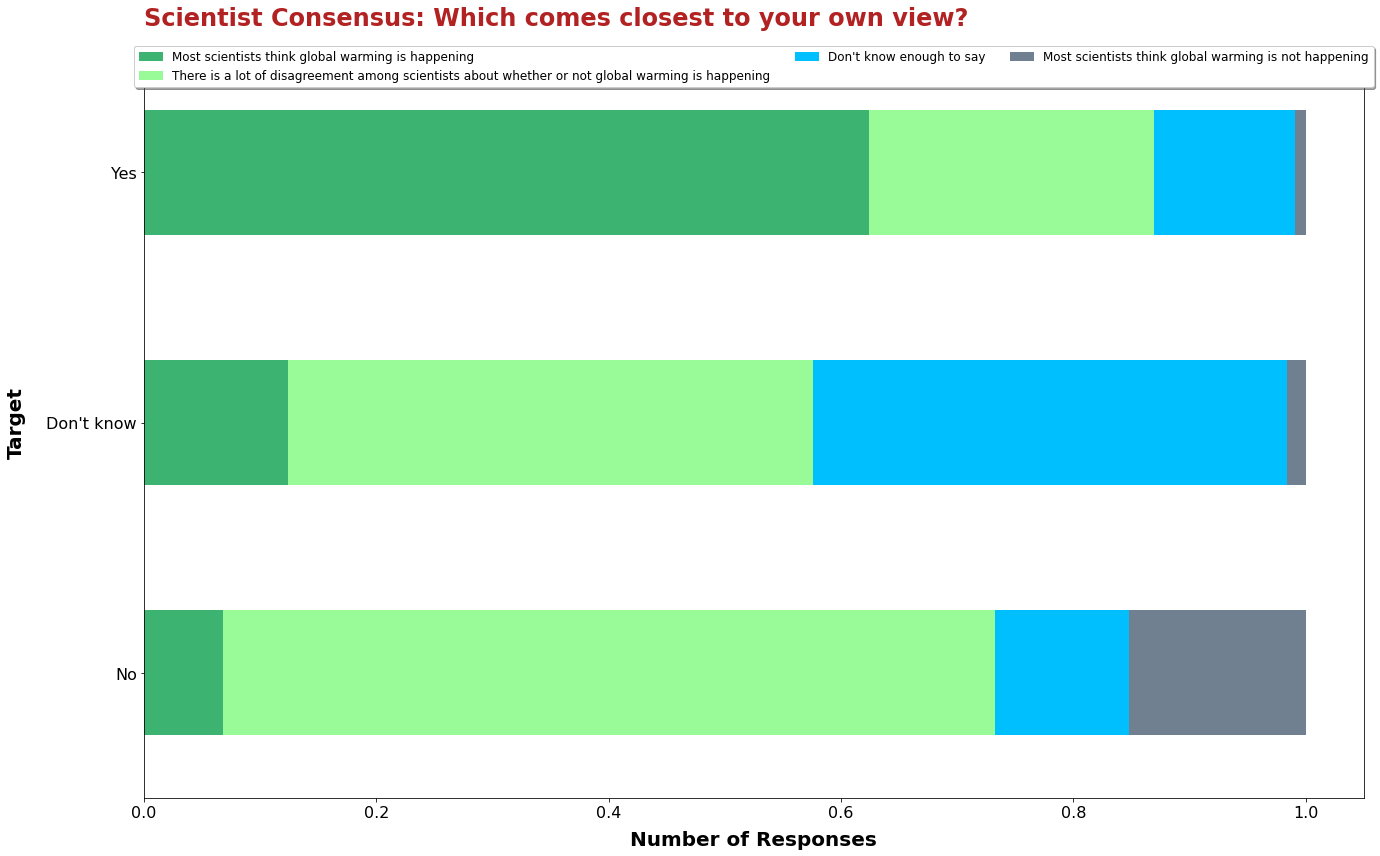

In [49]:
fig, ax = plt.subplots(figsize=(20, 12))

df.groupby('happening')['sci_consensus'].value_counts(normalize=True).unstack().loc[['No', "Don't know", 'Yes']].T\
.loc[['Most scientists think global warming is happening', 
      'There is a lot of disagreement among scientists about whether or not global warming is happening',
      "Don't know enough to say", 
      'Most scientists think global warming is not happening']].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            color=['mediumseagreen', 
                                                   'palegreen', 
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'slategrey'], 
                                           label=('1', '2'), 
                                           fontsize=16)
ax.set_title('Scientist Consensus: Which comes closest to your own view?', 
             fontsize=24, fontweight='bold', color='firebrick', loc='left', pad=22)
ax.set_ylabel('Target', weight='bold', fontsize=20, labelpad=20)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=20, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [50]:
df.groupby('happening')['sci_consensus'].value_counts().to_frame().unstack().T

happening                                                         Don't know  \
              sci_consensus                                                    
sci_consensus Don't know enough to say                                  1429   
              Most scientists think global warming is happening          433   
              Most scientists think global warming is not hap...          56   
              There is a lot of disagreement among scientists...        1581   

happening                                                           No   Yes  
              sci_consensus                                                   
sci_consensus Don't know enough to say                             386  1686  
              Most scientists think global warming is happening    230  8678  
              Most scientists think global warming is not hap...   512   133  
              There is a lot of disagreement among scientists...  2233  3414

**Science Consensus**

Observation 
- 90 people Refused to answer this question 
- This question is the least likely to leak data into the model
- 1330 Nulls for this feature from 2015 Oct
    - possible to impute with KNNImputer

In [51]:
my_dict = {'Most scientists think global warming is happening': 'Yes',
           'There is a lot of disagreement among scientists about whether or not global warming is happening': 'Maybe',
           "Don't know enough to say": "Don't know",
           'Most scientists think global warming is not happening': 'No'}

df.sci_consensus = df.sci_consensus.replace({i:j for i,j in my_dict.items()})

#### `Worry`

How worried are you about global warming?

In [52]:
x = df.groupby('happening')['worry'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_31466/2187703950.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening               worry  Don't know    No    Yes  (sum)
0                           0           6     4     12     22
1          Not at all worried         818  2188    783   3789
2            Not very worried        1812  1211   2914   5937
3            Somewhat worried        1029   160   7773   8962
4                Very worried          56    15   3340   3411
(sum)                       0        3721  3578  14822  22121

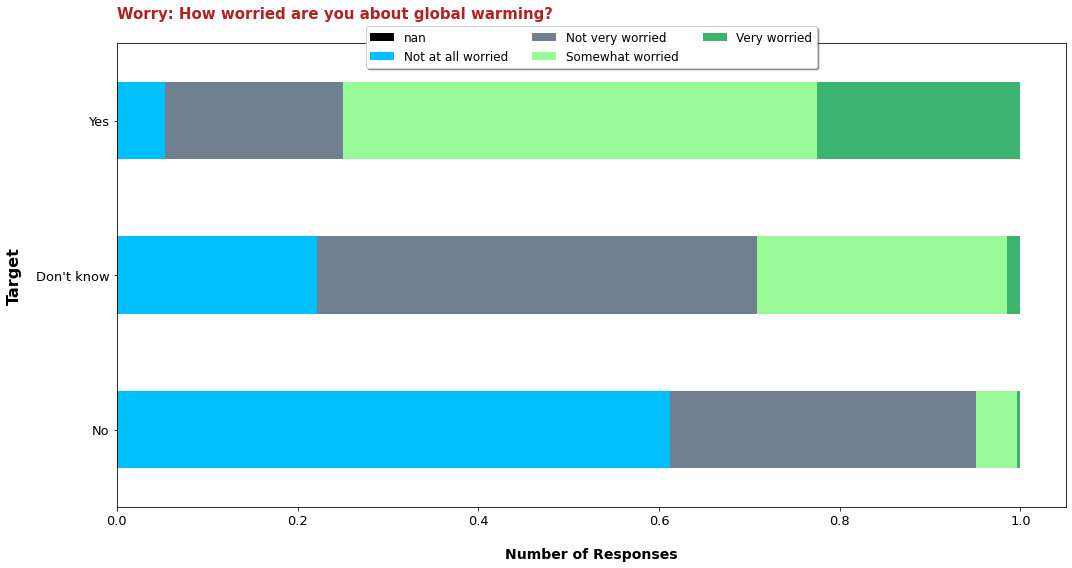

In [53]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['worry'].value_counts(dropna=False, normalize=True).unstack().loc[['No', "Don't know", 'Yes']] \
                                      .plot(kind='barh', 
                                            ax=ax,
                                            stacked=True,
                                            color=['black',
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'palegreen', 
                                                   'mediumseagreen',
                                                   'g'], 
                                           label=('1', '2'), 
                                           fontsize=13)
ax.set_title('Worry: How worried are you about global warming?', 
             fontsize=15, fontweight='bold', color='firebrick', loc='left', pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=16, labelpad=14)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=14, labelpad=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

**Worry**

Observation 
- 83 people Refused 
- For `happening` = "Not Yes"
    - 68 Refused
    - 3056 Not at all worried 
    - 19292 expressed some level of worry
- This feature might be misleading for predicting the target
- This feature could be reduced to binary (worry_True, worry_False) for OHE
- Could also reduce to 3 subgroups (not_worried, worried, very_worried)

In [245]:
df['worry'] = [0 if x == 'No' else x if pd.isnull(0) else 1 for x in df.worry]

#### Harm Series of Questions
The following five risk perception questions were asked together as a set
- harm_personally
- harm_US
- harm_dev_coutnries
- harm_future_gen
- harm_plants_animals

#### `Harm Personally`
How much do you think global warming will harm: You personally

In [56]:
x = df.groupby('happening')['harm_personally'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_31466/2848853250.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening    harm_personally  Don't know    No    Yes  (sum)
0                          0           4     4     11     19
1               A great deal         130    32   2381   2543
2          A moderate amount         588   177   4775   5540
3                 Don't know        1041   250   1168   2459
4                 Not at all        1034  2603   1933   5570
5              Only a little         924   512   4554   5990
(sum)                      0        3721  3578  14822  22121

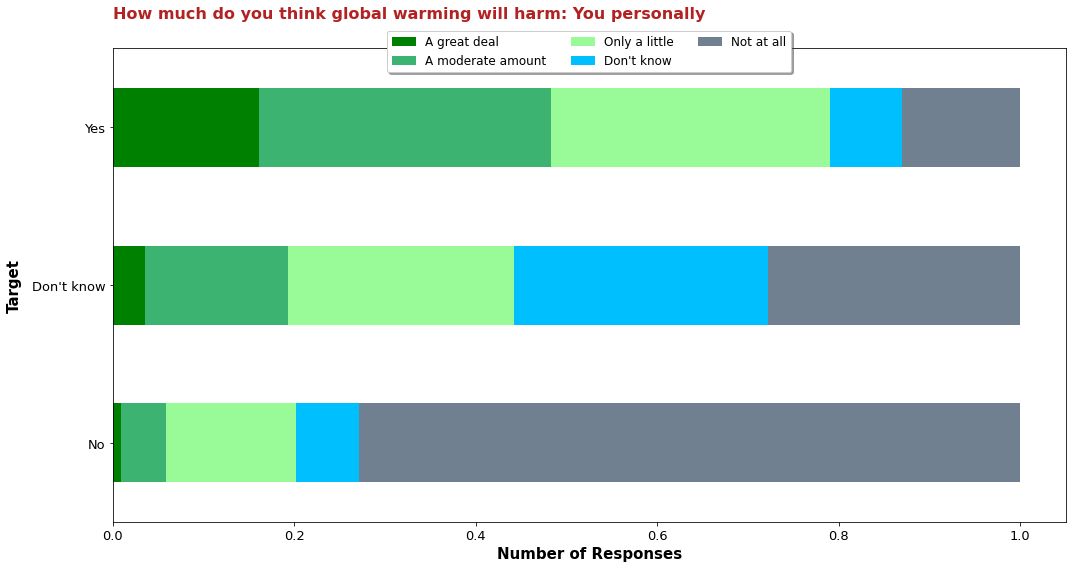

In [57]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_personally'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True,
                              fontsize=13, 
                            color=['g', 
                                   'mediumseagreen', 
                                   'palegreen',
                                   'deepskyblue',
                                   'slategrey',
                                   'black'],
                           label=('1', '2'))
ax.set_title('How much do you think global warming will harm: You personally', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=30)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [58]:
df.groupby('happening')['harm_personally'].value_counts().to_frame().unstack().T

happening                          Don't know    No   Yes
                harm_personally                          
harm_personally A great deal              130    32  2381
                A moderate amount         588   177  4775
                Don't know               1041   250  1168
                Not at all               1034  2603  1933
                Only a little             924   512  4554

**Harm Personally**

Observation 
- 103 people "Refused"
- This will be a good predictor 

In [59]:
my_dict = {'A great deal': 'Yes',
           'Only a little': 'Yes',
           'Not at all': 'No',
           'Don\'t know': 'Don\'t know',
           'A moderate amount': 'Yes',
           'Refused': 'Refused'}

df.harm_personally = df.harm_personally.replace({i:j for i,j in my_dict.items()})

#### `Harm US`
How much do you think global warming will harm: People in the United States

In [60]:
x = df.groupby('happening')['harm_US'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_31466/404011177.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening            harm_US  Don't know    No    Yes  (sum)
0                          0           6     8     25     39
1               A great deal         240    57   4746   5043
2          A moderate amount         838   286   5561   6685
3                 Don't know        1098   303   1067   2468
4                 Not at all         604  2255    749   3608
5              Only a little         935   669   2674   4278
(sum)                      0        3721  3578  14822  22121

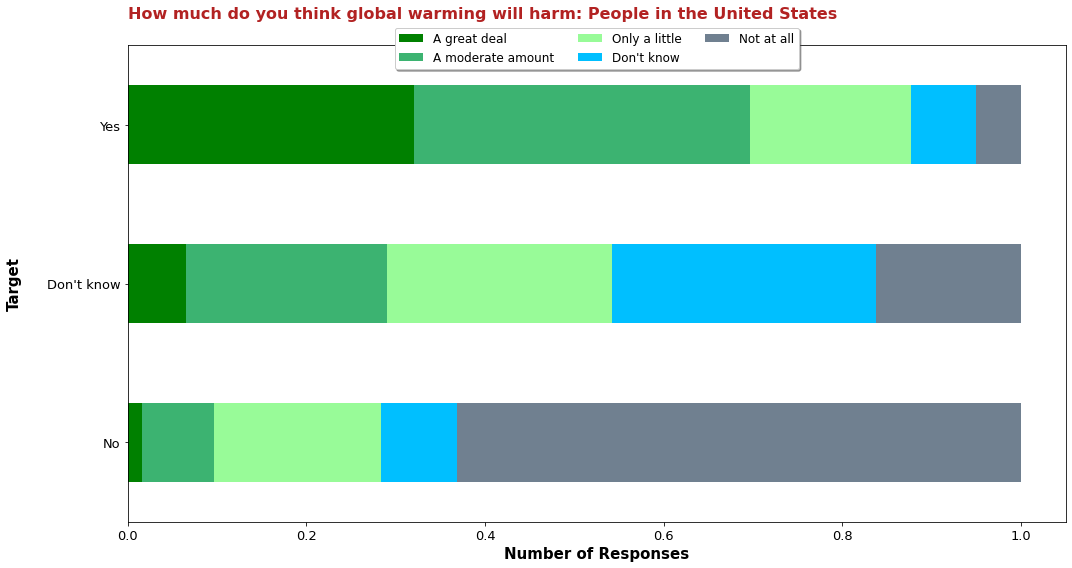

In [61]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_US'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True, 
                              fontsize=13,
                              color=['g', 
                                     'mediumseagreen', 
                                     'palegreen',
                                     'deepskyblue',
                                     'slategrey',
                                     'black'],
                              label=('1', '2'))
ax.set_title('How much do you think global warming will harm: People in the United States', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=27)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=25)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [62]:
my_dict = {'A great deal': 'Yes',
           'Only a little': 'Yes',
           'Not at all': 'No',
           'Don\'t know': 'Don\'t know',
           'A moderate amount': 'Yes',
           'Refused': 'Refused'}

df.harm_US = df.harm_US.replace({i:j for i,j in my_dict.items()})

---
---

**Columns with underlying Nulls due to Poll Incongruity**

Columns with questions that weren't asked in 'all waves'
- sci_consensus
- harm_plants_animals
- reg_CO2_pollutant
- reg_utilities
- reg_coal_emissions
- hear_GW_media

#### Andy - Conclusions and Recommendations 

**Features Explored:**
1. wave -> OrdinalEncode
2. year -> OrdinalEncode
3. <font color=grey>weight_wave</font>
4. <font color=grey>weight_aggregate</font>
5. **happening** (target)
    - "Refused" dropped
    - created binary class column `target` ("Yes", "Not Yes")
    - OrdinalEncode fit & transformed original `happening` column
6. <font color=grey>cause_original</font>
7. <font color=grey>cause_other_text</font>
8. cause_recoded
    - final response from features 6 & 7
9. ***sci_consensus***
    - not included for one poll (2015 Oct) 1330 rows
    - interesting feature, worth imputing with KNNImputer
10. worry
    - OrdinalEncode 
11. harm_personally
12. harm_US
13. harm_dev_countries


**Data Cleaning Recommendations:**
- drop rows that "Refused" all Cause and Harm series questions 
- drop remaining 24 rows that "Refused" answering `happening`
- drop columns `weight_wave` and `weight_aggregate`
- drop column `sci_consensus`

In [63]:
# # Row/Column Drops

# print(df.shape)

# df.drop(index=df[(df.harm_personally == 'Refused') & 
#                  (df.harm_US == 'Refused') & 
#                  (df.harm_dev_countries == 'Refused') & 
#                  (df.harm_future_gen == 'Refused') & 
#                  (df.harm_plants_animals == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[(df.cause_original == 'Refused') &
#                  (df.cause_recoded == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[df.happening == "Refused"].index, inplace=True)

# df.drop(labels=['weight_wave', 'weight_aggregate'], axis=1, inplace=True) 

# df.drop(labels=['sci_consensus'], axis=1, inplace=True) 

# df.reset_index(drop=True, inplace=True)

# print(df.shape)

In [64]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_personally_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_personally]
# df['harm_personally_y_m_n'].value_counts()

In [65]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_US_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_US]
# df['harm_US_y_m_n'].value_counts()

#### `harm_dev_countries`
**How much do you think global warming will harm: People in developing countries**

In [66]:
list(df.harm_dev_countries.unique())

['A great deal',
 'Only a little',
 'Not at all',
 'A moderate amount',
 "Don't know",
 nan]

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [67]:
my_dict = {'A great deal': 'Yes',
           'Only a little': 'Yes',
           'Not at all': 'No',
           'Don\'t know': 'Don\'t know',
           'A moderate amount': 'Yes',
           'Refused': 'Refused'}

df.harm_dev_countries = df.harm_dev_countries.replace({i:j for i,j in my_dict.items()})

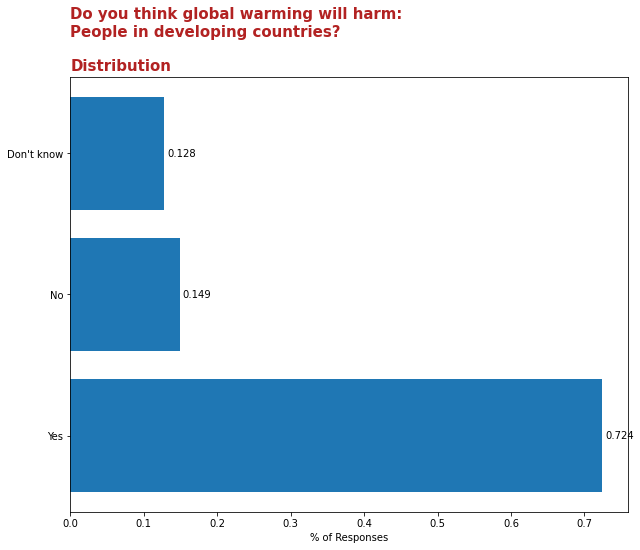

In [68]:
distgraph('harm_dev_countries',
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')

**Observation**
  *  A majority of respondents (71.9%) answered Yes that global warming will harm people in developing countries.
  *  14.8% of respondents answered No
  *  Around 13.3% of respondents either did not know or refused to answer


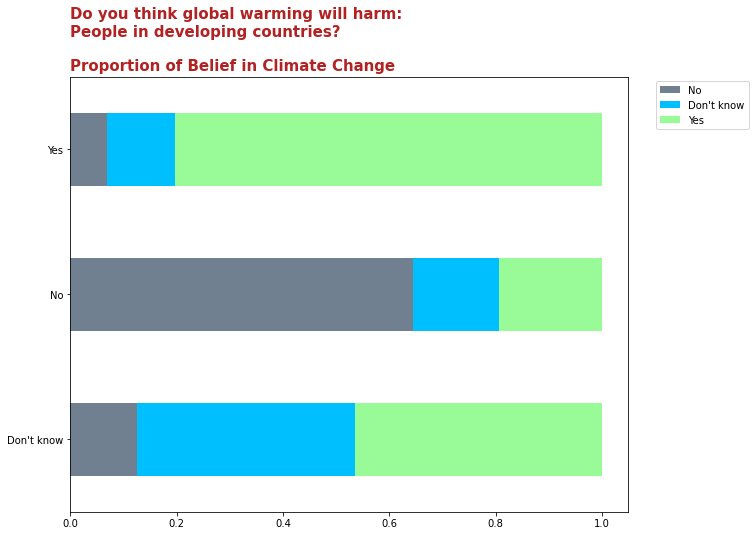

In [69]:
propgraph('harm_dev_countries',
          ['Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')


  
**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_future_gen`
**How much do you think global warming will harm: Future generations of people**

In [70]:
list(df.harm_future_gen.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 nan]

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [71]:
df.harm_future_gen = df.harm_future_gen.replace({i:j for i,j in my_dict.items()})

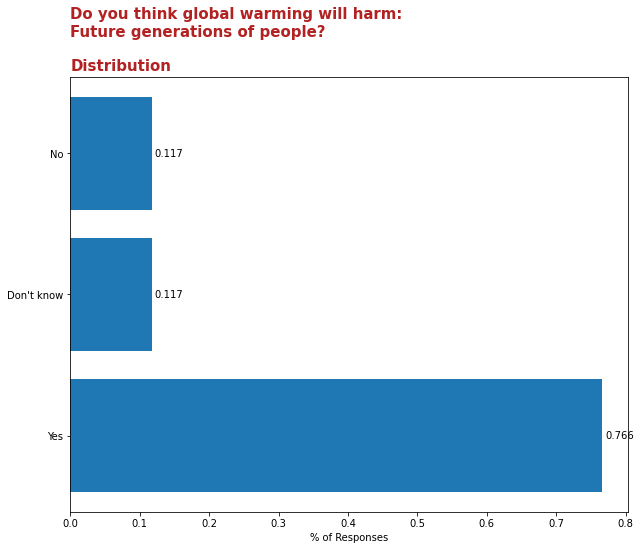

In [72]:
distgraph('harm_future_gen',
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  A majority of respondents (76.0%) answered Yes that global warming will harm future generations of people.
  *  11.9% of respondents answered No
  *  Around 12.1% of respondents either did not know or refused to answer


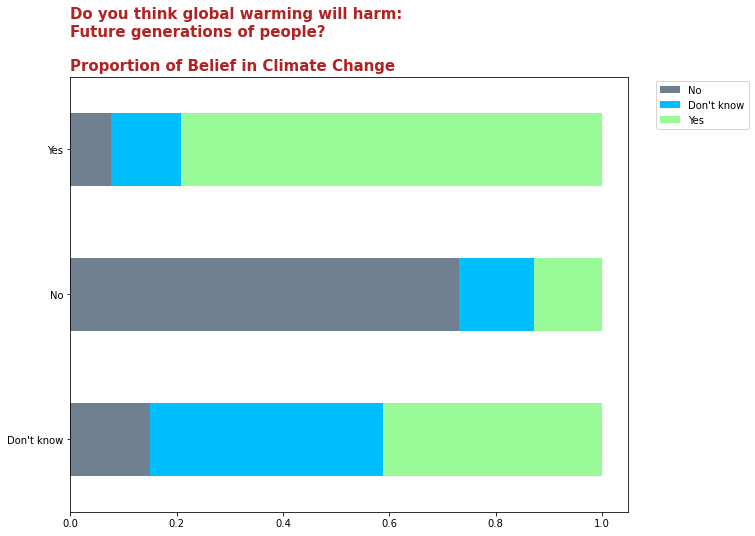

In [73]:
propgraph('harm_future_gen',
          ['Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_plants_animals`
**How much do you think global warming will harm: Plant and animal species**

In [74]:
df.harm_plants_animals.isnull().sum() / df.shape[0]

0.06206771845757425

6% of respondents were not offered this question as it was not asked in Oct 2015. These will need to be imputed.

In [75]:
list(df.harm_plants_animals.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 nan]

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [76]:
df.harm_plants_animals = df.harm_plants_animals.replace({i:j for i,j in my_dict.items()})

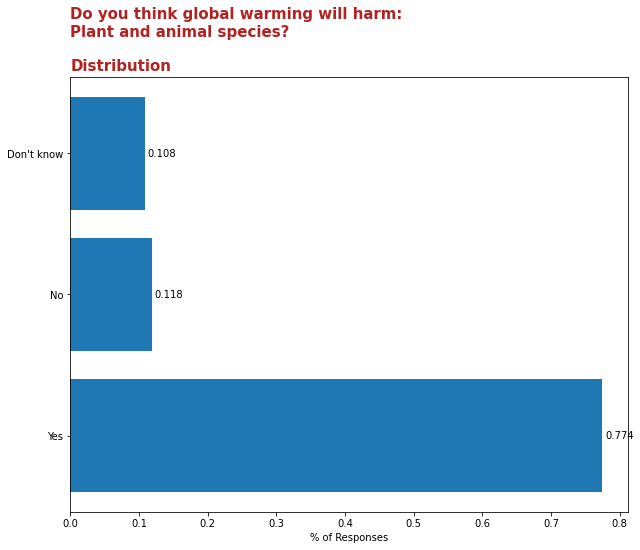

In [77]:
distgraph('harm_plants_animals',
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  A majority of respondents (76.8%) answered Yes that global warming will harm plants and animals.
  *  11.7% of respondents answered No
  *  Around 11.4% of respondents either did not know or refused to answer

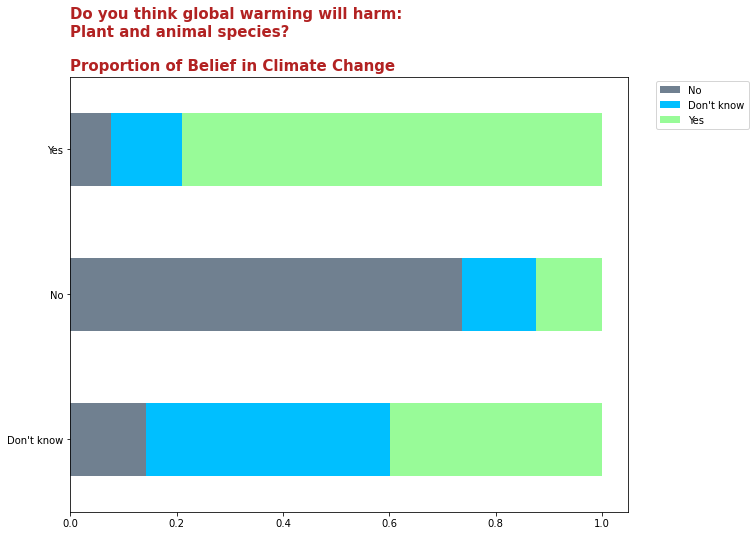

In [78]:
propgraph('harm_plants_animals',
          ['Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know didn't know if they believe in global warming, closely followed by Yes.
  *  A majority of respondents for Refused believed in global warming.

#### `when_harm_us`
**When do you think global warming will start to harm people in the United States?**

In [79]:
list(df.when_harm_US.unique())

['In 10 years',
 'In 50 years',
 'Never',
 'In 25 years',
 'In 100 years',
 'They are being harmed now',
 nan]

The response options. Map these to Refused, Never, In the Future, and Now for more absolute groupings.

In [80]:
my_dict = {'In 10 years': 'In the Future',
           'In 50 years': 'In the Future',
           'Never': 'Never',
           'In 25 years': 'In the Future',
           'In 100 years': 'In the Future',
           'They are being harmed now': 'Now',
           'Refused': 'Refused'}

df.when_harm_US = df.when_harm_US.replace({i:j for i,j in my_dict.items()})

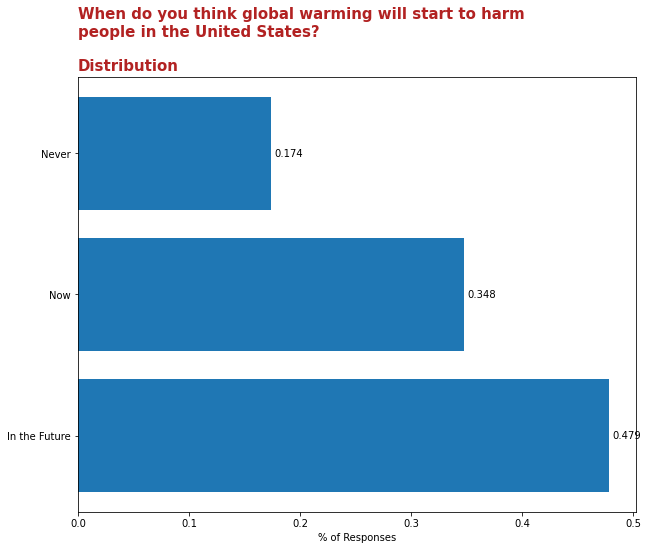

In [81]:
distgraph('when_harm_US',
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  A plurality of respondents (47.5%) answered `In the Future` for when global warming will start to harm people in the United States.
  *  34.5% of respondents answered `Now`
  *  17.3% of respondents answer `Never`

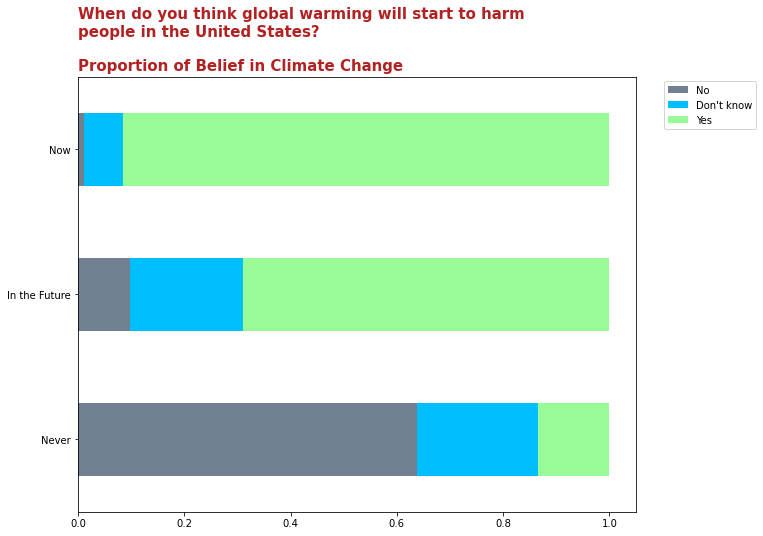

In [82]:
propgraph('when_harm_US',
          ['Never', 'In the Future','Now'],
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  Unsurprisingly, `Now` and `In the Future` both believe in global warming by a large margin
  *  Respondents for `Never` still held decent amounts of Don't Know and Yes for belief in global warming indicating that global warming may not be inherently harmful in their mind.

#### `reg_CO2_pollutant`
**How much do you support or oppose the following policies?
Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.**

In [83]:
df.reg_CO2_pollutant.isnull().sum()/df.shape[0]

0.0607115410695719

4.5% of respondents were not offered this question as it was not asked in May 2011. These will need to be imputed.

In [84]:
list(df.reg_CO2_pollutant.unique())

['Strongly support',
 'Somewhat support',
 'Somewhat oppose',
 'Strongly oppose',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [85]:
my_dict = {'Strongly support': 'Support',
           'Somewhat support': 'Support',
           'Somewhat oppose': 'Oppose',
           'Strongly oppose': 'Oppose',
           'Refused': 'Refused'}

df.reg_CO2_pollutant = df.reg_CO2_pollutant.replace({i:j for i,j in my_dict.items()})

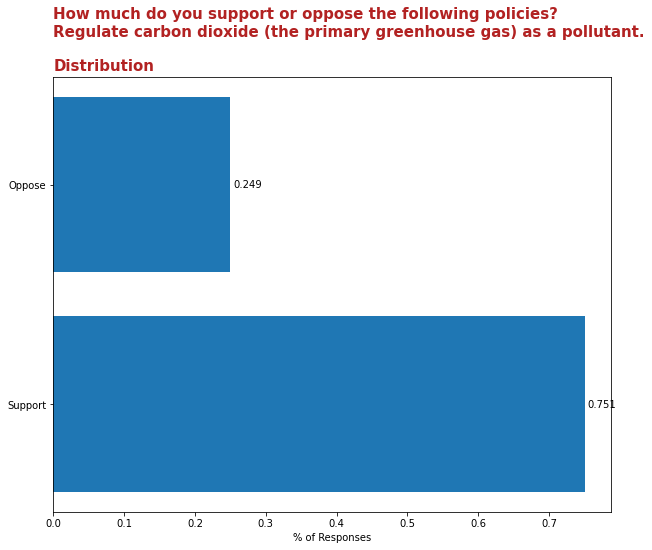

In [86]:
distgraph('reg_CO2_pollutant',
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  A majority of respondents (73.2%) support regulating carbon dioxide.
  *  24.4% of respondents answered No
  *  Around 2.4% of respondents either did not know or refused to answer

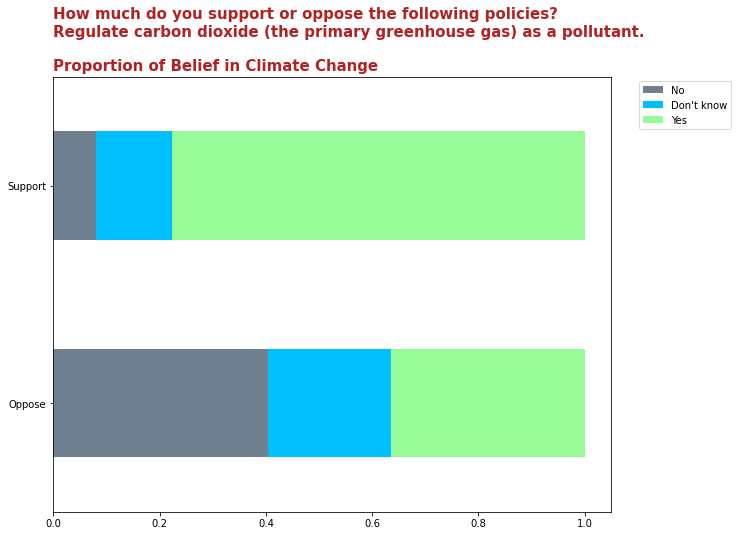

In [87]:
propgraph('reg_CO2_pollutant',
          ['Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_utilities`
**How much do you support or oppose the following policies? Require electric utilities to produce at least 20% of their electricity from wind, solar, or other renewable energy sources, even if it costs the average household an extra $100 a year.**

In [88]:
df.reg_utilities.isnull().sum() / df.shape[0]

0.23954613263414853

22.5% of respondents were not offered this question as it was not asked in Oct 2015, Mar and Nov 2016, and May 2017. These will need to be imputed.

In [89]:
list(df.reg_utilities .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [90]:
df.reg_utilities = df.reg_utilities.replace({i:j for i,j in my_dict.items()})

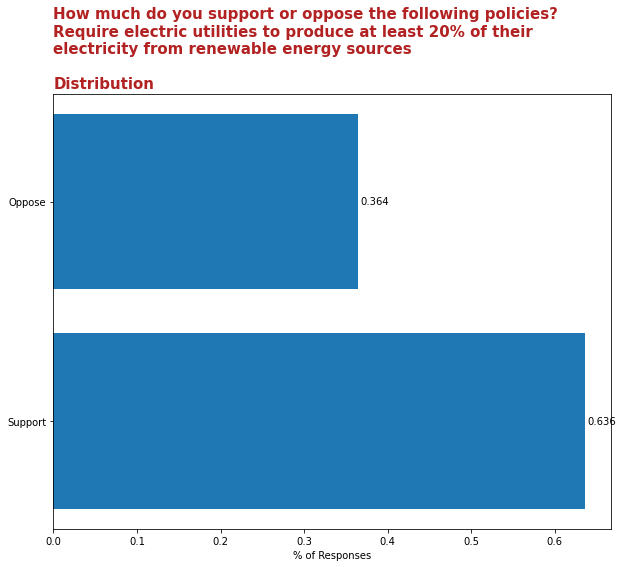

In [91]:
distgraph('reg_utilities',
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  A majority of respondents (61.9%) support requiring electric utilities to produce at least 20% renewable energy.
  *  35.5% of respondents answered No
  *  Around 2.6% of respondents either did not know or refused to answer

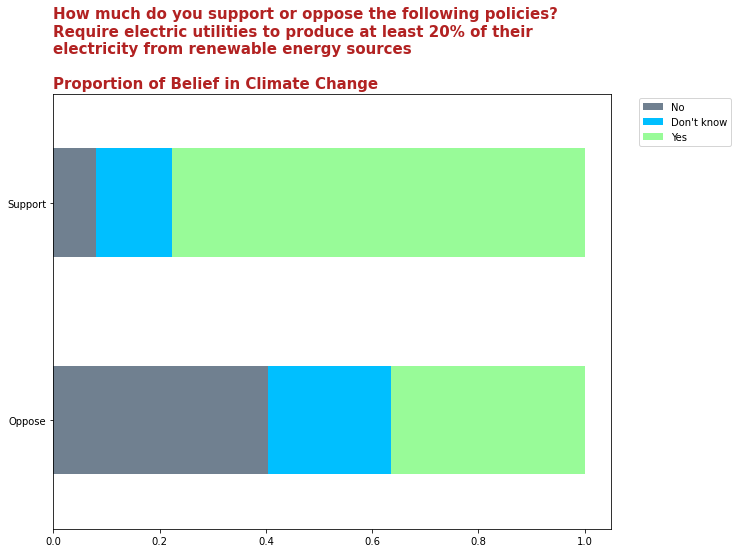

In [92]:
propgraph('reg_CO2_pollutant',
          ['Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `fund_research`
**How much do you support or oppose the following policies? Fund more research into renewable energy sources, such as solar and wind power.**

In [93]:
list(df.fund_research .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [94]:
df.fund_research = df.fund_research.replace({i:j for i,j in my_dict.items()})

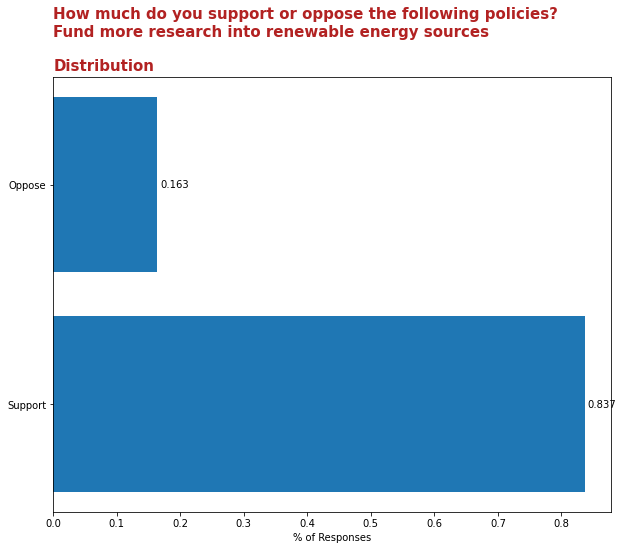

In [95]:
distgraph('fund_research',
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  A majority of respondents (81.8%) support funding more research into renewable energy sources.
  *  16.0% of respondents answered No
  *  Around 2.2% of respondents refused to answer

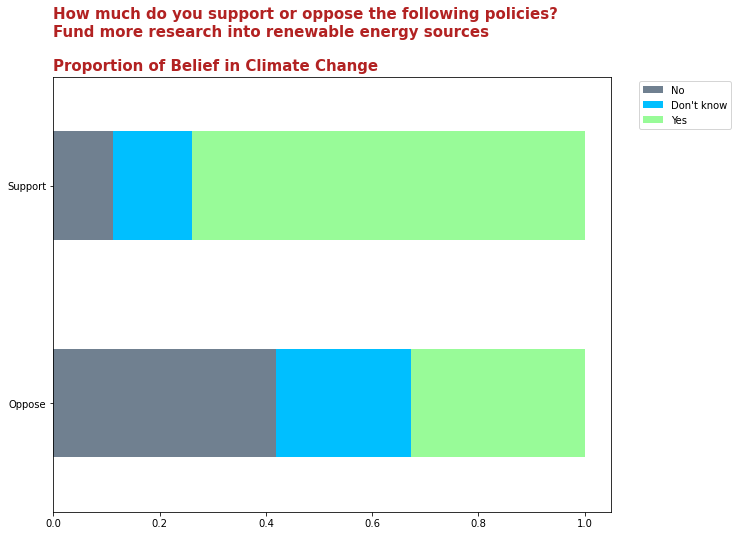

In [96]:
propgraph('fund_research',
          ['Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_coal_emissions`
**How much do you support or oppose the following policy? Set strict carbon dioxide emission limits on existing coal-fired power plants to reduce global warming and improve public health. Power plants would have to reduce their emissions and/or invest in renewable energy and energy efficiency. The cost of electricity to consumers and companies would likely increase**

In [97]:
df.reg_coal_emissions.isnull().sum() / df.shape[0]

0.4071696577912391

40.4% of respondents were not offered this question as it was not asked between 2008 and 2012, and Nov 2013.

Because of this high amount of missingness, drop the column.

In [98]:
df.drop('reg_coal_emissions', axis = 1, inplace=True)

#### `discuss_GW`
**How often do you discuss global warming with your family and friends?**

In [99]:
list(df.discuss_GW.unique())

['Occasionally', 'Rarely', 'Never', 'Often', nan]

The response options. Map these to Refused, Never, At All for more absolute groupings

In [100]:
my_dict = {'Occasionally': 'At All',
           'Rarely': 'At All',
           'Never': 'Never',
           'Often': 'At All',
           'Refused': 'Refused'}

df.discuss_GW = df.discuss_GW.replace({i:j for i,j in my_dict.items()})

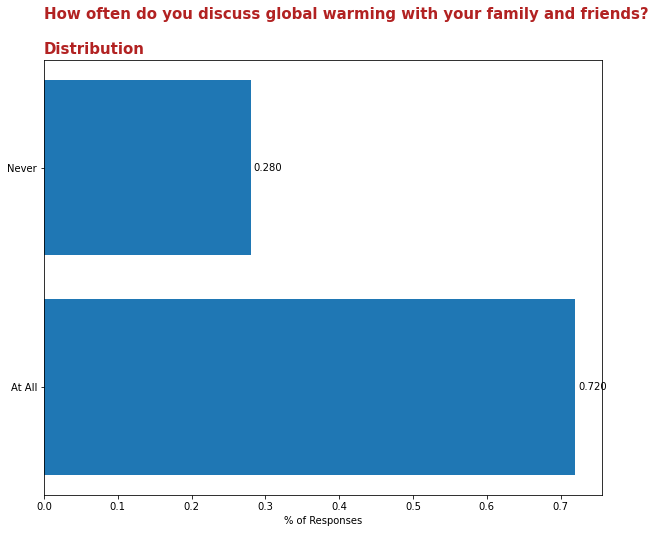

In [101]:
distgraph('discuss_GW',
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  A majority of respondents discuss global warming with family and friends

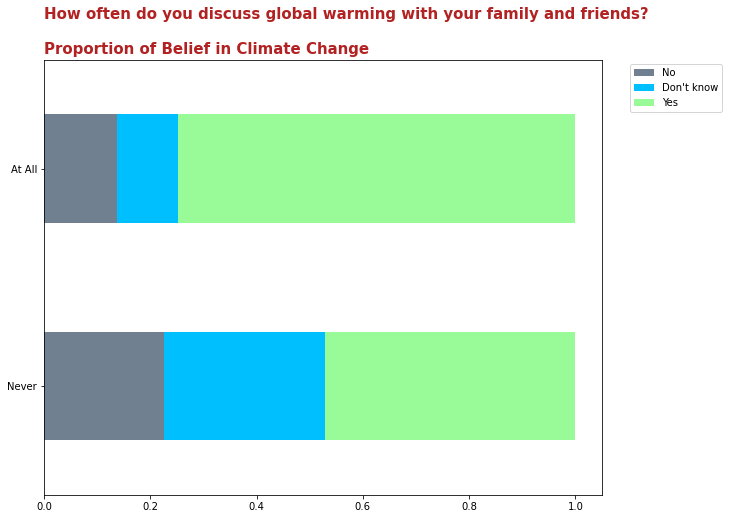

In [102]:
propgraph('discuss_GW',
          ['Never','At All'],
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  Despite `Never` discussing global warming with family and friends, that group of respondents still believes in global warming on average along with `At All`

#### `hear_GW_media`
**About how often do you hear about global warming in the media (TV, movies, radio, newspapers/news websites, magazines, etc.)?**

In [103]:
df.hear_GW_media.isnull().sum() / df.shape[0]

0.608878441300122

60.8% of respondents were not offered this question as it was not asked between 2008 and 2014, and Nov 2016.

Because of this high amount of missingness, drop the column.

In [104]:
df.drop('hear_GW_media', axis = 1, inplace=True)

#### `gender`
**Are you Male or Female?**

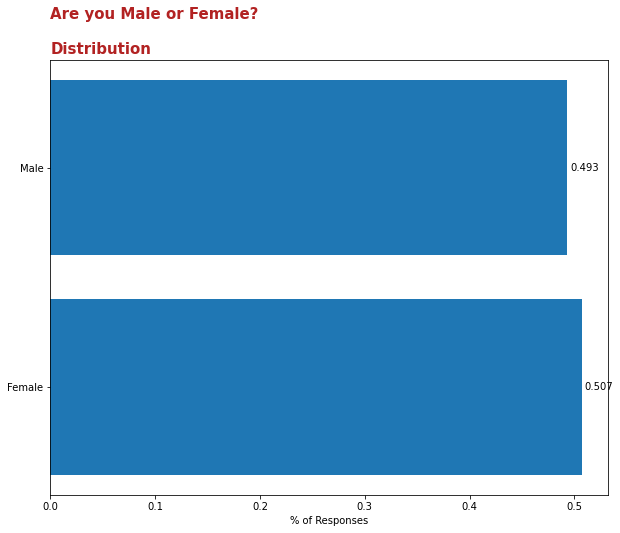

In [105]:
distgraph('gender',
          'Are you Male or Female?')

**Observation**
  *  The distribution of responses is very close to even with `female` representing a majority of responses at 50.8%

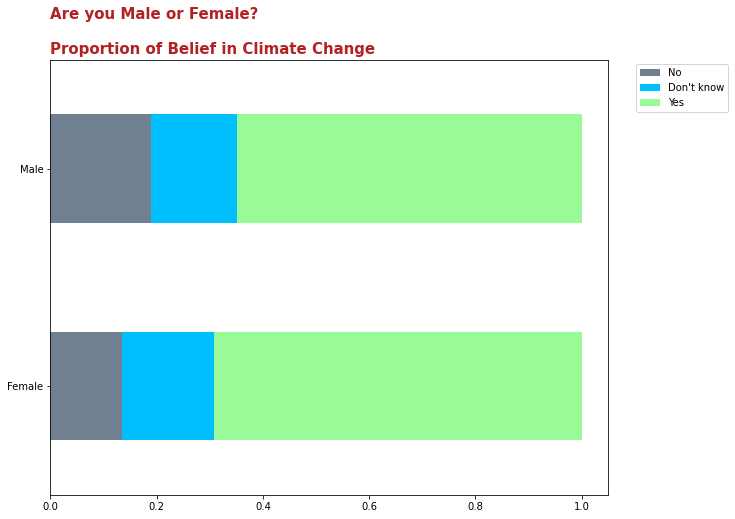

In [106]:
propgraph('gender',
          ['Female','Male'],
          'Are you Male or Female?')

**Observation**
  *  `Female` respondents believed in global warming more than `Male` respondents.

In [107]:
# dummify gender to be 0 for male and 1 for female
df.gender = [int(val == 'Female') for val in df.gender]

#### `age`
**How old are you?**

In [108]:
df.age.describe()

count    22121.000000
mean        50.536865
std         16.791539
min         18.000000
25%         37.000000
50%         52.000000
75%         64.000000
max         97.000000
Name: age, dtype: float64

The range of responses was 18-97 meaning only responses from adults were recorded. The average age was 50 years old.

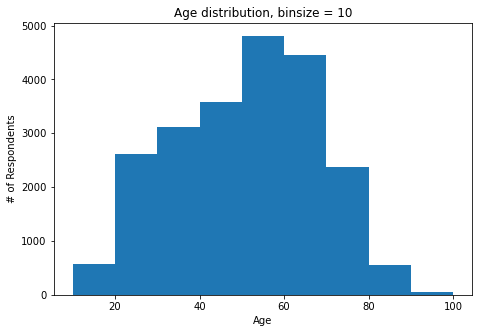

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,5))
ax.hist(df.age,
        bins = np.arange(10,101,10))
ax.set_title('Age distribution, binsize = 10')
ax.set_ylabel('# of Respondents')
ax.set_xlabel('Age');

**Observation**
  *  The age distribution is centered around 50, which is also the mean and contains the median value 52.
  *  Right tailed with small amount of respondents in the 90-100 range.
  *  High number of young respondents also making it more skewed.

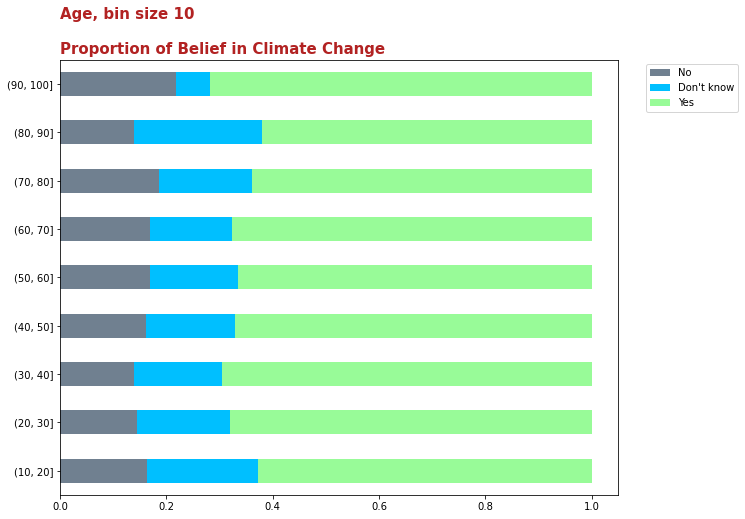

In [110]:
# graph

propgraph(pd.cut(df.age, bins = np.arange(10,101,10)),
          [pd.Interval(10, 20, closed='right'),
           pd.Interval(20, 30, closed='right'),
           pd.Interval(30, 40, closed='right'),
           pd.Interval(40, 50, closed='right'),
           pd.Interval(50, 60, closed='right'),
           pd.Interval(60, 70, closed='right'),
           pd.Interval(70, 80, closed='right'),
           pd.Interval(80, 90, closed='right'),
           pd.Interval(90, 100, closed='right')],
          "Age, bin size 10")

**Observations**
  *  Each age group has a majority of respondents believing in global warming
  *  `20-30` and `30-40` are some of the strongest believers on average
  *  `50-60` was the most popular age bracket for the survey and is one of the softer groups for believing in climate change.

#### `age_category`
**Computed from `age` as a range**

In [111]:
list(df.age_category.unique())

['55+ years', '35-54 years', '18-34 years']

The computed ranges.

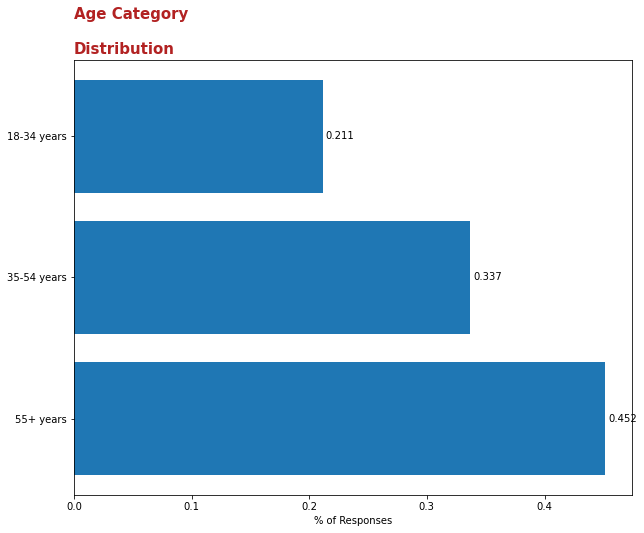

In [112]:
distgraph('age_category',
          'Age Category')

**Observation**
  *  A plurality of respondents are in the 55+ category
  *  The youngest age group is the least represented in the survey

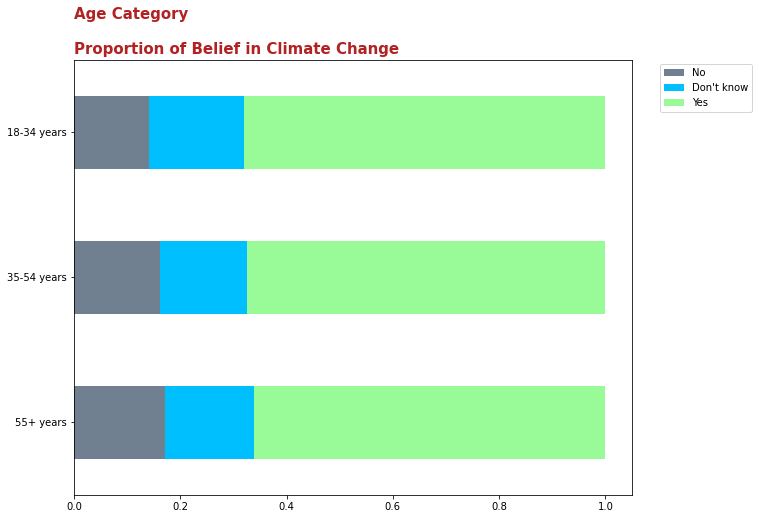

In [113]:
propgraph('age_category',
          ['55+ years','35-54 years','18-34 years'],
          'Age Category')

**Observation**
  *  All three age categories have similar belief proportions.

In [114]:
# dummify age_category and drop 18-34 years as an option
df = df.join(pd.get_dummies(df.age_category, prefix='age_category', 
                            drop_first=True))

# rename the new dummy columns to represent their value
df.rename(columns = {df.columns[-2]:'age_category_35_54', 
                     df.columns[-1]: 'age_category_55_plus'}, 
          inplace=True)

#drop age_category
df.drop('age_category', axis=1, inplace=True)

# VILO

### Dummifying values to do some initial EDA

In [115]:
dum_happen = pd.get_dummies(df['happening'])

### Taking a look at the features below


In [116]:
df2 = df[['generation', 'educ', 'educ_category', 'income', 'income_category',
          'race', 'ideology', 'party', 'party_w_leaners', 'party_x_ideo',
          'registered_voter', 'region9', 'region4']]

In [117]:
df2.describe()

generation  \
count                        22121   
unique                           6   
top     Baby Boomers (1946 - 1964)   
freq                          9057   

                                                     educ  \
count                                               22121   
unique                                                 14   
top     High school graduate - high school diploma or ...   
freq                                                 6219   

                      educ_category                income    income_category  \
count                         22121                 22121              22121   
unique                            4                    21                  3   
top     Bachelor's degree or higher  $100,000 to $124,999  Less than $50,000   
freq                           7642                  2551               8649   

                       race                      ideology     party  \
count                 22121                         21872     22050   
unique                    4                             5         5   
top     White, Non-Hispanic  Moderate, middle of the road  Democrat   
freq                  16624                          8808      7376   

       party_w_leaners             party_x_ideo registered_voter  \
count            22050                    21968            22036   
unique               4                        6                5   
top          Democrats  Conservative Republican       Registered   
freq              9211                     5485            18736   

               region9 region4  
count            22121   22121  
unique               9       4  
top     South Atlantic   South  
freq              4280    7768

### Creating Dummies from the features

In [118]:
df2_dum = pd.get_dummies(df2)

In [119]:
df2_dum.head()

generation_Baby Boomers (1946 - 1964)  \
0                                      0   
1                                      1   
2                                      1   
3                                      0   
4                                      0   

   generation_Generation X (1965 - 1980)  generation_Greatest (Before 1928)  \
0                                      0                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      0                                  0   
4                                      0                                  0   

   generation_Millennials (1981 - 1996)  generation_Silent (1928 - 1945)  \
0                                     0                                1   
1                                     0                                0   
2                                     0                                0   
3                                     0                                1   
4                                     1                                0   

   generation_iGen‎/Gen Z (1997 - )  educ_10th grade  educ_11th grade  \
0                                 0                0                0   
1                                 0                1                0   
2                                 0                0                0   
3                                 0                0                0   
4                                 0                0                0   

   educ_12th grade no diploma  educ_1st, 2nd, 3rd, or 4th grade  ...  \
0                           0                                 0  ...   
1                           0                                 0  ...   
2                           0                                 0  ...   
3                           0                                 0  ...   
4                           0                                 0  ...   

   region9_Mountain  region9_New England  region9_Pacific  \
0                 0                    0                0   
1                 0                    0                0   
2                 1                    0                0   
3                 0                    0                0   
4                 0                    0                0   

   region9_South Atlantic  region9_West-North Central  \
0                       1                           0   
1                       0                           0   
2                       0                           0   
3                       1                           0   
4                       0                           0   

   region9_West-South Central  region4_Midwest  region4_Northeast  \
0                           0                0                  0   
1                           0                1                  0   
2                           0                0                  0   
3                           0                0                  0   
4                           0                0                  0   

   region4_South  region4_West  
0              1             0  
1              0             0  
2              0             1  
3              1             0  
4              1             0  

[5 rows x 90 columns]

In [120]:
df2.shape

(22121, 13)

In [121]:
dummies = pd.concat([df2_dum, dum_happen], axis=1)

### I am looking at the breakdown of people who answered Yes vs Not yes for if global warming is happening

In [122]:
dummies.groupby(['Yes']).mean()

generation_Baby Boomers (1946 - 1964)  \
Yes                                          
0                                 0.404850   
1                                 0.411685   

     generation_Generation X (1965 - 1980)  generation_Greatest (Before 1928)  \
Yes                                                                             
0                                 0.237978                           0.008494   
1                                 0.242208                           0.006140   

     generation_Millennials (1981 - 1996)  generation_Silent (1928 - 1945)  \
Yes                                                                          
0                                0.174270                         0.163310   
1                                0.186614                         0.139995   

     generation_iGen‎/Gen Z (1997 - )  educ_10th grade  educ_11th grade  \
Yes                                                                       
0                            0.011097         0.016989         0.022195   
1                            0.013359         0.012954         0.018554   

     educ_12th grade no diploma  educ_1st, 2nd, 3rd, or 4th grade  ...  \
Yes                                                                ...   
0                      0.025209                          0.000822  ...   
1                      0.020375                          0.001687  ...   

     region9_Pacific  region9_South Atlantic  region9_West-North Central  \
Yes                                                                        
0           0.131251                0.192903                    0.082066   
1           0.164688                0.193766                    0.074416   

     region9_West-South Central  region4_Midwest  region4_Northeast  \
Yes                                                                   
0                      0.109741         0.251541           0.163858   
1                      0.099109         0.229524           0.192417   

     region4_South  region4_West  Don't know        No  
Yes                                                     
0         0.374161      0.210440    0.509796  0.490204  
1         0.339833      0.238227    0.000000  0.000000  

[2 rows x 92 columns]

In [123]:
dummies.corr()

generation_Baby Boomers (1946 - 1964)  \
generation_Baby Boomers (1946 - 1964)                               1.000000   
generation_Generation X (1965 - 1980)                              -0.468941   
generation_Greatest (Before 1928)                                  -0.069487   
generation_Millennials (1981 - 1996)                               -0.393461   
generation_Silent (1928 - 1945)                                    -0.346599   
...                                                                      ...   
region4_South                                                      -0.007791   
region4_West                                                       -0.028786   
Don't know                                                         -0.025189   
No                                                                  0.017242   
Yes                                                                 0.006536   

                                       generation_Generation X (1965 - 1980)  \
generation_Baby Boomers (1946 - 1964)                              -0.468941   
generation_Generation X (1965 - 1980)                               1.000000   
generation_Greatest (Before 1928)                                  -0.047002   
generation_Millennials (1981 - 1996)                               -0.266141   
generation_Silent (1928 - 1945)                                    -0.234443   
...                                                                      ...   
region4_South                                                       0.005177   
region4_West                                                        0.010015   
Don't know                                                          0.002244   
No                                                                 -0.008219   
Yes                                                                 0.004651   

                                       generation_Greatest (Before 1928)  \
generation_Baby Boomers (1946 - 1964)                          -0.069487   
generation_Generation X (1965 - 1980)                          -0.047002   
generation_Greatest (Before 1928)                               1.000000   
generation_Millennials (1981 - 1996)                           -0.039437   
generation_Silent (1928 - 1945)                                -0.034739   
...                                                                  ...   
region4_South                                                  -0.001974   
region4_West                                                    0.005132   
Don't know                                                      0.013509   
No                                                              0.003337   
Yes                                                            -0.013360   

                                       generation_Millennials (1981 - 1996)  \
generation_Baby Boomers (1946 - 1964)                             -0.393461   
generation_Generation X (1965 - 1980)                             -0.266141   
generation_Greatest (Before 1928)                                 -0.039437   
generation_Millennials (1981 - 1996)                               1.000000   
generation_Silent (1928 - 1945)                                   -0.196707   
...                                                                     ...   
region4_South                                                      0.002946   
region4_West                                                       0.020625   
Don't know                                                         0.007747   
No                                                                -0.027057   
Yes                                                                0.015025   

                                       generation_Silent (1928 - 1945)  \
generation_Baby Boomers (1946 - 1964)                        -0.346599   
generation_Generation X (1965 - 1980)                        -0.234443   
generation_Greatest (Before 1928)

In [124]:
top_corr1 = pd.DataFrame(dummies.corr().sort_values(by='Yes', ascending=False)['Yes'][:20])

### Looking at the top positive correlated features with answering yes to 'happening'

In [125]:
top_corr1

Yes
Yes                                          1.000000
party_w_leaners_Democrats                    0.356954
party_Democrat                               0.284439
party_x_ideo_Liberal Democrat                0.280436
ideology_Somewhat liberal                    0.217754
party_x_ideo_Moderate/Conservative Democrat  0.154727
ideology_Very liberal                        0.132375
educ_category_Bachelor's degree or higher    0.100594
ideology_Moderate, middle of the road        0.088630
educ_Master's degree                         0.067241
educ_Professional or Doctorate degree        0.054876
race_Hispanic                                0.045104
region9_Pacific                              0.043597
race_Black, Non-Hispanic                     0.041774
educ_Bachelor's degree                       0.041113
income_category_$100,000 or more             0.036563
region4_Northeast                            0.034729
race_Other, Non-Hispanic                     0.034640
region4_West                                 0.031091
region9_Mid-Atlantic                         0.028445

In [126]:
top_corr_neg = pd.DataFrame(dummies.corr().sort_values(by='Yes')['Yes'][:20])

### The top negative correlated features for answering yes to 'happening'

In [127]:
top_corr_neg

Yes
Don't know                                         -0.640830
No                                                 -0.625968
party_x_ideo_Conservative Republican               -0.336897
party_w_leaners_Republicans                        -0.318275
ideology_Very conservative                         -0.266844
party_Republican                                   -0.259078
ideology_Somewhat conservative                     -0.181562
race_White, Non-Hispanic                           -0.077818
educ_category_High school                          -0.064798
educ_High school graduate - high school diploma... -0.064798
party_Other; Please specify:                       -0.051661
region9_East-South Central                         -0.050626
party_No party/not interested in politics          -0.047157
party_w_leaners_No party/Not interested in poli... -0.047157
party_x_ideo_No Party/Not Interested in politics   -0.047157
registered_voter_Don't know                        -0.038148
region4_South                                      -0.033815
educ_category_Less than high school                -0.031764
generation_Silent (1928 - 1945)                    -0.030900
registered_voter_Prefer not to answer              -0.028878

''

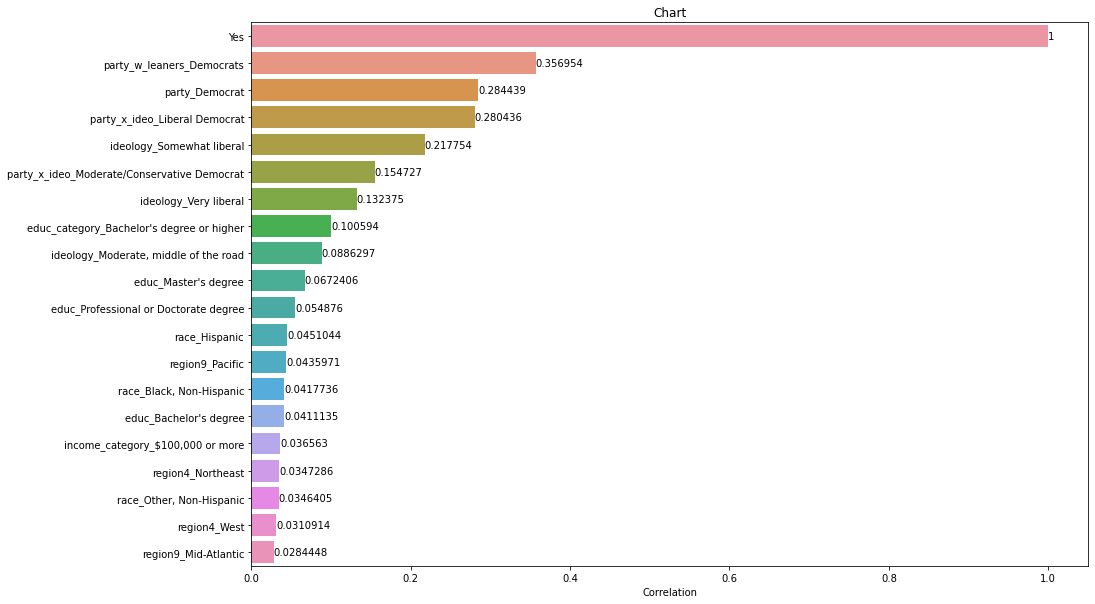

In [128]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Yes', y=top_corr1.index, data=top_corr1, orient='h')
ax.set_xlabel('Correlation')
ax.set_title('Chart')
for i in ax.containers:
    ax.bar_label(i)
;

''

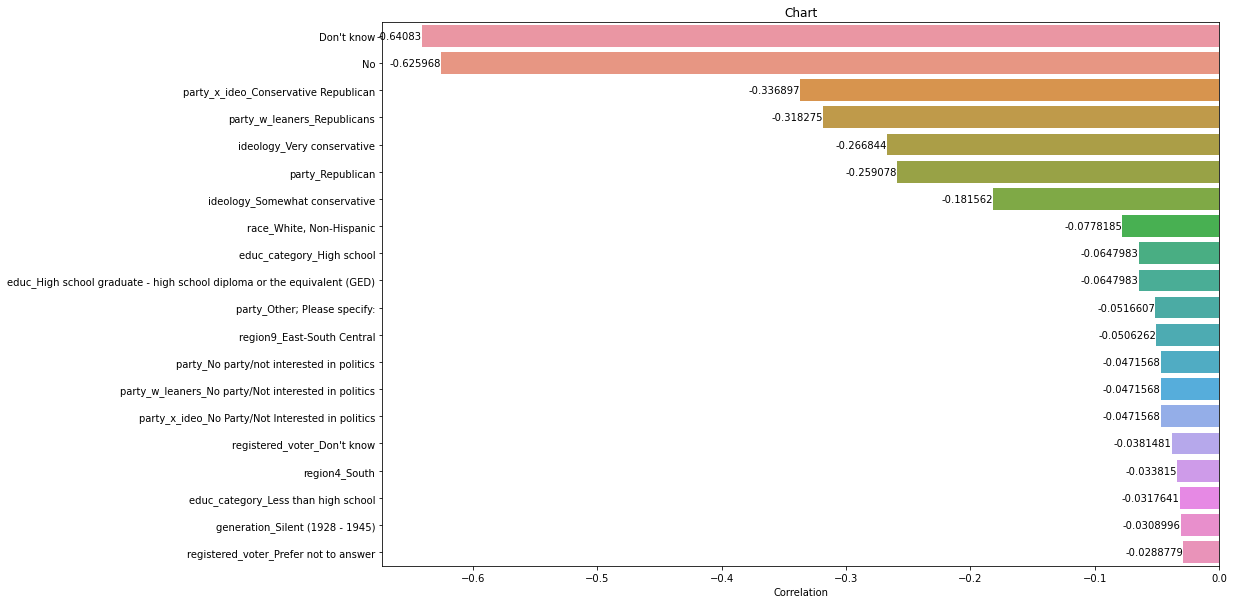

In [129]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Yes', y=top_corr_neg.index, data=top_corr_neg)
ax.set_xlabel('Correlation')
ax.set_title('Chart')
for i in ax.containers:
    ax.bar_label(i)
;

### A rough correlation heat map between features

<AxesSubplot:>

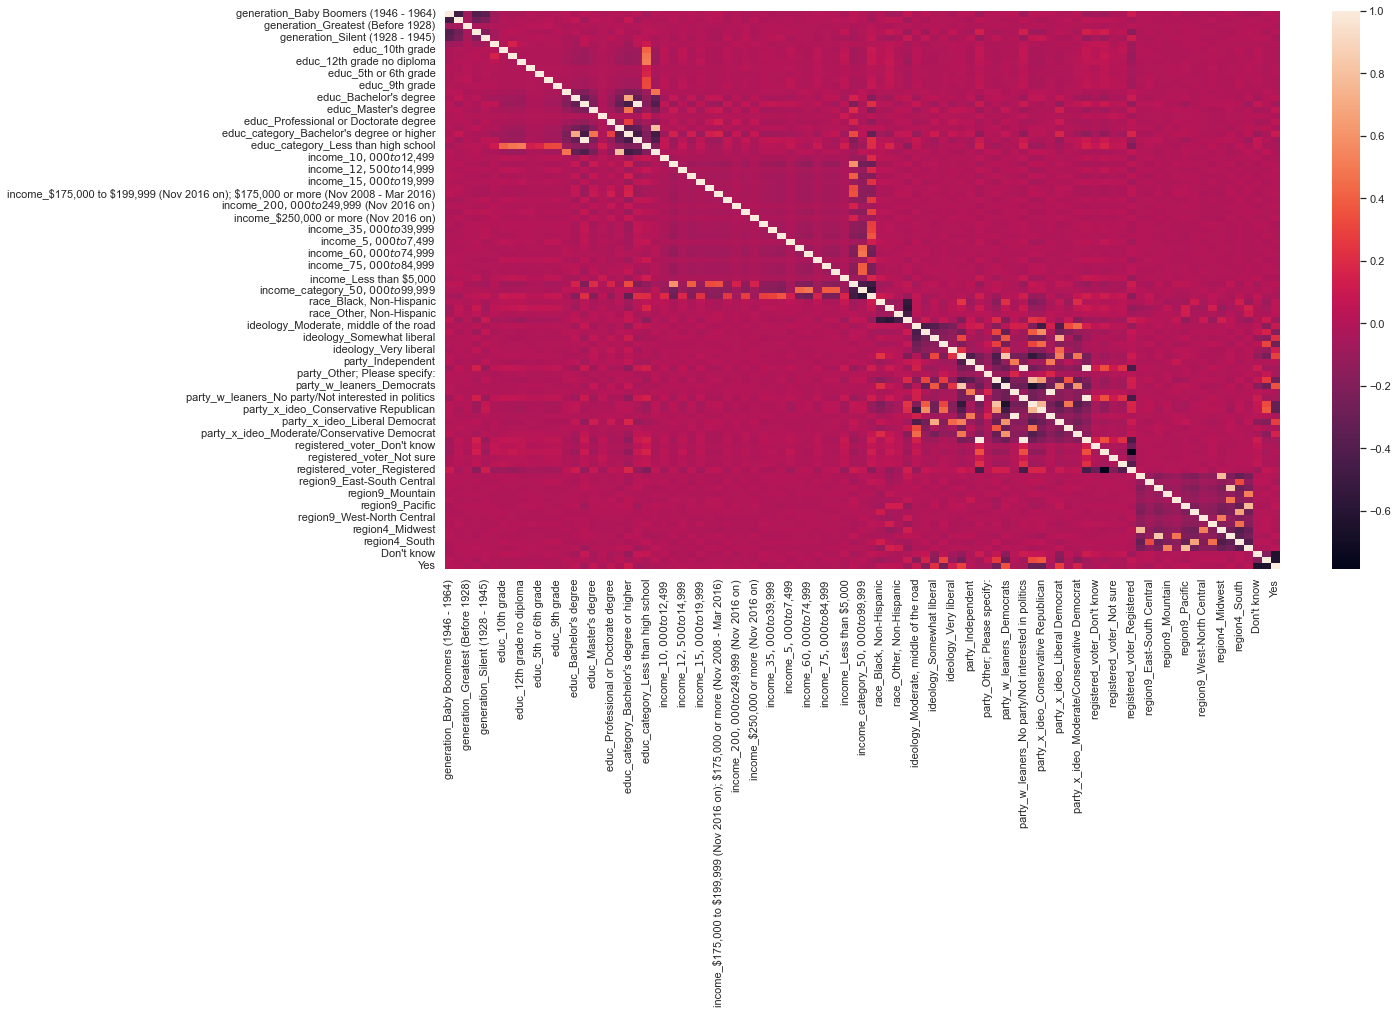

In [130]:
sns.set(rc={'figure.figsize':(18.7,10.27)})
sns.heatmap(dummies.corr())

### Review Variables

#### `Generation`

In [131]:
df2['generation'].value_counts(normalize=True)

Baby Boomers (1946 - 1964)    0.409430
Generation X (1965 - 1980)    0.240812
Millennials (1981 - 1996)     0.182541
Silent (1928 - 1945)          0.147688
iGen‎/Gen Z (1997 - )         0.012612
Greatest (Before 1928)        0.006917
Name: generation, dtype: float64

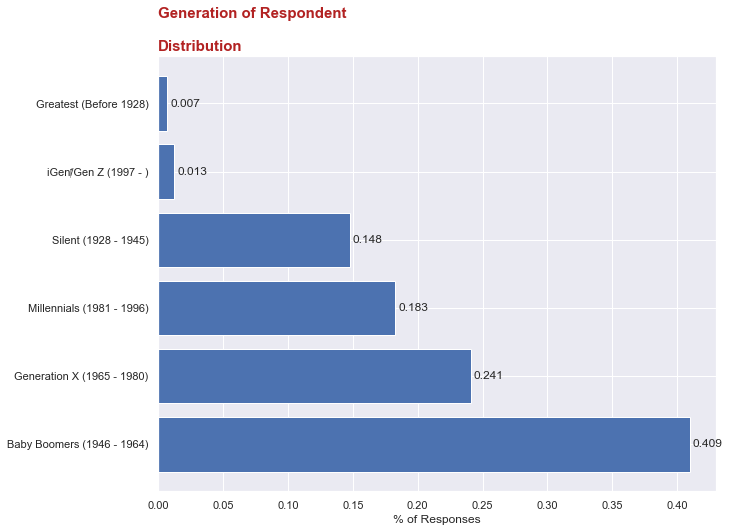

In [132]:
distgraph('generation','Generation of Respondent')

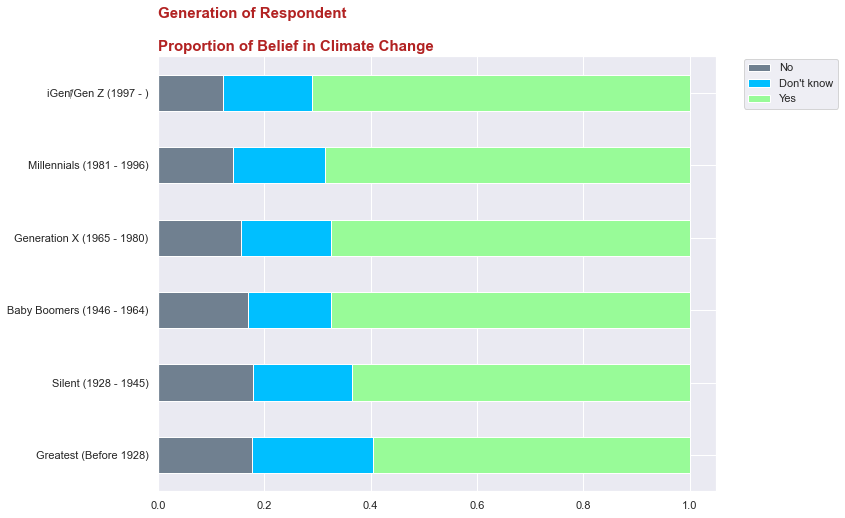

In [133]:
propgraph('generation',
          ['Greatest (Before 1928)',
           'Silent (1928 - 1945)',
           'Baby Boomers (1946 - 1964)',
           'Generation X (1965 - 1980)',
           'Millennials (1981 - 1996)',
           'iGen‎/Gen Z (1997 - )'],
          'Generation of Respondent')

#### `educ`

In [134]:
df2['educ'].value_counts(normalize=True)

High school graduate - high school diploma or the equivalent (GED)    0.281136
Some college, no degree                                               0.208038
Bachelor's degree                                                     0.200036
Master's degree                                                       0.105782
Associate's degree                                                    0.087609
Professional or Doctorate degree                                      0.039646
12th grade no diploma                                                 0.021970
11th grade                                                            0.019755
10th grade                                                            0.014285
9th grade                                                             0.008544
7th or 8th grade                                                      0.008182
5th or 6th grade                                                      0.002486
1st, 2nd, 3rd, or 4th grade                         

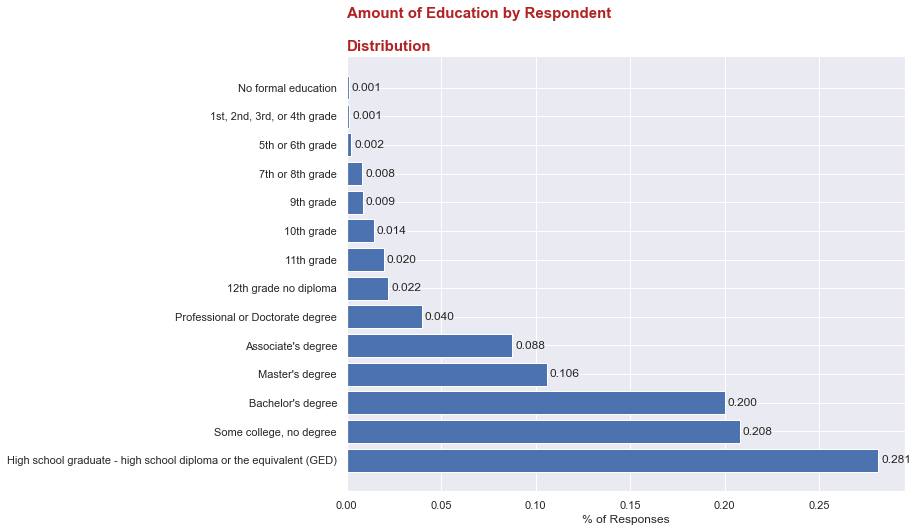

In [135]:
distgraph('educ',
          'Amount of Education by Respondent')

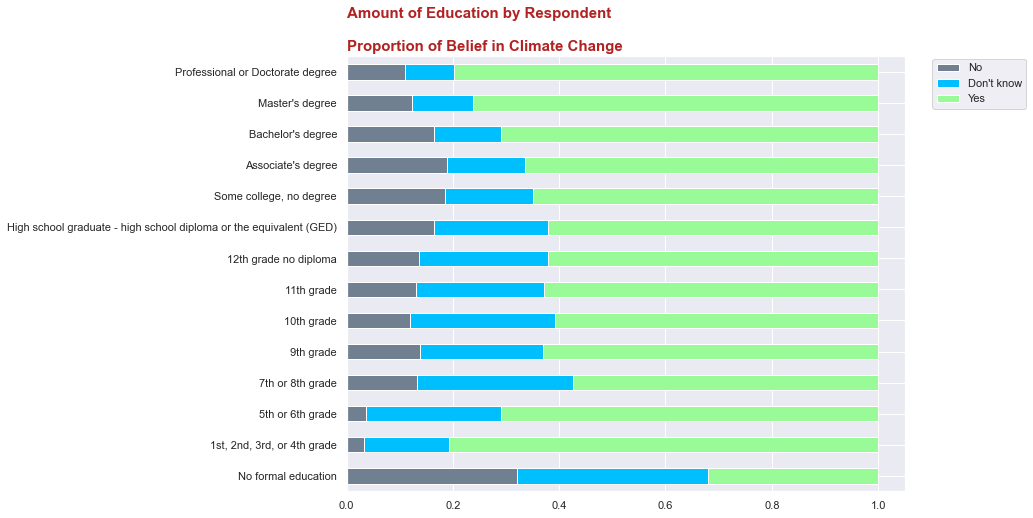

In [136]:
propgraph('educ',
        ['No formal education',
         '1st, 2nd, 3rd, or 4th grade',
         '5th or 6th grade',
         '7th or 8th grade',
         '9th grade',
         '10th grade',
         '11th grade',
         '12th grade no diploma',
         'High school graduate - high school diploma or the equivalent (GED)',
         'Some college, no degree',
         "Associate's degree",
         "Bachelor's degree",
         "Master's degree",
         'Professional or Doctorate degree'],
         'Amount of Education by Respondent')

#### `educ_category`

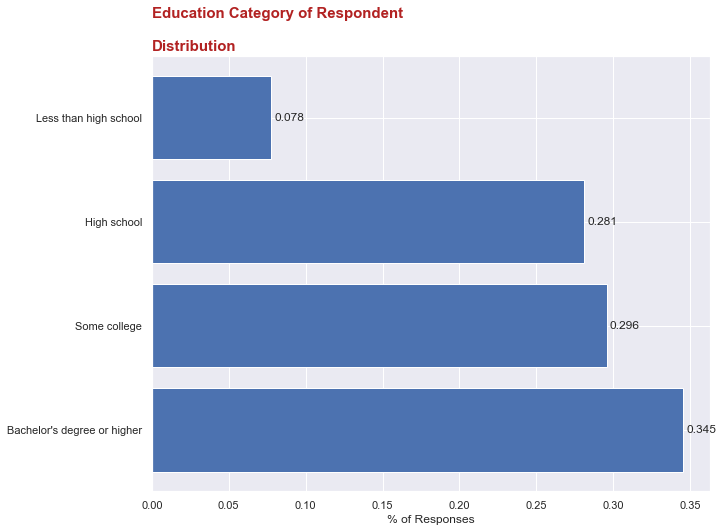

In [137]:
distgraph('educ_category',
          'Education Category of Respondent')

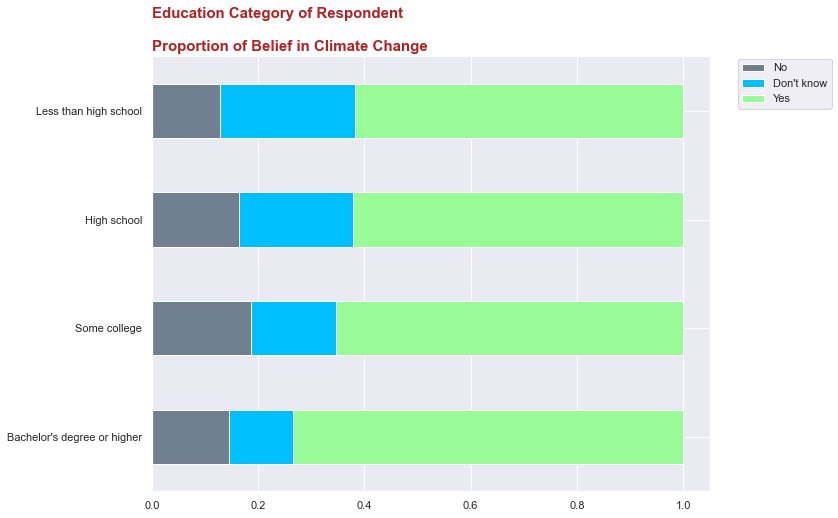

In [138]:
propgraph('educ_category',
          ["Bachelor's degree or higher",
           'Some college',
           'High school',
           'Less than high school'],
         'Education Category of Respondent')

#### `income`

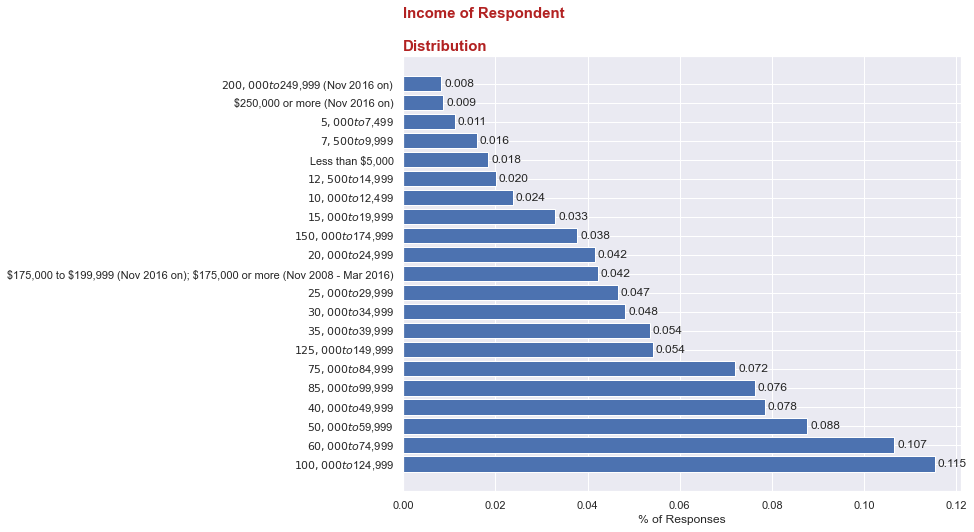

In [139]:
distgraph('income',
          'Income of Respondent')

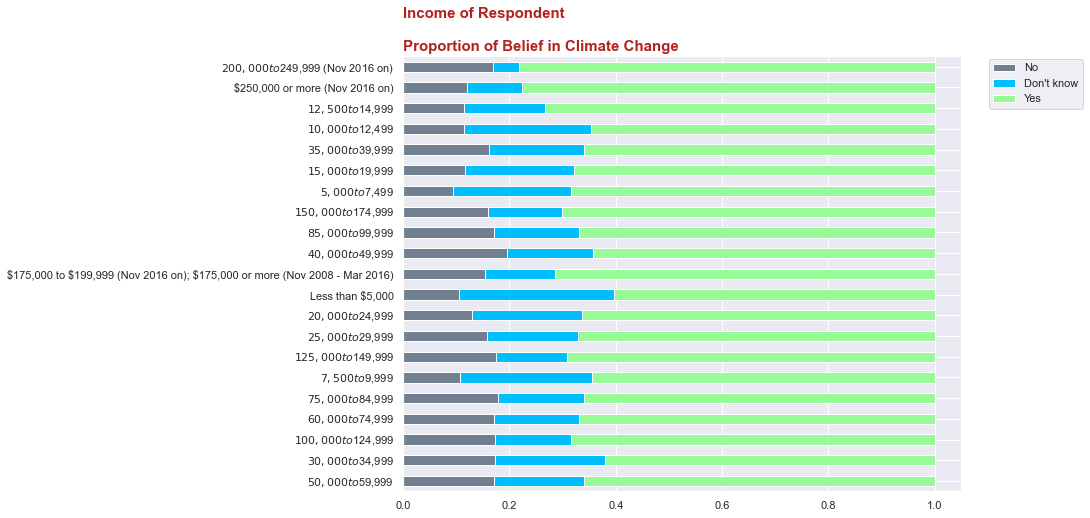

In [140]:
propgraph('income',
          df.income.unique(),
         'Income of Respondent')

In [141]:
df2['income_category'].value_counts(normalize=True)

Less than $50,000     0.390986
$50,000 to $99,999    0.342661
$100,000 or more      0.266353
Name: income_category, dtype: float64

<AxesSubplot:xlabel='income_category', ylabel='Count'>

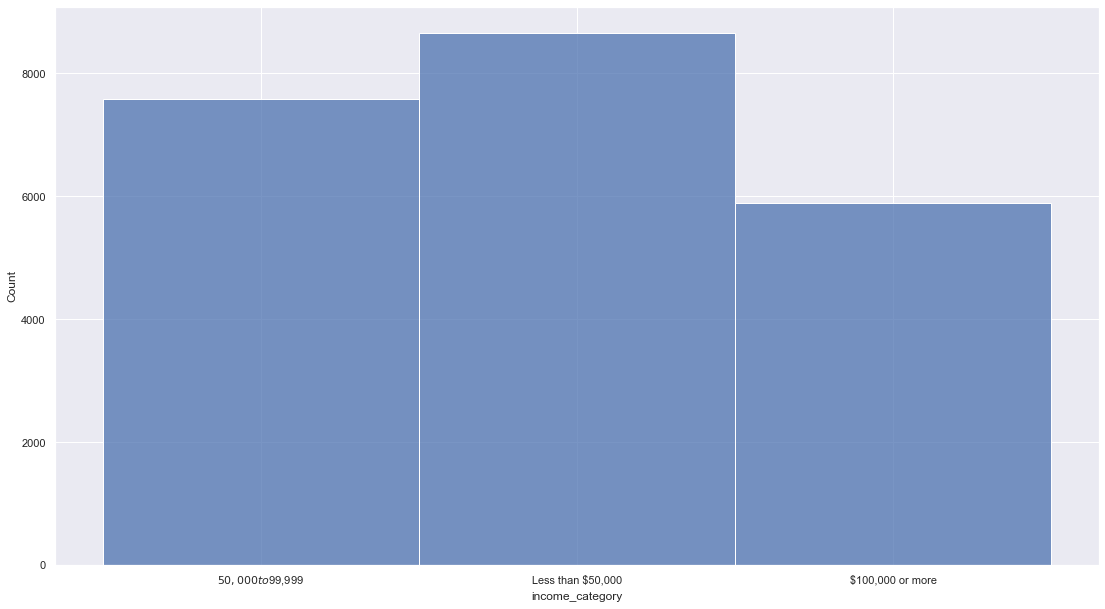

In [142]:
sns.histplot(data=df2, x = 'income_category')

In [143]:
df2['race'].value_counts(normalize=True)

White, Non-Hispanic    0.751503
Hispanic               0.099227
Black, Non-Hispanic    0.087067
Other, Non-Hispanic    0.062203
Name: race, dtype: float64

<AxesSubplot:xlabel='race', ylabel='Count'>

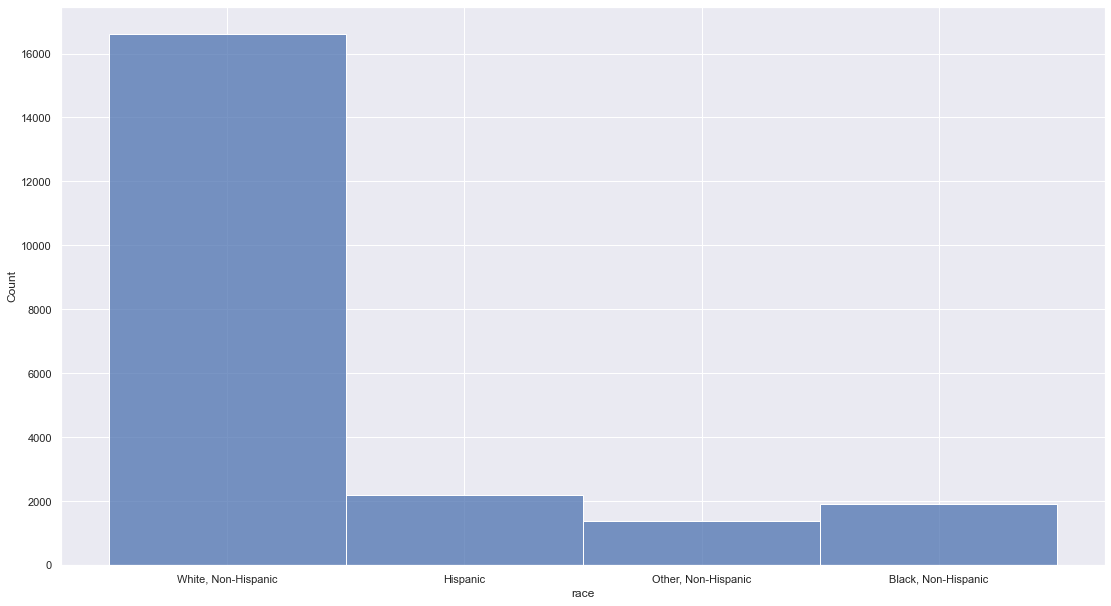

In [144]:
sns.histplot(data=df2, x = 'race')

In [145]:
df2['ideology'].value_counts(normalize=True)

Moderate, middle of the road    0.402707
Somewhat conservative           0.230066
Somewhat liberal                0.184162
Very conservative               0.111787
Very liberal                    0.071278
Name: ideology, dtype: float64

<AxesSubplot:xlabel='ideology', ylabel='Count'>

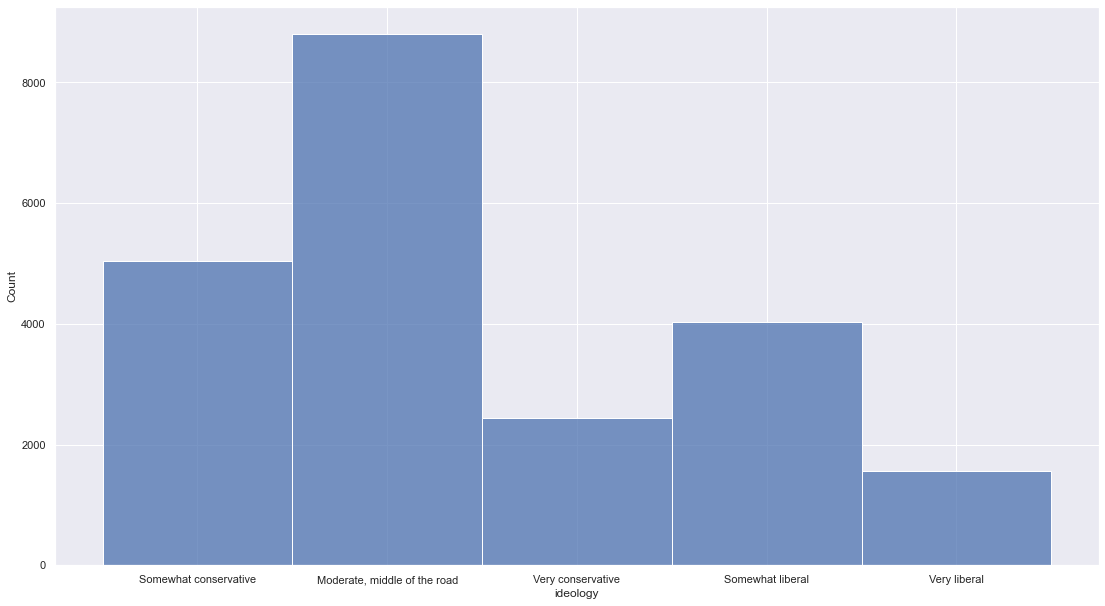

In [146]:
sns.histplot(data=df2, x = 'ideology')

In [147]:
df2['party'].value_counts(normalize=True)

Democrat                               0.334512
Republican                             0.274558
Independent                            0.253107
No party/not interested in politics    0.108027
Other; Please specify:                 0.029796
Name: party, dtype: float64

<AxesSubplot:xlabel='party', ylabel='Count'>

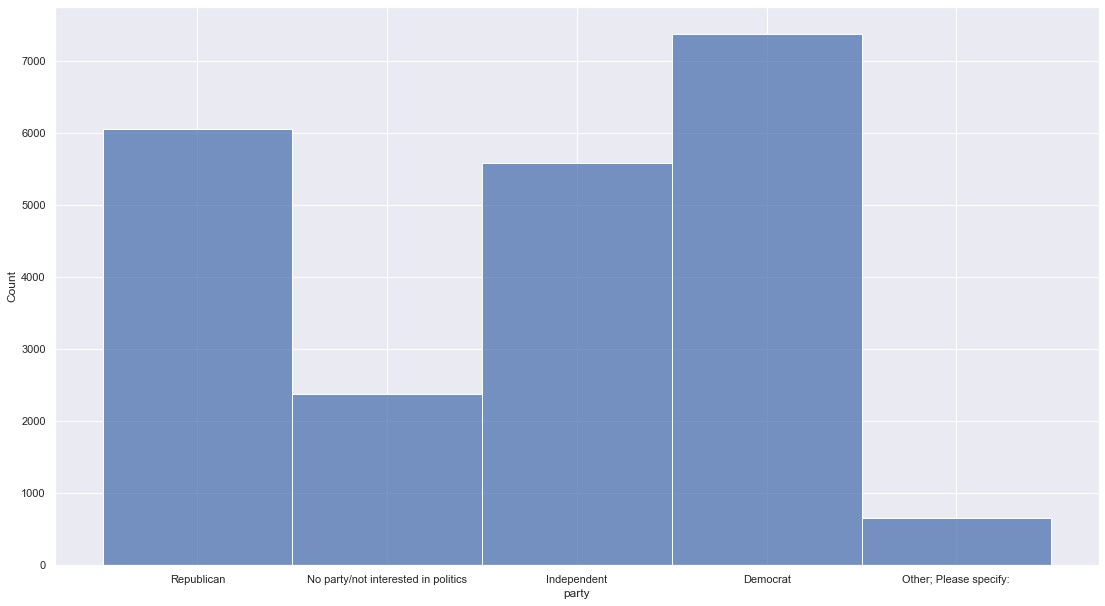

In [148]:
sns.histplot(data=df2, x = 'party')

In [149]:
df2['party_w_leaners'].value_counts(normalize=True)

Democrats                              0.417732
Republicans                            0.368753
No party/Not interested in politics    0.108027
Independent/Other                      0.105488
Name: party_w_leaners, dtype: float64

<AxesSubplot:xlabel='party_w_leaners', ylabel='Count'>

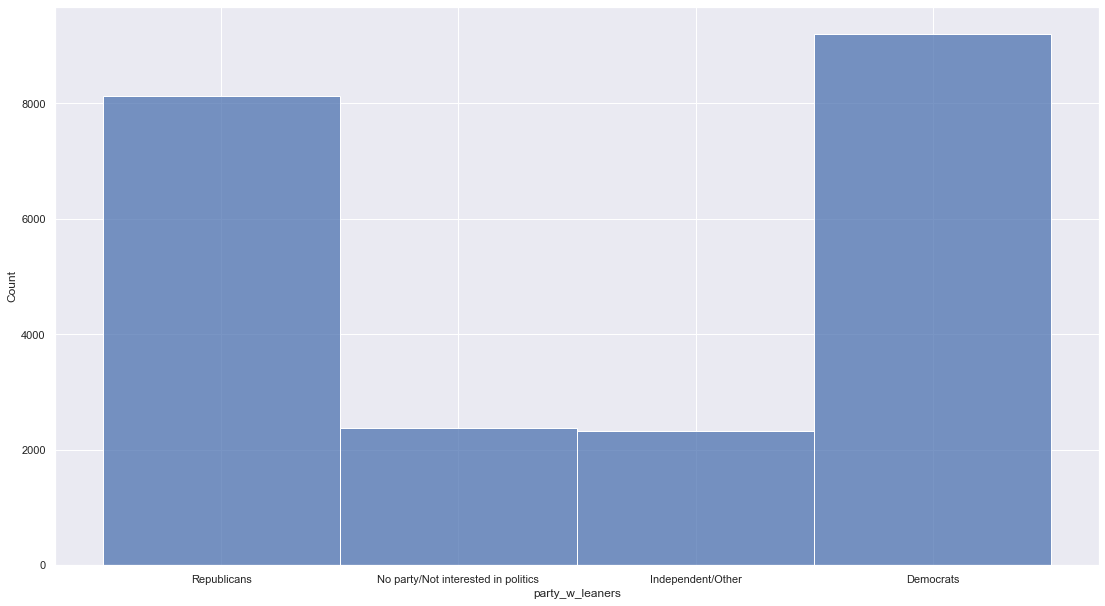

In [150]:
sns.histplot(data=df2, x = 'party_w_leaners')

In [151]:
df2['party_x_ideo'].value_counts(normalize=True)

Conservative Republican                0.249681
Moderate/Conservative Democrat         0.209942
Liberal Democrat                       0.207256
Liberal/Moderate Republican            0.118809
No Party/Not Interested in politics    0.108430
Independent (Non-Leaning)              0.105881
Name: party_x_ideo, dtype: float64

<AxesSubplot:xlabel='party_x_ideo', ylabel='Count'>

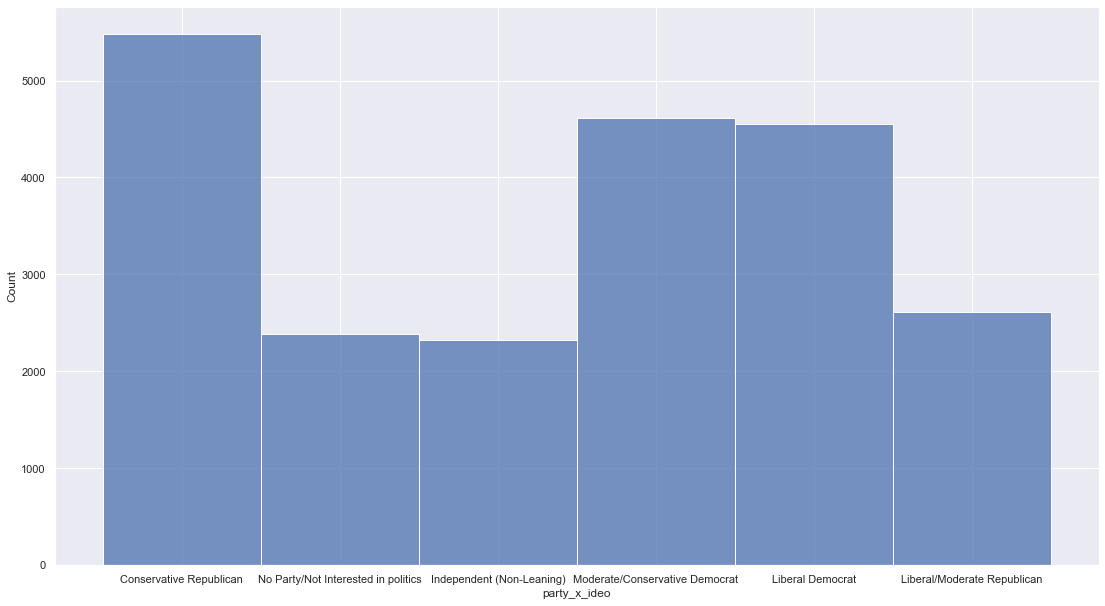

In [152]:
sns.histplot(data=df2, x = 'party_x_ideo')

In [153]:
df2['registered_voter'].value_counts(normalize=True)

Registered              0.850245
Not registered          0.100744
Prefer not to answer    0.026275
Don't know              0.015656
Not sure                0.007079
Name: registered_voter, dtype: float64

<AxesSubplot:xlabel='registered_voter', ylabel='Count'>

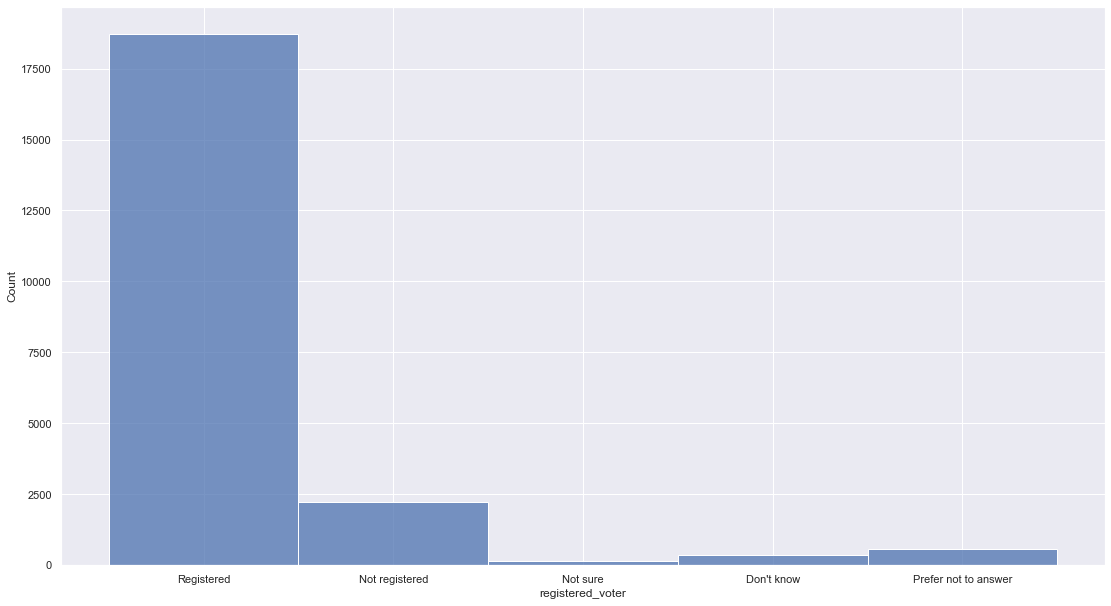

In [154]:
sns.histplot(data=df2, x = 'registered_voter')

In [155]:
df2['region9'].value_counts(normalize=True)

South Atlantic        0.193481
East-North Central    0.159848
Pacific               0.153655
Mid-Atlantic          0.134533
West-South Central    0.102617
West-North Central    0.076940
Mountain              0.075403
East-South Central    0.055061
New England           0.048461
Name: region9, dtype: float64

<AxesSubplot:xlabel='region9', ylabel='Count'>

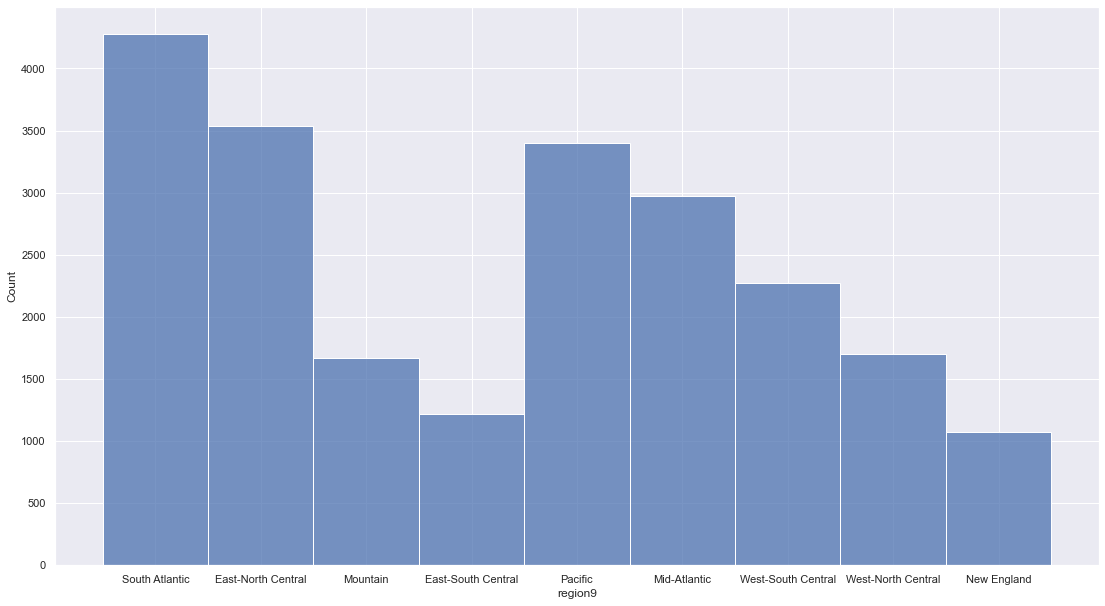

In [156]:
sns.histplot(data=df2, x = 'region9')

In [157]:
df2['region4'].value_counts(normalize=True)

South        0.351160
Midwest      0.236789
West         0.229058
Northeast    0.182994
Name: region4, dtype: float64

<AxesSubplot:xlabel='region4', ylabel='Count'>

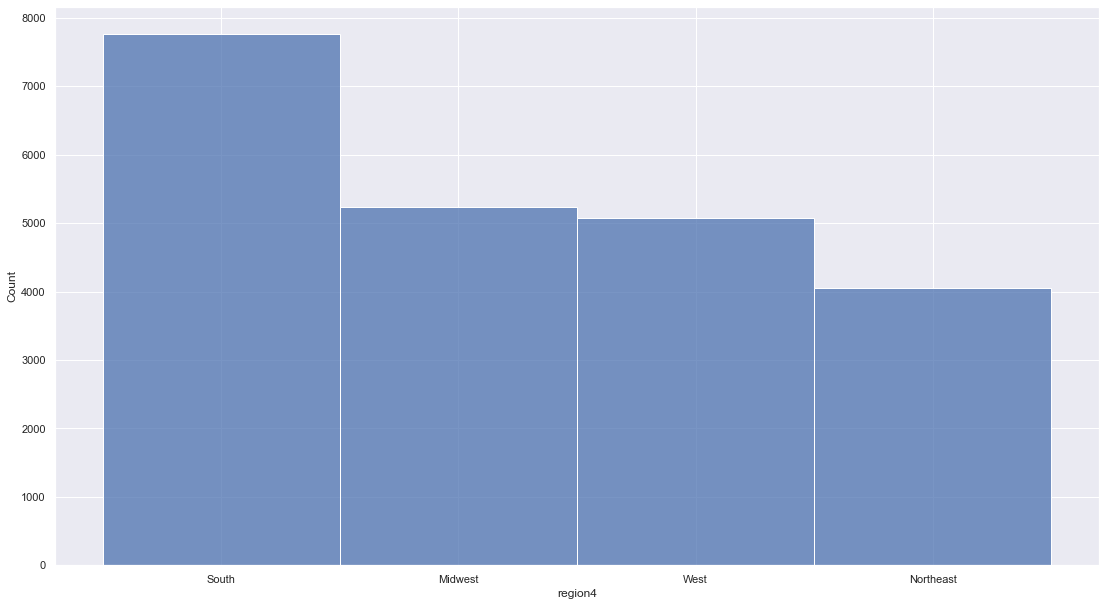

In [158]:
sns.histplot(data=df2, x = 'region4')

In [159]:
test_df = dummies.groupby('Yes').sum()

In [160]:
year_dum = pd.concat([df['year'], dummies], axis=1)

### Looking at responses for different categories for our features grouped by year to see changes over years

In [161]:
year_dum.groupby('year').sum()

generation_Baby Boomers (1946 - 1964)  \
year                                          
2008                                  830.0   
2010                                  779.0   
2011                                  756.0   
2012                                  841.0   
2013                                  780.0   
2014                                  934.0   
2015                                 1054.0   
2016                                 1020.0   
2017                                 1074.0   
2018                                  989.0   

      generation_Generation X (1965 - 1980)  \
year                                          
2008                                  538.0   
2010                                  685.0   
2011                                  492.0   
2012                                  465.0   
2013                                  395.0   
2014                                  536.0   
2015                                  574.0   
2016                                  516.0   
2017                                  573.0   
2018                                  553.0   

      generation_Greatest (Before 1928)  generation_Millennials (1981 - 1996)  \
year                                                                            
2008                               41.0                                 224.0   
2010                               17.0                                 254.0   
2011                               17.0                                 381.0   
2012                               20.0                                 372.0   
2013                               13.0                                 336.0   
2014                               17.0                                 455.0   
2015                                6.0                                 549.0   
2016                                8.0                                 496.0   
2017                                9.0                                 485.0   
2018                                5.0                                 486.0   

      generation_Silent (1928 - 1945)  generation_iGen‎/Gen Z (1997 - )  \
year                                                                      
2008                            499.0                               0.0   
2010                            253.0                               0.0   
2011                            298.0                               0.0   
2012                            335.0                               0.0   
2013                            312.0                               0.0   
2014                            320.0                               0.0   
2015                            354.0                              41.0   
2016                            318.0                              60.0   
2017                            317.0                             100.0   
2018                            261.0                              78.0   

      educ_10th grade  educ_11th grade  educ_12th grade no diploma  \
year                                                                 
2008             34.0             38.0                        53.0   
2010             50.0             49.0                        65.0   
2011             21.0             56.0                        47.0   
2012             28.0             40.0                        45.0   
2013             26.0             26.0                        40.0   
2014             22.0             47.0                        53.0   
2015             47.0             53.0                        60.0   
2016             32.0             46.0                        41.0   
2017             28.0             54.0                        45.0   
2018             28.0             28.0                        37.0   

      educ_1st, 2nd, 3rd, or 4th grade  ...  region9_South Atlantic  \
year                                    ...                           
2008               

### Creating a basic random forest model using only the features we have been working with

In [162]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=620,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, s.mean(), 2 * s.std()))

In [163]:
rf = RandomForestClassifier(n_jobs=-1,
                            n_estimators = 150,
#                             criterion='entropy',
#                             max_features='sqrt',
#                             min_weight_fraction_leaf=.01,
#                             class_weight='balanced_subsample',
#                             min_impurity_decrease=.02,
#                             oob_score=True,
                            min_samples_split=.1,
                            max_depth = 100,
                            random_state=620)


In [164]:
X = dummies.drop(['Yes', 'No', "Don't know"], axis=1)
y = dummies['Yes']


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 620)

In [165]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=0.1, n_estimators=150,
                       n_jobs=-1, random_state=620)

In [166]:
score(rf, 'RF', X_train, y_train)

RF Score: 0.72 +- 0.020


In [167]:
score(rf, 'RF', X_test, y_test)

RF Score: 0.72 +- 0.032


In [168]:
score(rf, 'RF', X, y)

RF Score: 0.72 +- 0.019


In [169]:
feat_imp = pd.DataFrame({'Variable':X.columns,
                            'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)


### Getting the feature importances for basic random forest model

In [170]:
feat_imp

Variable  Importance
62             party_w_leaners_Democrats    0.235335
66  party_x_ideo_Conservative Republican    0.143582
65           party_w_leaners_Republicans    0.104558
68         party_x_ideo_Liberal Democrat    0.087958
55            ideology_Very conservative    0.083034
..                                   ...         ...
29           income_$150,000 to $174,999    0.000027
26             income_$12,500 to $14,999    0.000026
42             income_$75,000 to $84,999    0.000016
85            region9_West-South Central    0.000013
10                 educ_5th or 6th grade    0.000000

[90 rows x 2 columns]

In [171]:
def stackplot(group, title, Xaxis):
    fig, ax = plt.subplots(figsize=(10, 10))

    df.groupby(group)['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'deepskyblue', 'palegreen'], 
              ax=ax)

    ax.set_title(title, 
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(Xaxis, weight='bold', labelpad=20)


    for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2
        ax.text(label_x, label_y, label_text, ha='center', va='center')
    ;


### Stacked bar plots normalized to see belief in climate change per feature

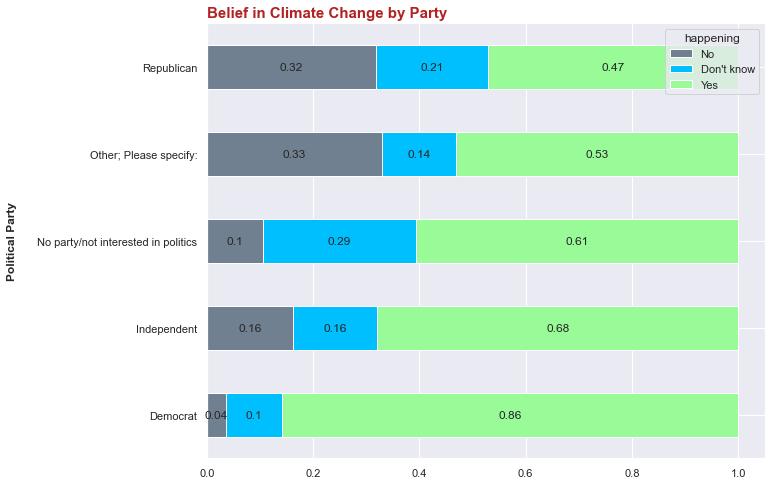

In [172]:
stackplot('party', 'Belief in Climate Change by Party', 'Political Party')

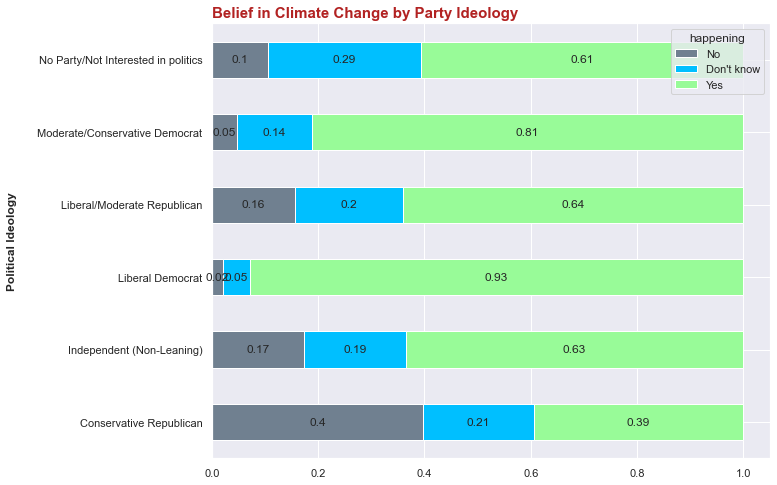

In [173]:
stackplot('party_x_ideo', 'Belief in Climate Change by Party Ideology', 'Political Ideology')

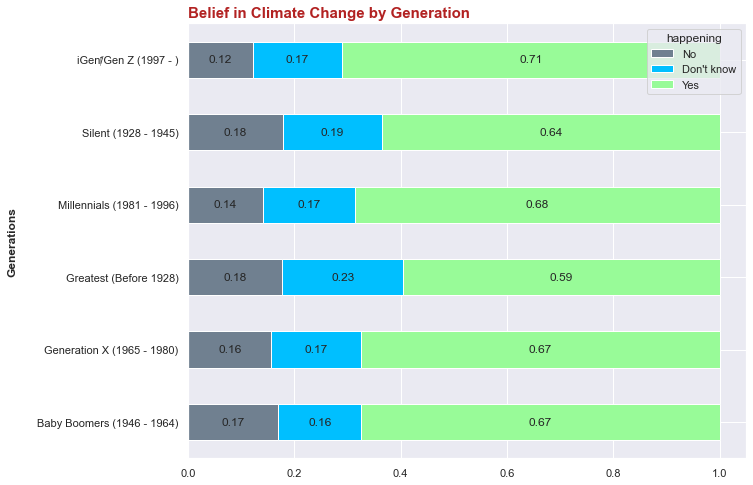

In [174]:
stackplot('generation', 'Belief in Climate Change by Generation', 'Generations')

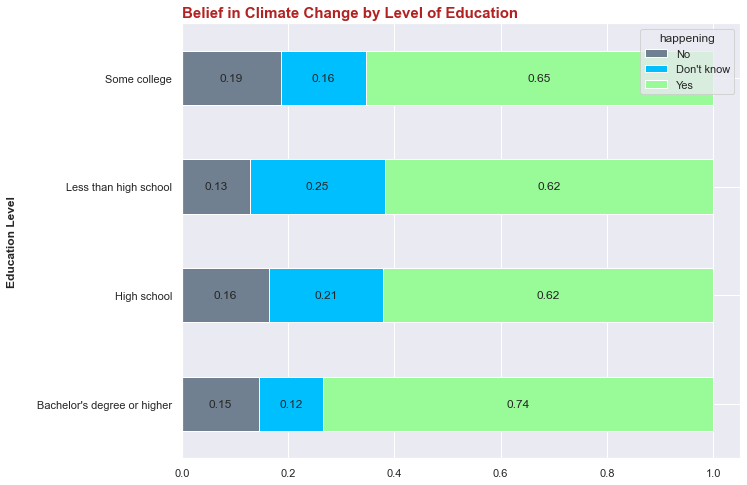

In [175]:
stackplot('educ_category', 'Belief in Climate Change by Level of Education', 'Education Level')

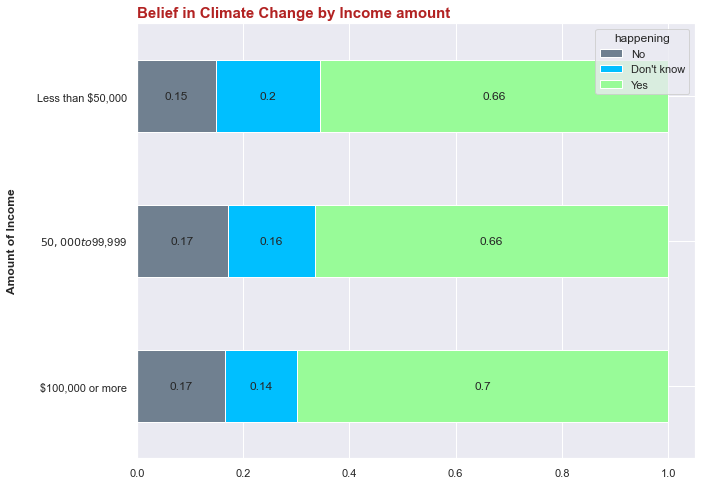

In [176]:
stackplot('income_category', 'Belief in Climate Change by Income amount', 'Amount of Income')

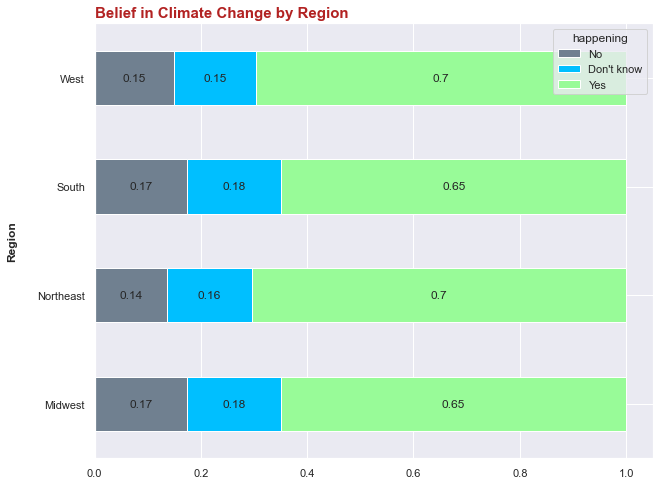

In [177]:
stackplot('region4', 'Belief in Climate Change by Region', 'Region')

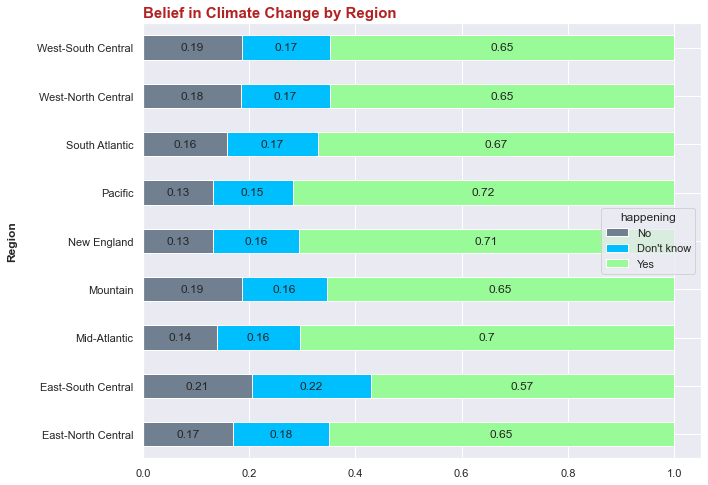

In [178]:
stackplot('region9', 'Belief in Climate Change by Region', 'Region')

### Recommendations for features to use in modeling

 * It appears that the group of people that feel most strongly about whether or not global warming is happening appears to be politically affiliated. We see the strongest change between majority 'yes' or majority 'no' to weather global warming is happening is seen with people affiliated with the Democratic and Republican party respectively as well as differing ideologies. 

* Education and income have been grouped in categories that are more normally distributed and will be useful for use in modeling.


* There is some variation in belief of global warming depending on the generation they were born in. It would be good to use this feature within our model.


* Region4 is an aggregated feature based on region9 locations. The more normalized region4 would be a good feature to use in the model as well

### Most interesting features:


- generation
- educ_category
- income_category
- party
- party_x_ideo
- region4

In [179]:
# ordinal_feat = df[['generation', 'educ_category', 'income_category']]
# nom_feat = df[['party', 'party_x_ideo', 'region4']]

In [180]:
# gen_lst = ['Greatest (Before 1928)','Silent (1928 - 1945)','Baby Boomers (1946 - 1964)',
#                                     'Generation X (1965 - 1980)','Millennials (1981 - 1996)',
#                                     'iGen\u200e/Gen Z (1997 - )']
# educ_lst = ['Less than high school','High school','Some college',
#                                      "Bachelor's degree or higher"]
# inc_lst = ['Less than $50,000', '$50,000 to $99,999', '$100,000 or more']


# ordinal = OrdinalEncoder(categories=[gen_lst, educ_lst, inc_lst],dtype=np.str_)



# ordinal_feat = ordinal.fit_transform(ordinal_feat)

In [181]:
df.drop(['educ', 'income', 'race', 'ideology', 'party_w_leaners',
         'registered_voter', 'region9'],
       axis = 1,
       inplace=True)

Drop the columns that are uninteresting.

## Saba

In [182]:
df.religion.value_counts(normalize=True)

Catholic                                                           0.231168
Protestant (e.g., Methodist, Lutheran, Presbyterian, Episcopal)    0.215702
None of the Above (Apr 2014 on); None (Nov 2008 - Dec 2013)        0.138828
Baptist - any denomination                                         0.137873
Other Christian                                                    0.114993
Pentecostal                                                        0.029203
Agnostic (Apr 2014 on)                                             0.028703
Atheist (Apr 2014 on)                                              0.027611
Jewish                                                             0.023654
Mormon                                                             0.017695
Other - non-Christian (Please specify)                             0.017604
Buddhist                                                           0.006550
Hindu                                                              0.004048
Eastern Orth

**These values represent the identified religions in the survey**

In [183]:
df[df['year']=='2014']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [184]:
df[df['year']=='2013']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [185]:
df[df['year']=='2015']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [186]:
df.groupby('religion')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T

happening                                                 No  Don't know  \
religion                                                                   
Agnostic (Apr 2014 on)                              0.071315    0.074485   
Atheist (Apr 2014 on)                               0.065898    0.060956   
Baptist - any denomination                          0.206862    0.205543   
Buddhist                                            0.097222    0.090278   
Catholic                                            0.141677    0.158599   
Eastern Orthodox                                    0.150685    0.123288   
Hindu                                               0.044944    0.112360   
Jewish                                              0.126923    0.096154   
Mormon                                              0.275064    0.187661   
Muslim                                              0.089552    0.134328   
None of the Above (Apr 2014 on); None (Nov 2008...  0.107471    0.175623   
Other - non-Christian (Please specify)              0.105943    0.124031   
Other Christian                                     0.210443    0.193829   
Pentecostal                                         0.250779    0.210280   
Protestant (e.g., Methodist, Lutheran, Presbyte...  0.179882    0.170181   

happening                                                Yes  
religion                                                      
Agnostic (Apr 2014 on)                              0.854200  
Atheist (Apr 2014 on)                               0.873147  
Baptist - any denomination                          0.587595  
Buddhist                                            0.812500  
Catholic                                            0.699725  
Eastern Orthodox                                    0.726027  
Hindu                                               0.842697  
Jewish                                              0.776923  
Mormon                                              0.537275  
Muslim                                              0.776119  
None of the Above (Apr 2014 on); None (Nov 2008...  0.716907  
Other - non-Christian (Please specify)              0.770026  
Other Christian                                     0.595728  
Pentecostal                                         0.538941  
Protestant (e.g., Methodist, Lutheran, Presbyte...  0.649937

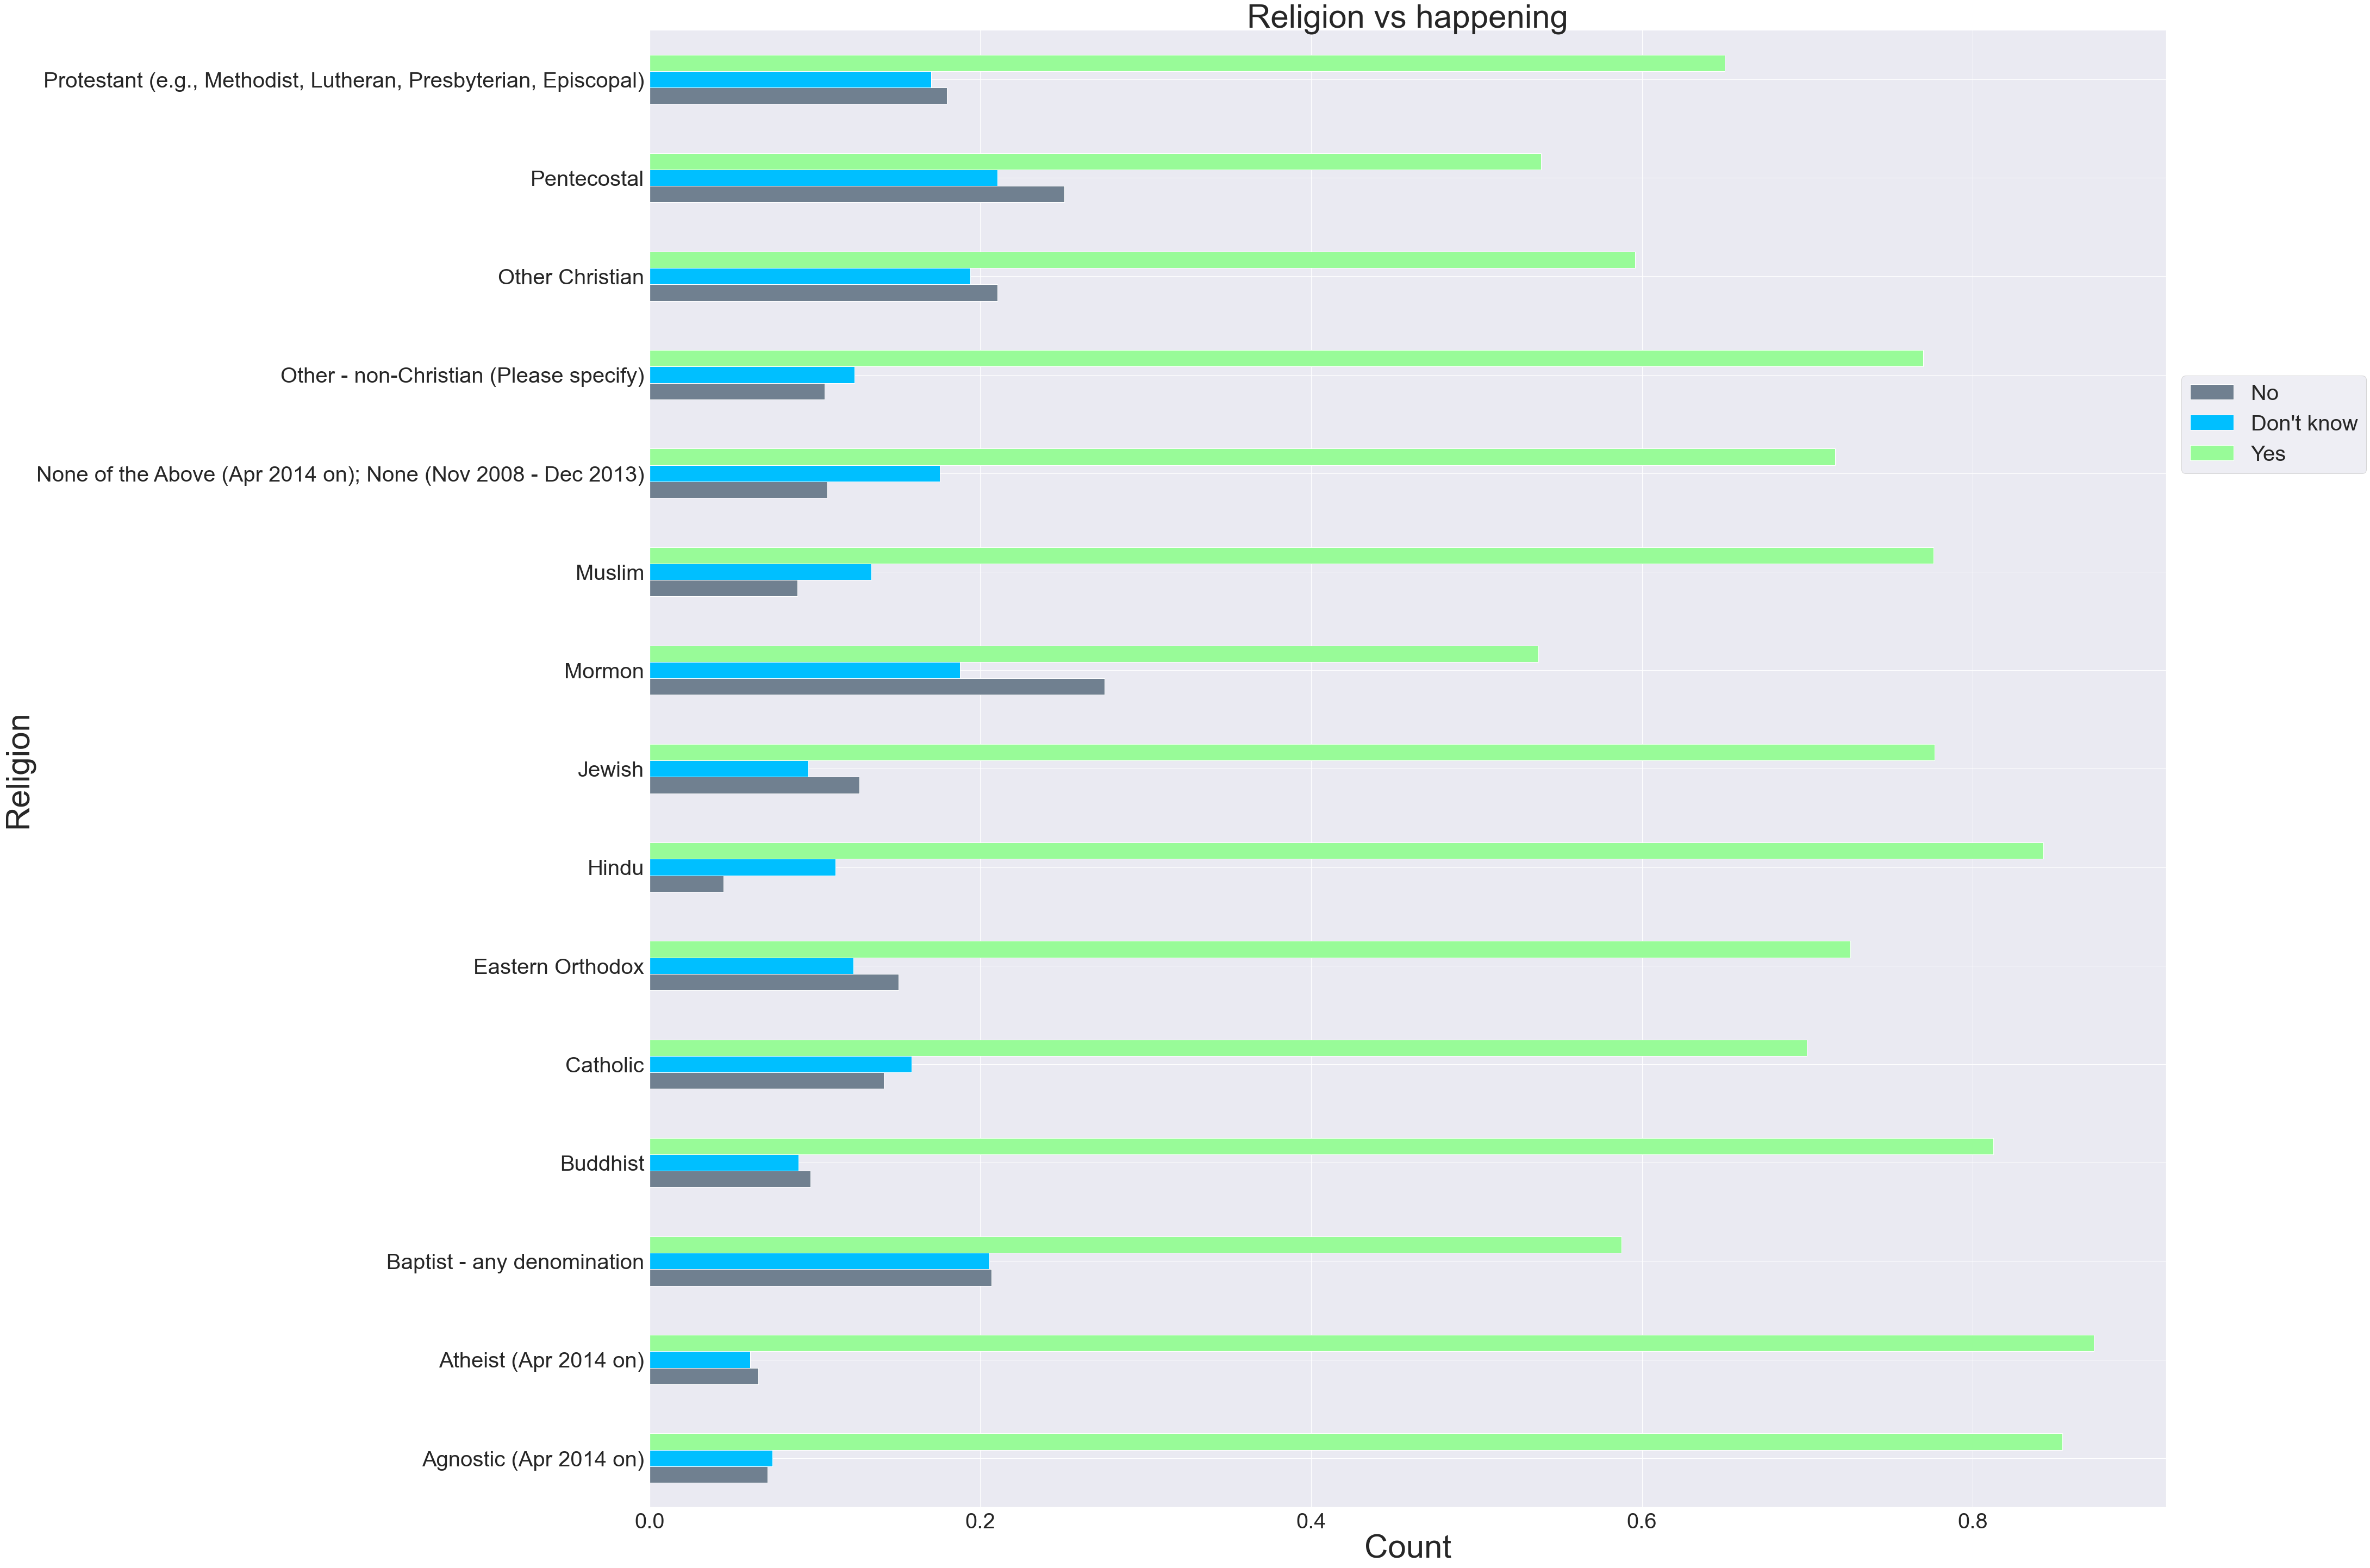

In [187]:
ax = df.groupby('religion')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Religion',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Religion vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

- **This graph represents the distribution of`happening` across various religions.**
- **Largely people across all religions accept that climate change is happening. Baptist seem to have a large proportion of people not accepting climate change**

In [188]:
list(df.religion_other_nonchristian.unique())

[nan,
 'Unitarian',
 "Spiritual but don't attend church",
 'Spiritual',
 'native american',
 'Unitarian Universalist',
 'Deist',
 'Pagan',
 'God Loving',
 'Wiccan',
 'nature-based',
 'baptist',
 'Eclectic Spiritualist',
 'Spiritual not religious',
 'Just',
 'Shaman',
 'Unitarian-Universalist',
 'Prefer not say',
 'Jw',
 '"Believer"',
 'Pagan/Shamanic Witch',
 'Spiritualist',
 'Church of Christ',
 'prefer not to state',
 'NO RELIGION',
 'none of your bee wax',
 'evangelical',
 'female ancestor worship',
 'Non denominational',
 'unitarian  SRF',
 'born again',
 'apostolic',
 'unitarian universalist',
 'Non-denominationa',
 'Jesus',
 'SEVENTH DAY  ADVENTIST',
 'Sikh',
 'Anabaptist',
 'spiritual',
 'Human',
 'science',
 'Dystheist',
 'Taoist',
 'no denomanation',
 'G',
 'Agnostic Atheist',
 'Native American truths',
 "I'm a Christian",
 'Heathen',
 'Love and Compassion',
 'Christian',
 'Quaker',
 'Jehovah’s Witness',
 'pagan',
 'Unitarianism',
 'NOYB',
 'LOVEBIBLELIGHTS',
 'Nondenomination

**This is user filled column so a lot of typos are being seen, since we have religion and attendance data we might drop this column**

In [189]:
df.evangelical.value_counts(normalize=True)

No            0.664907
Yes           0.251467
Don't Know    0.083625
Name: evangelical, dtype: float64

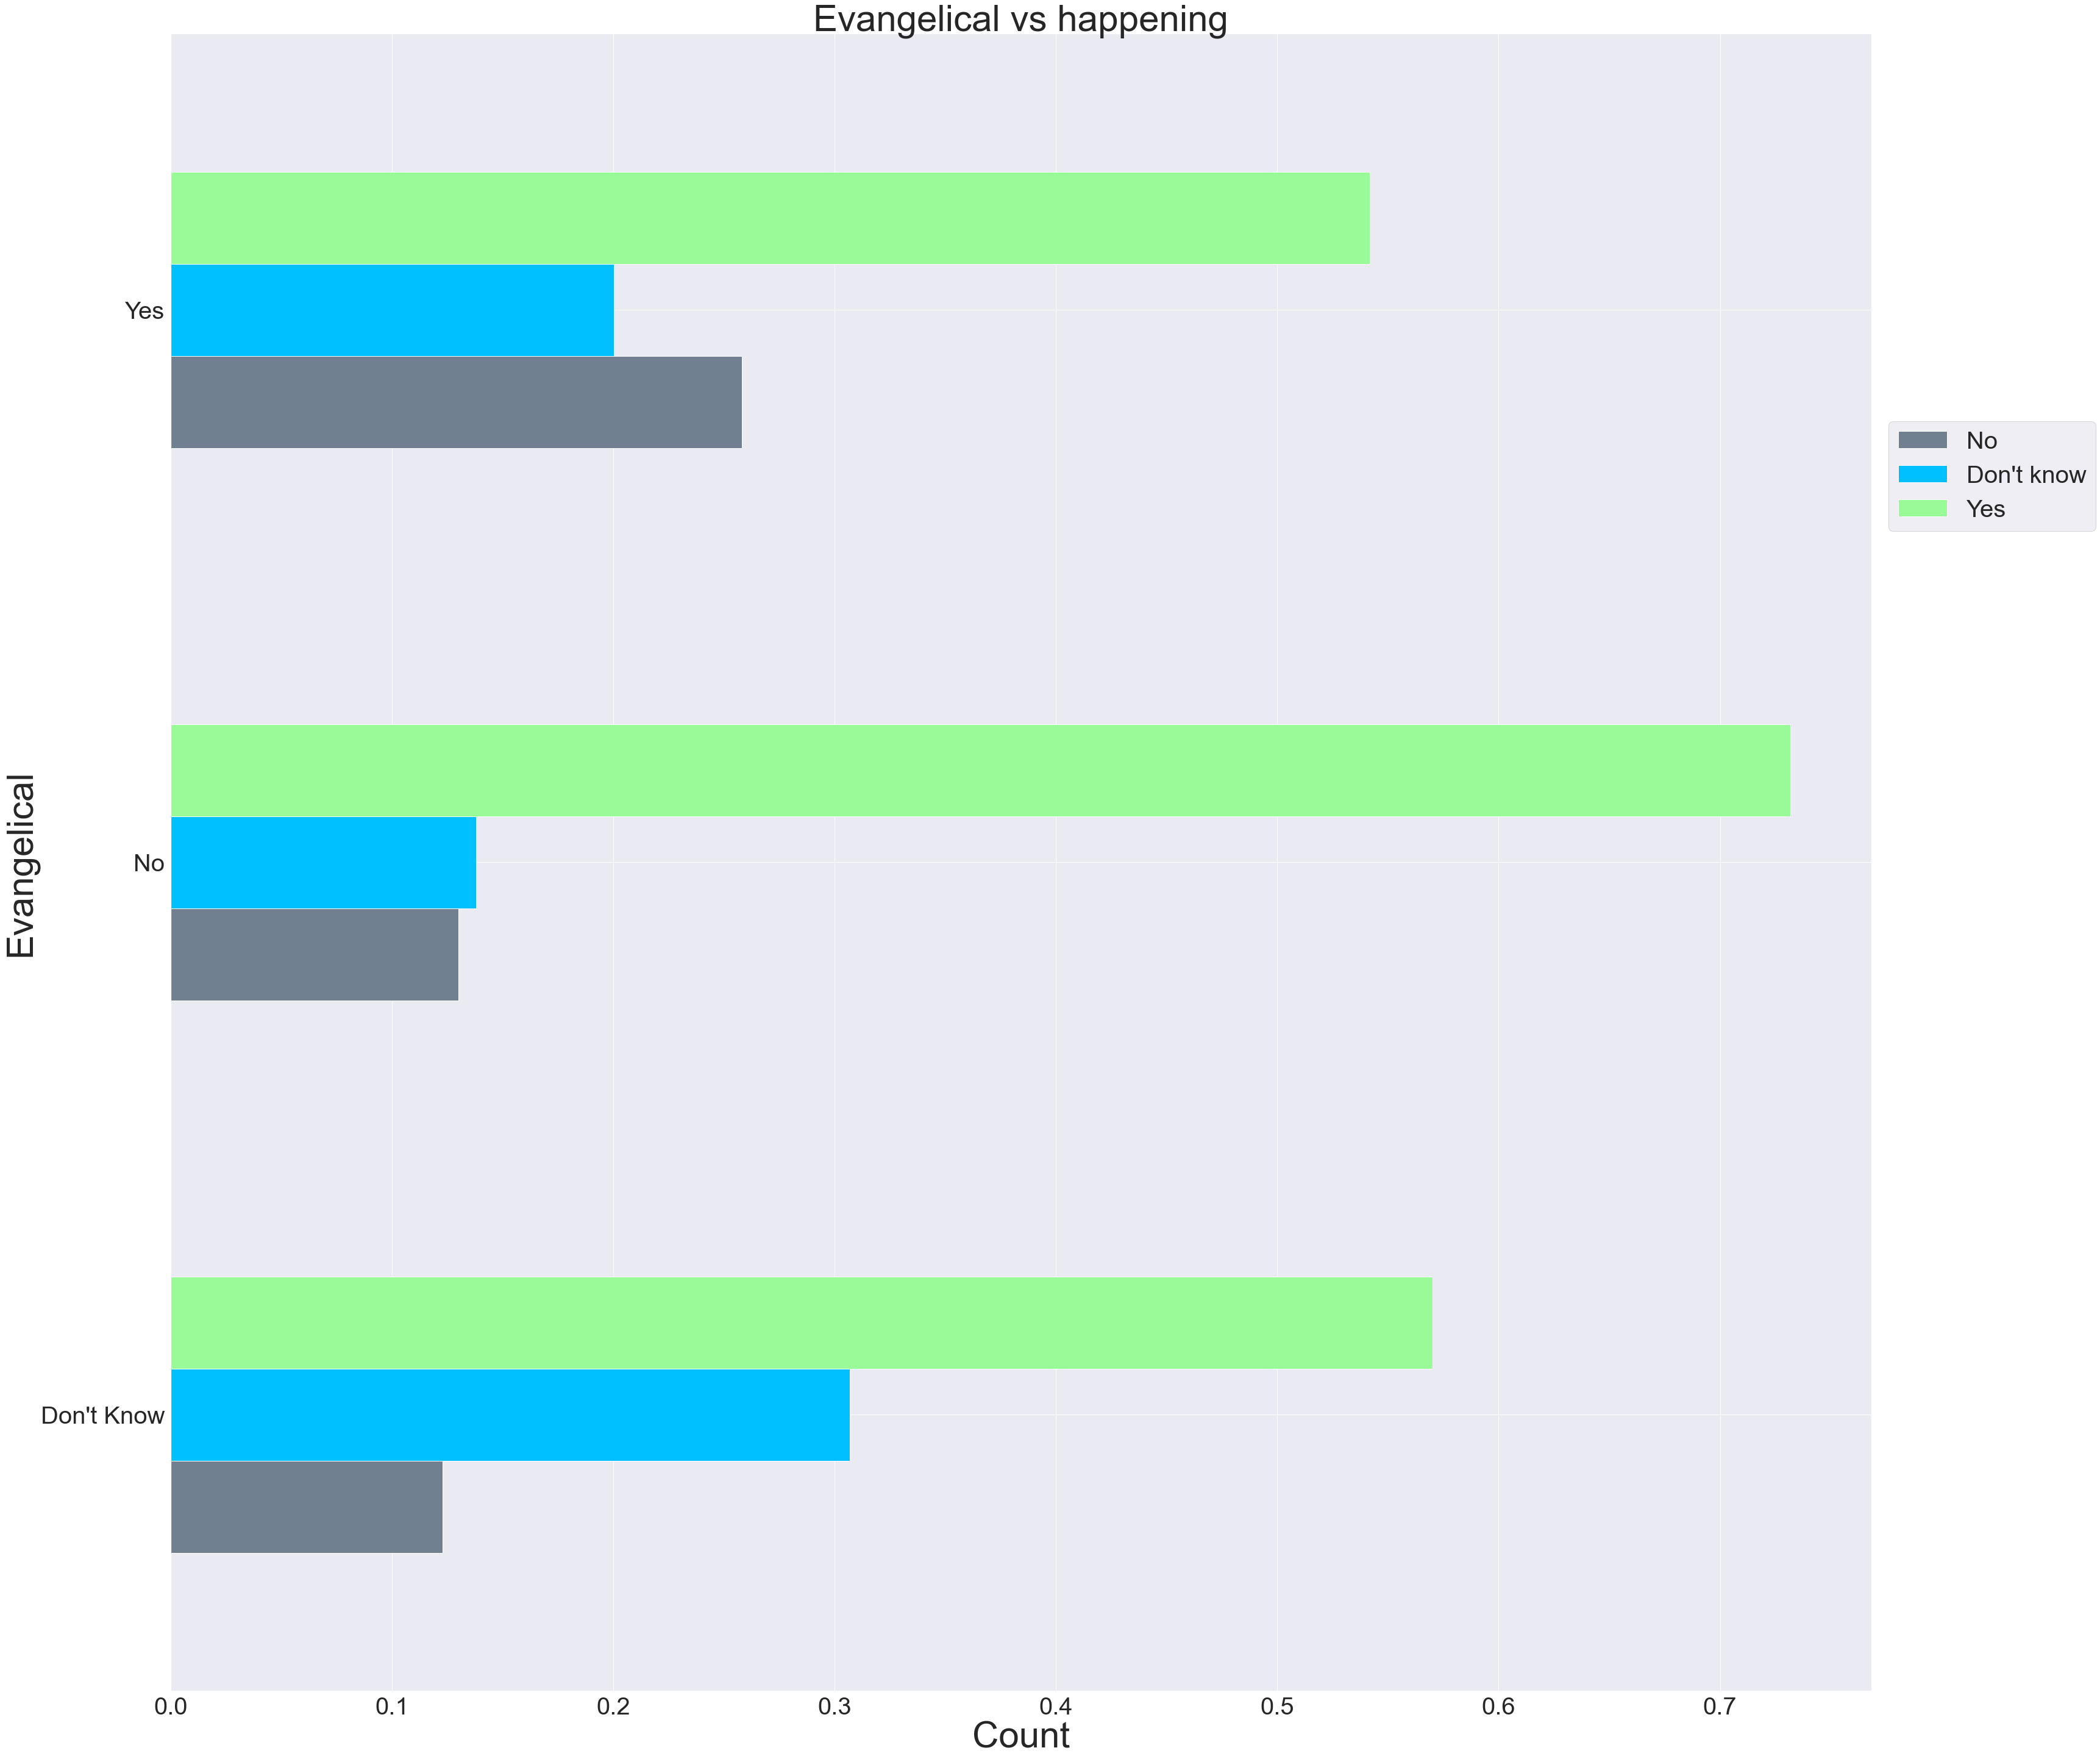

In [190]:
ax = df.groupby('evangelical')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Evangelical',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Evangelical vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**People who said Yes to being evangelical or refused to answer whether they are evangelical have a higher proportion of people not accepting climate change**

In [191]:
df.service_attendance.value_counts(normalize=True)

Never                    0.251800
Once a week              0.218314
Once a year or less      0.180137
A few times a year       0.167654
More than once a week    0.103007
Once or twice a month    0.079089
Name: service_attendance, dtype: float64

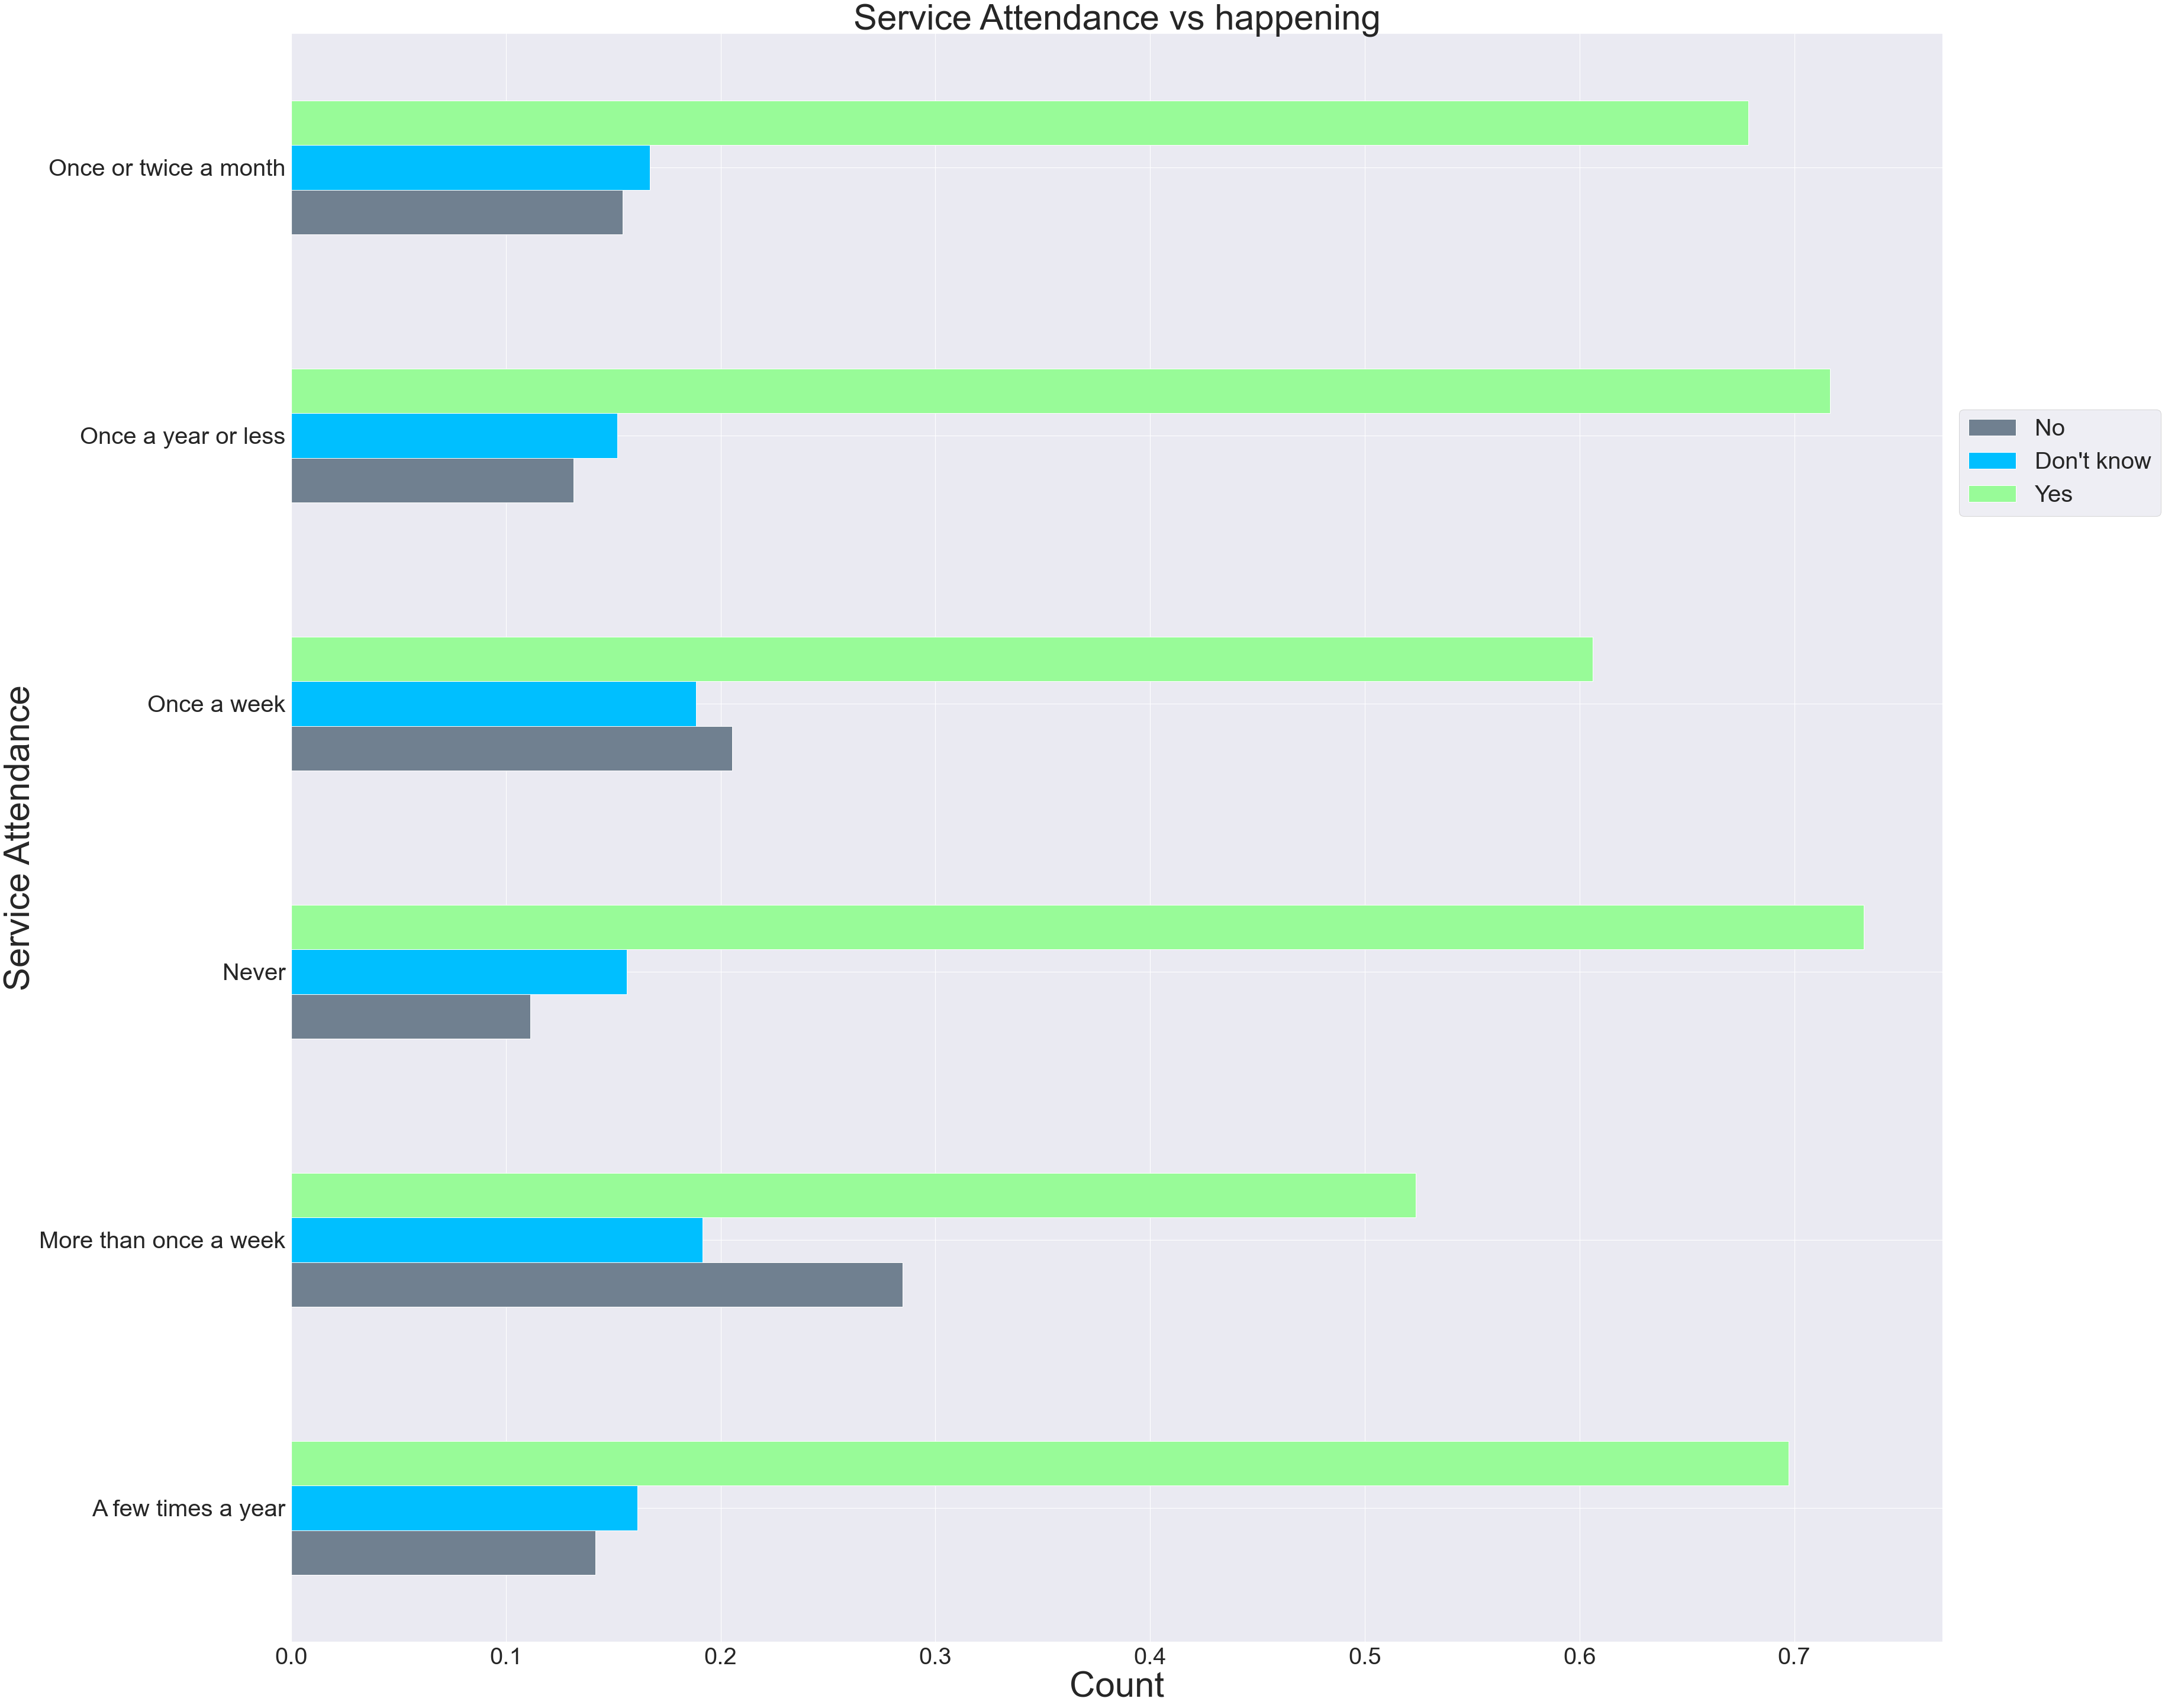

In [192]:
ax = df.groupby('service_attendance')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Service Attendance',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Service Attendance vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**People who go for service attendance for more than once a week and once a week have a higher proportion of people refusing to believe in climate change compared to all people in that particular label of service attendance**

In [193]:
#mapping values to the ordinal variable representing religiosity
service_attendance_di = {'Never': 1,
                   'Once a week': 5,
                   'Once a year or less': 2,
                   'A few times a year': 3,
                   'More than once a week':6,
                   'Once or twice a month':4,
                   np.nan:-1,
                        }
df.service_attendance= df['service_attendance'].map(lambda x: service_attendance_di[x])


In [194]:
df.marit_status.value_counts(normalize=True)

Married                0.581936
Never married          0.182587
Divorced               0.107726
Living with partner    0.060802
Widowed                0.050405
Separated              0.016545
Name: marit_status, dtype: float64

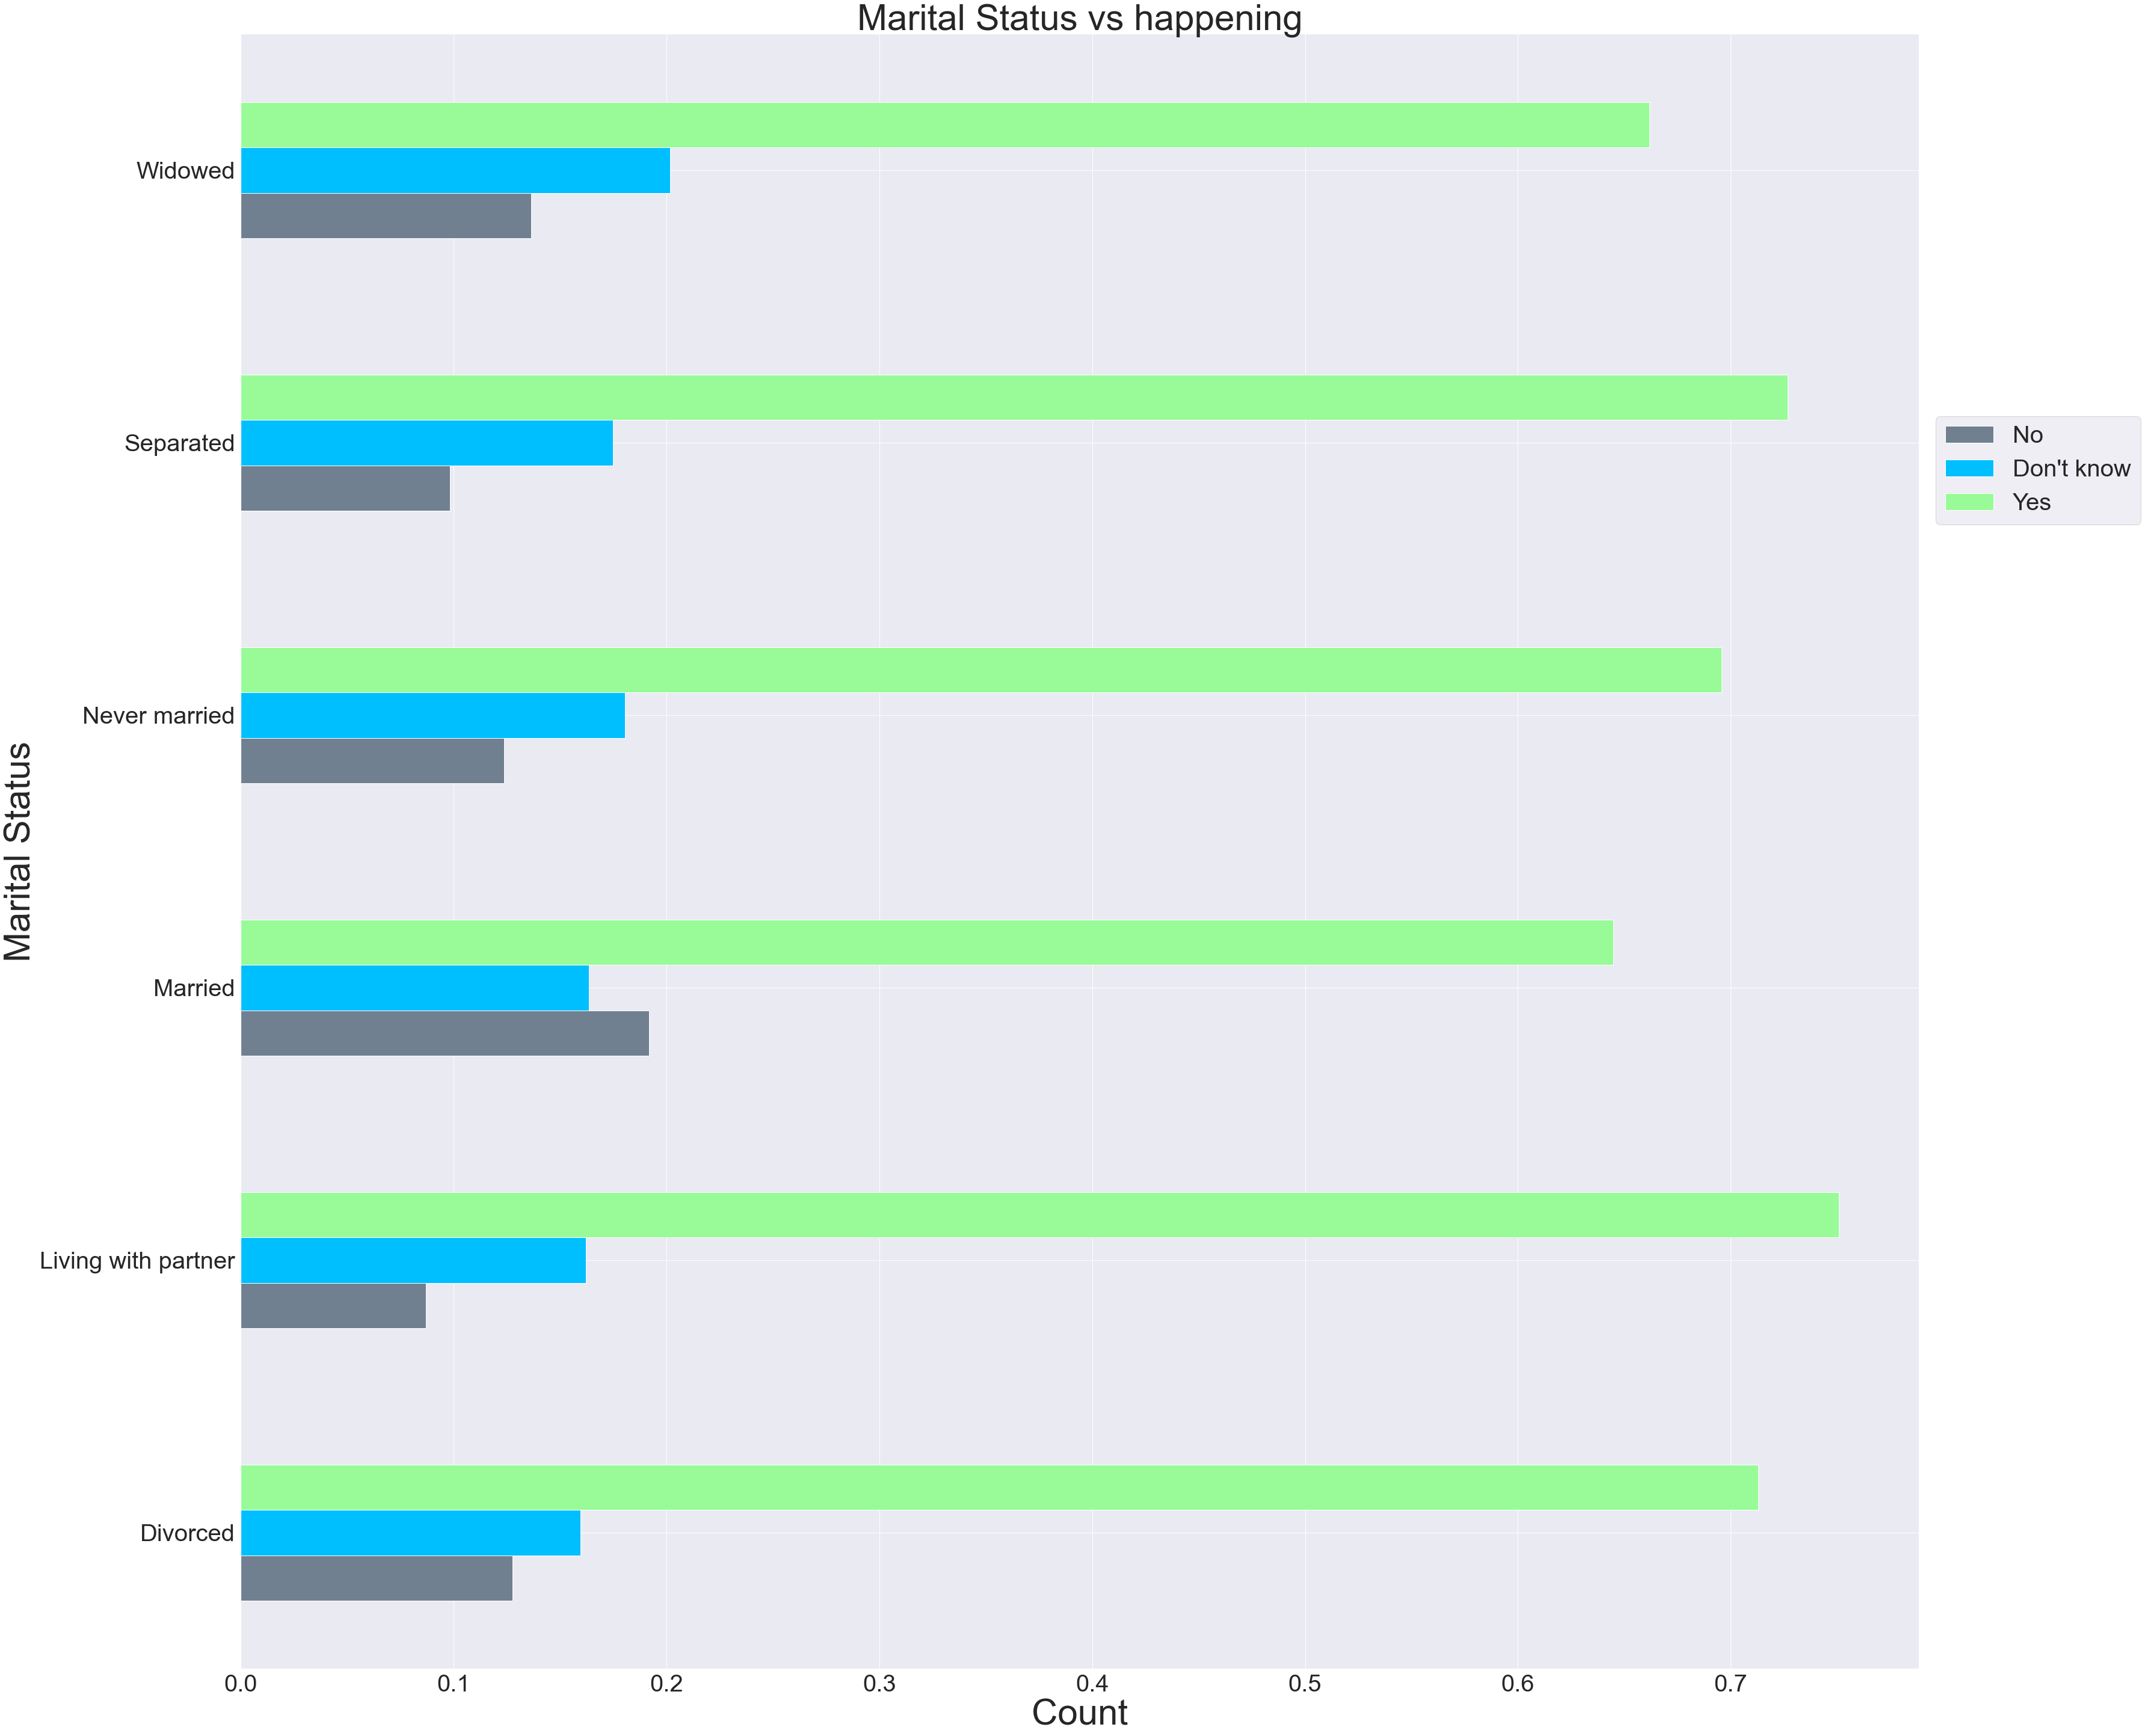

In [195]:
ax = df.groupby('marit_status')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Marital Status',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Marital Status vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` across various marital status.**

In [196]:
df.employment.value_counts(normalize=True)

Working - as a paid employee                    0.494372
Not working - retired                           0.227838
Working - self-employed                         0.075856
Not working - other                             0.071606
Not working - disabled                          0.065142
Not working - looking for work                  0.057321
Not working - on temporary layoff from a job    0.007866
Name: employment, dtype: float64

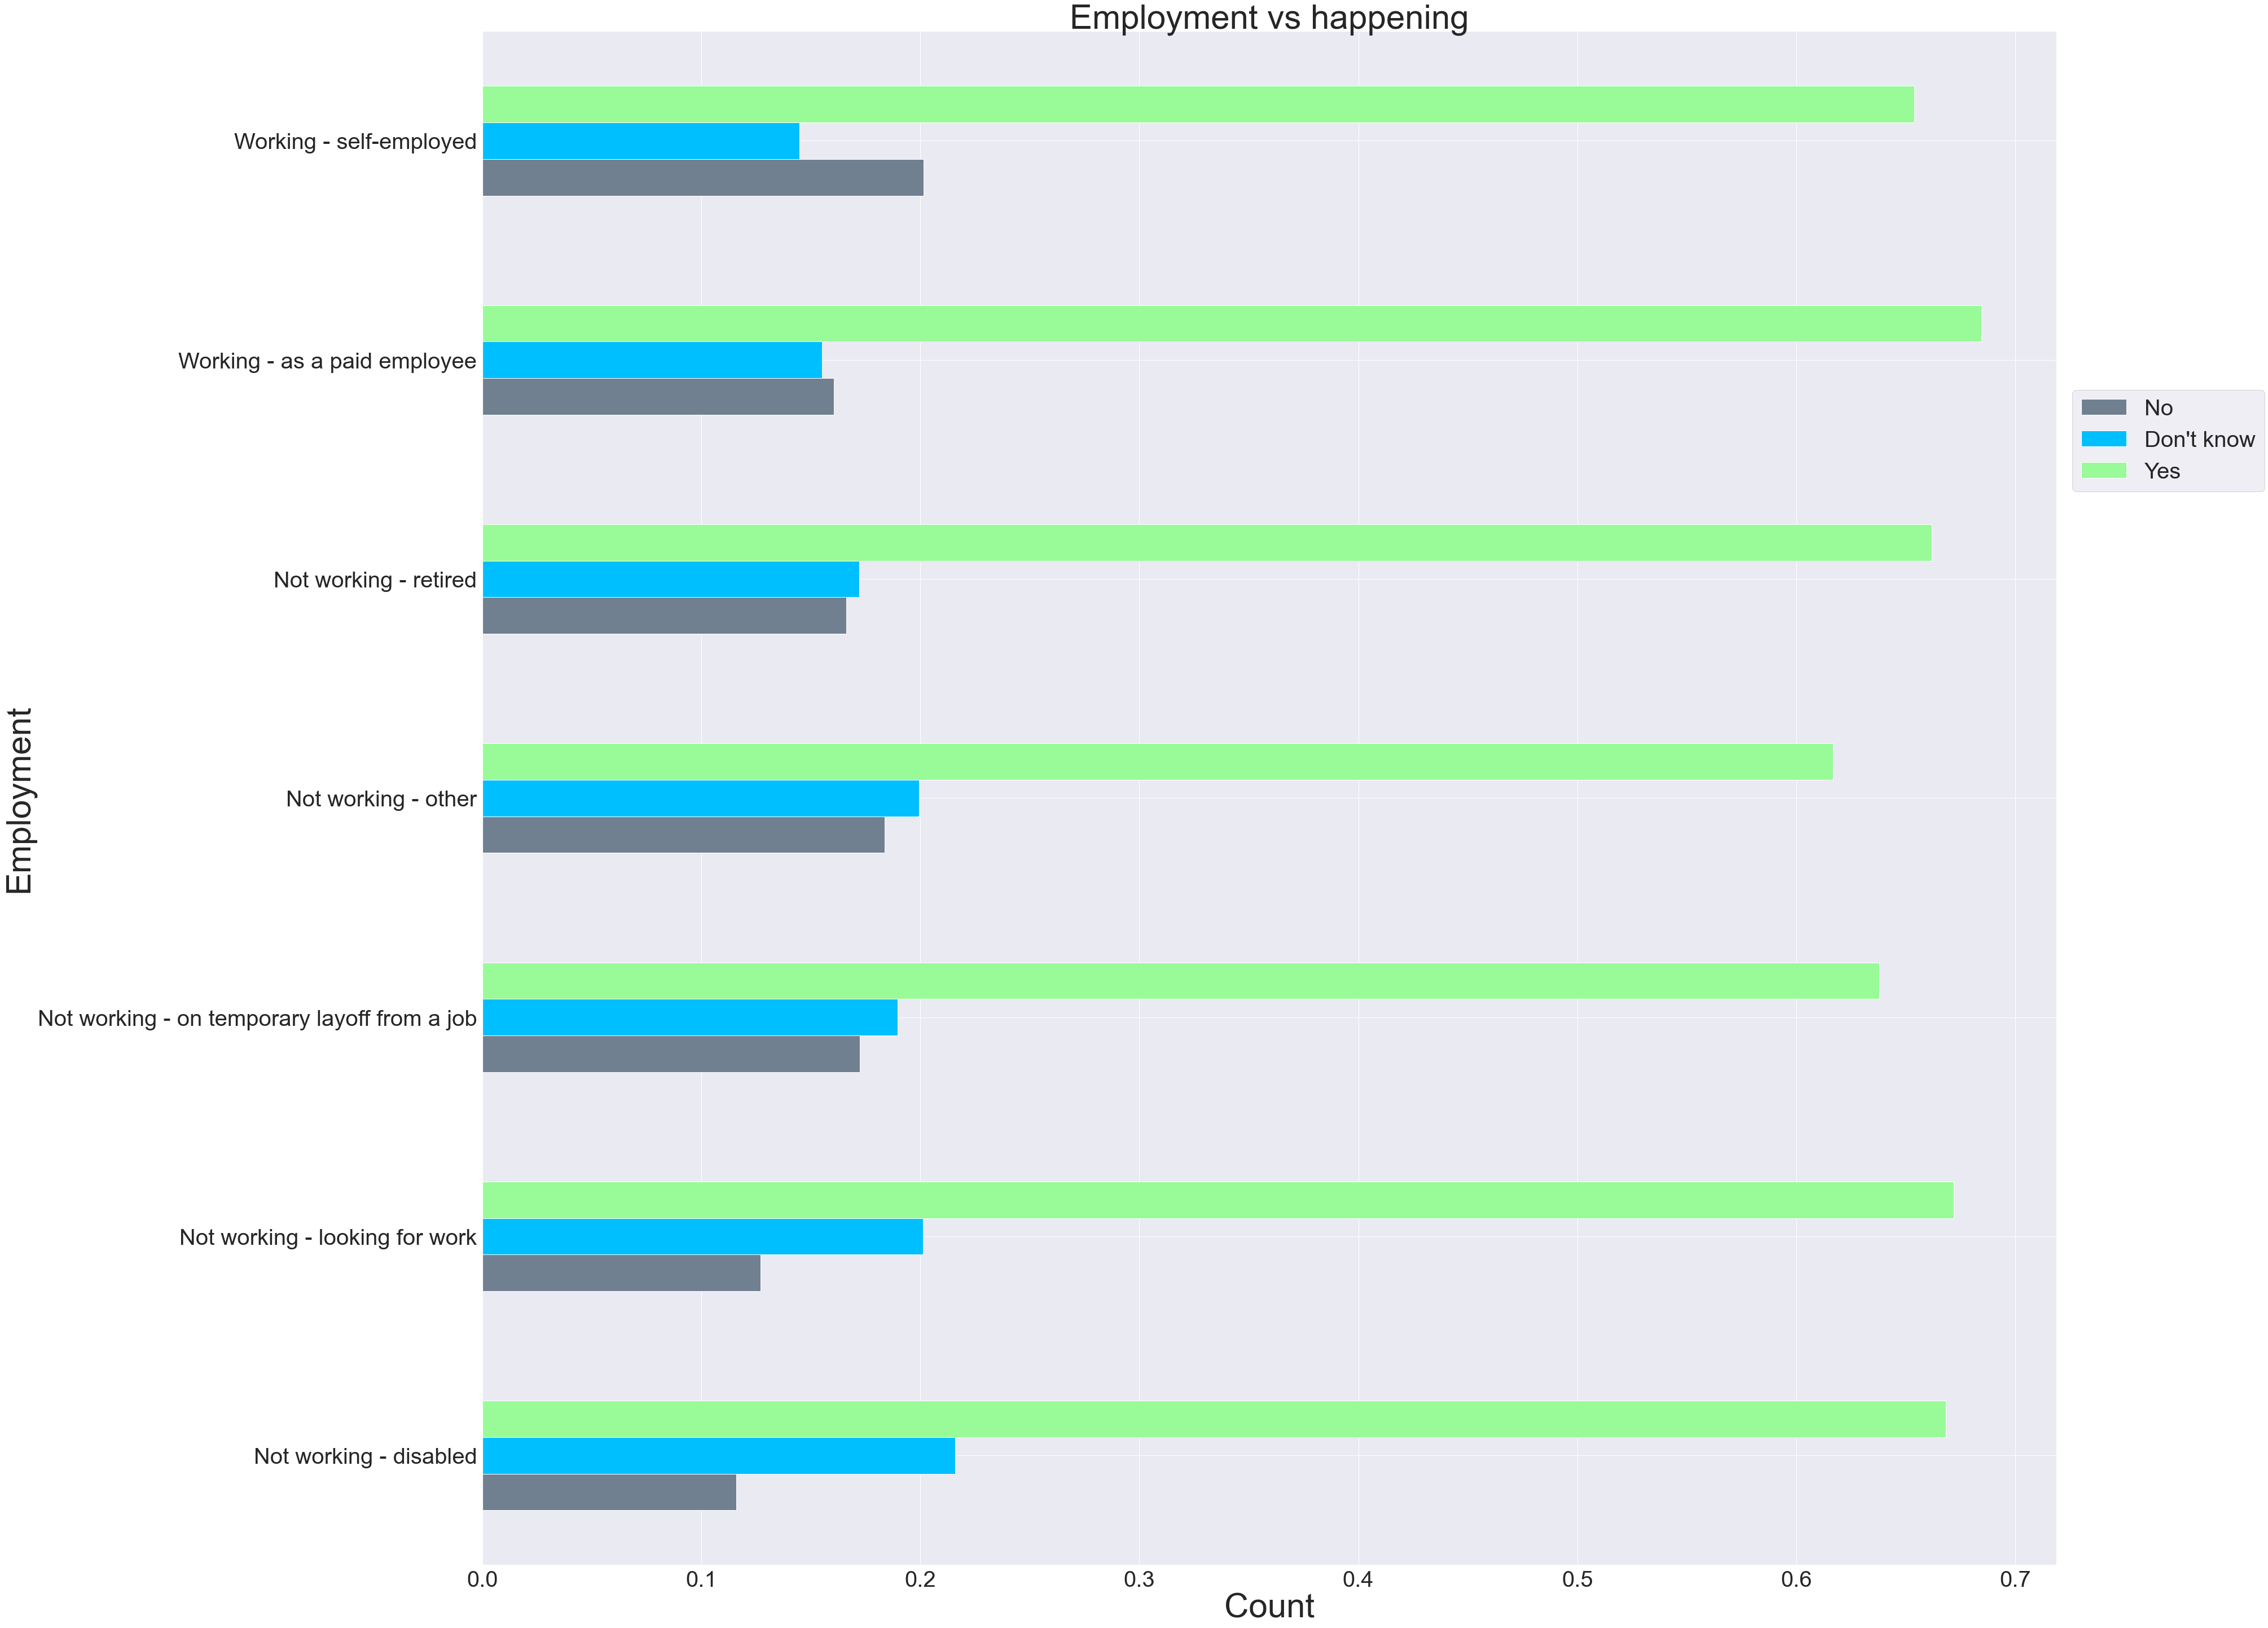

In [197]:
ax = df.groupby('employment')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Employment',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Employment vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` across various employments.Seems like Retired people have a higher proportion of people not accepting climate change**

In [198]:
df.house_head.value_counts(normalize=True)

Head of household        0.827765
Not head of household    0.172235
Name: house_head, dtype: float64

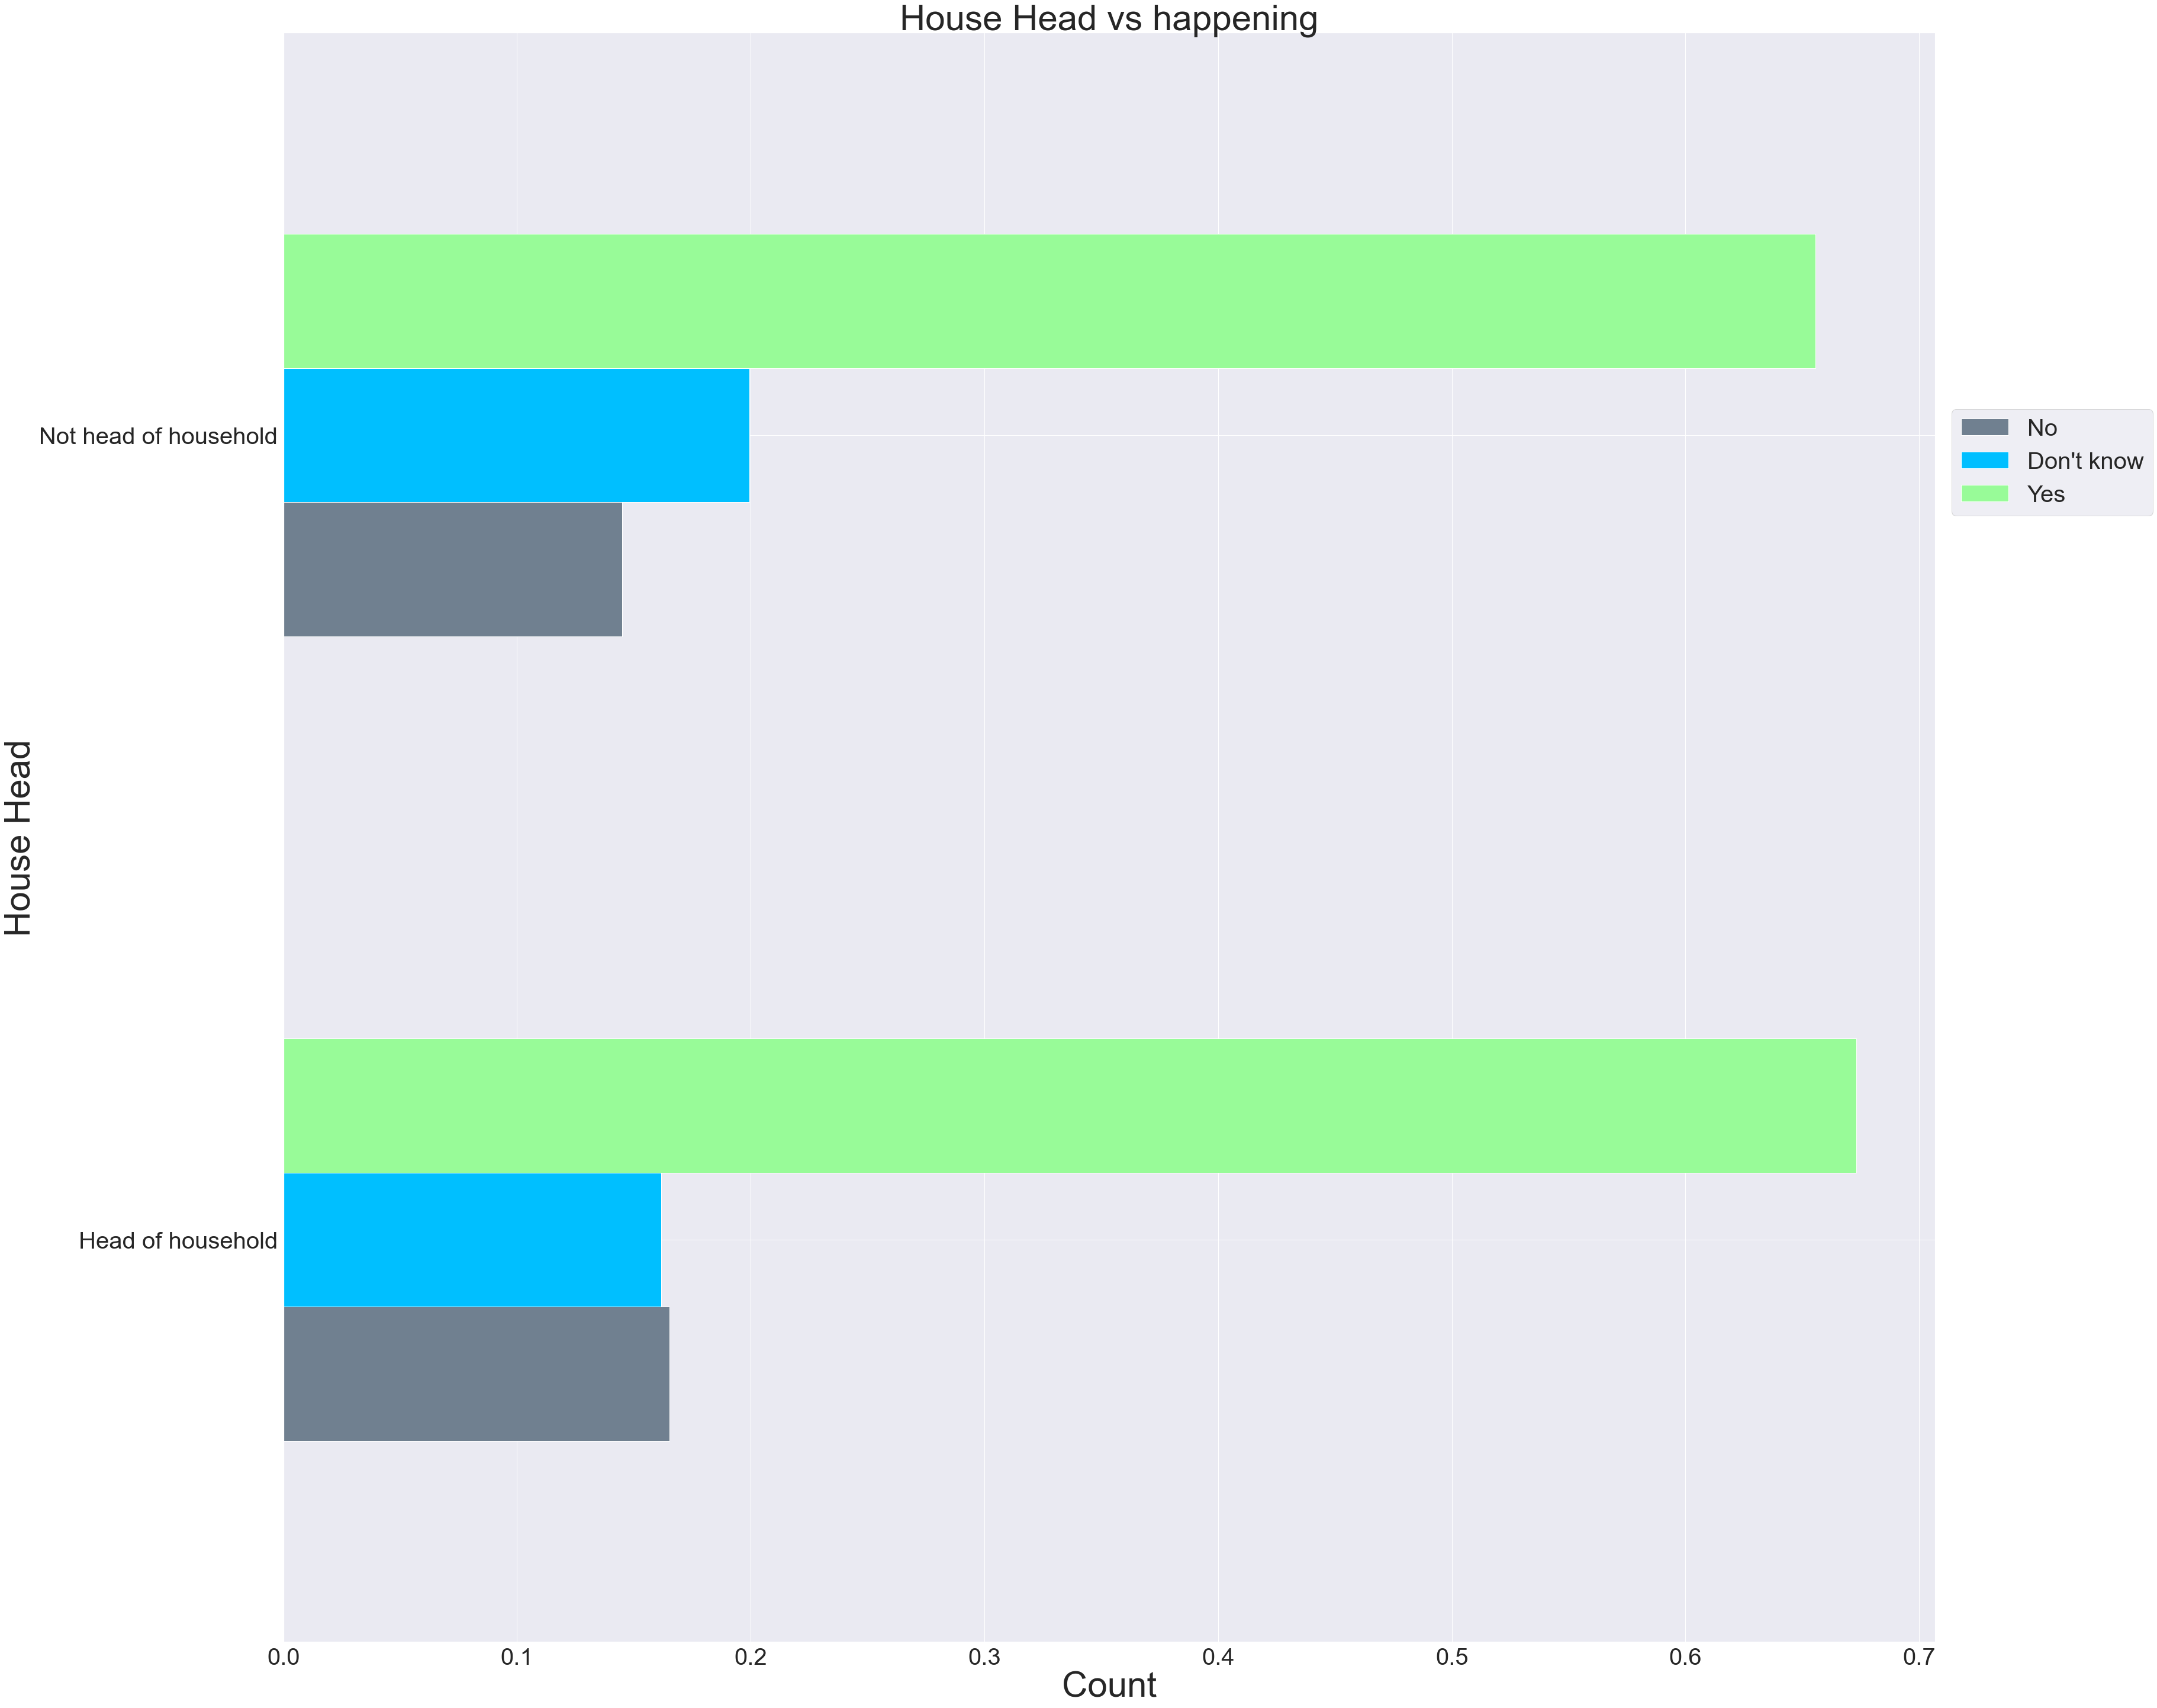

In [199]:
ax = df.groupby('house_head')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Head',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Head vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` vs house heads status. Majority of those surveyed seem to own a household**

In [200]:
df.house_size.value_counts(normalize=True)

2.0     0.390534
1.0     0.190814
3.0     0.165725
4.0     0.141856
5.0     0.066498
6.0     0.026084
7.0     0.009584
8.0     0.004701
9.0     0.001808
10.0    0.001627
12.0    0.000633
15.0    0.000090
11.0    0.000045
Name: house_size, dtype: float64

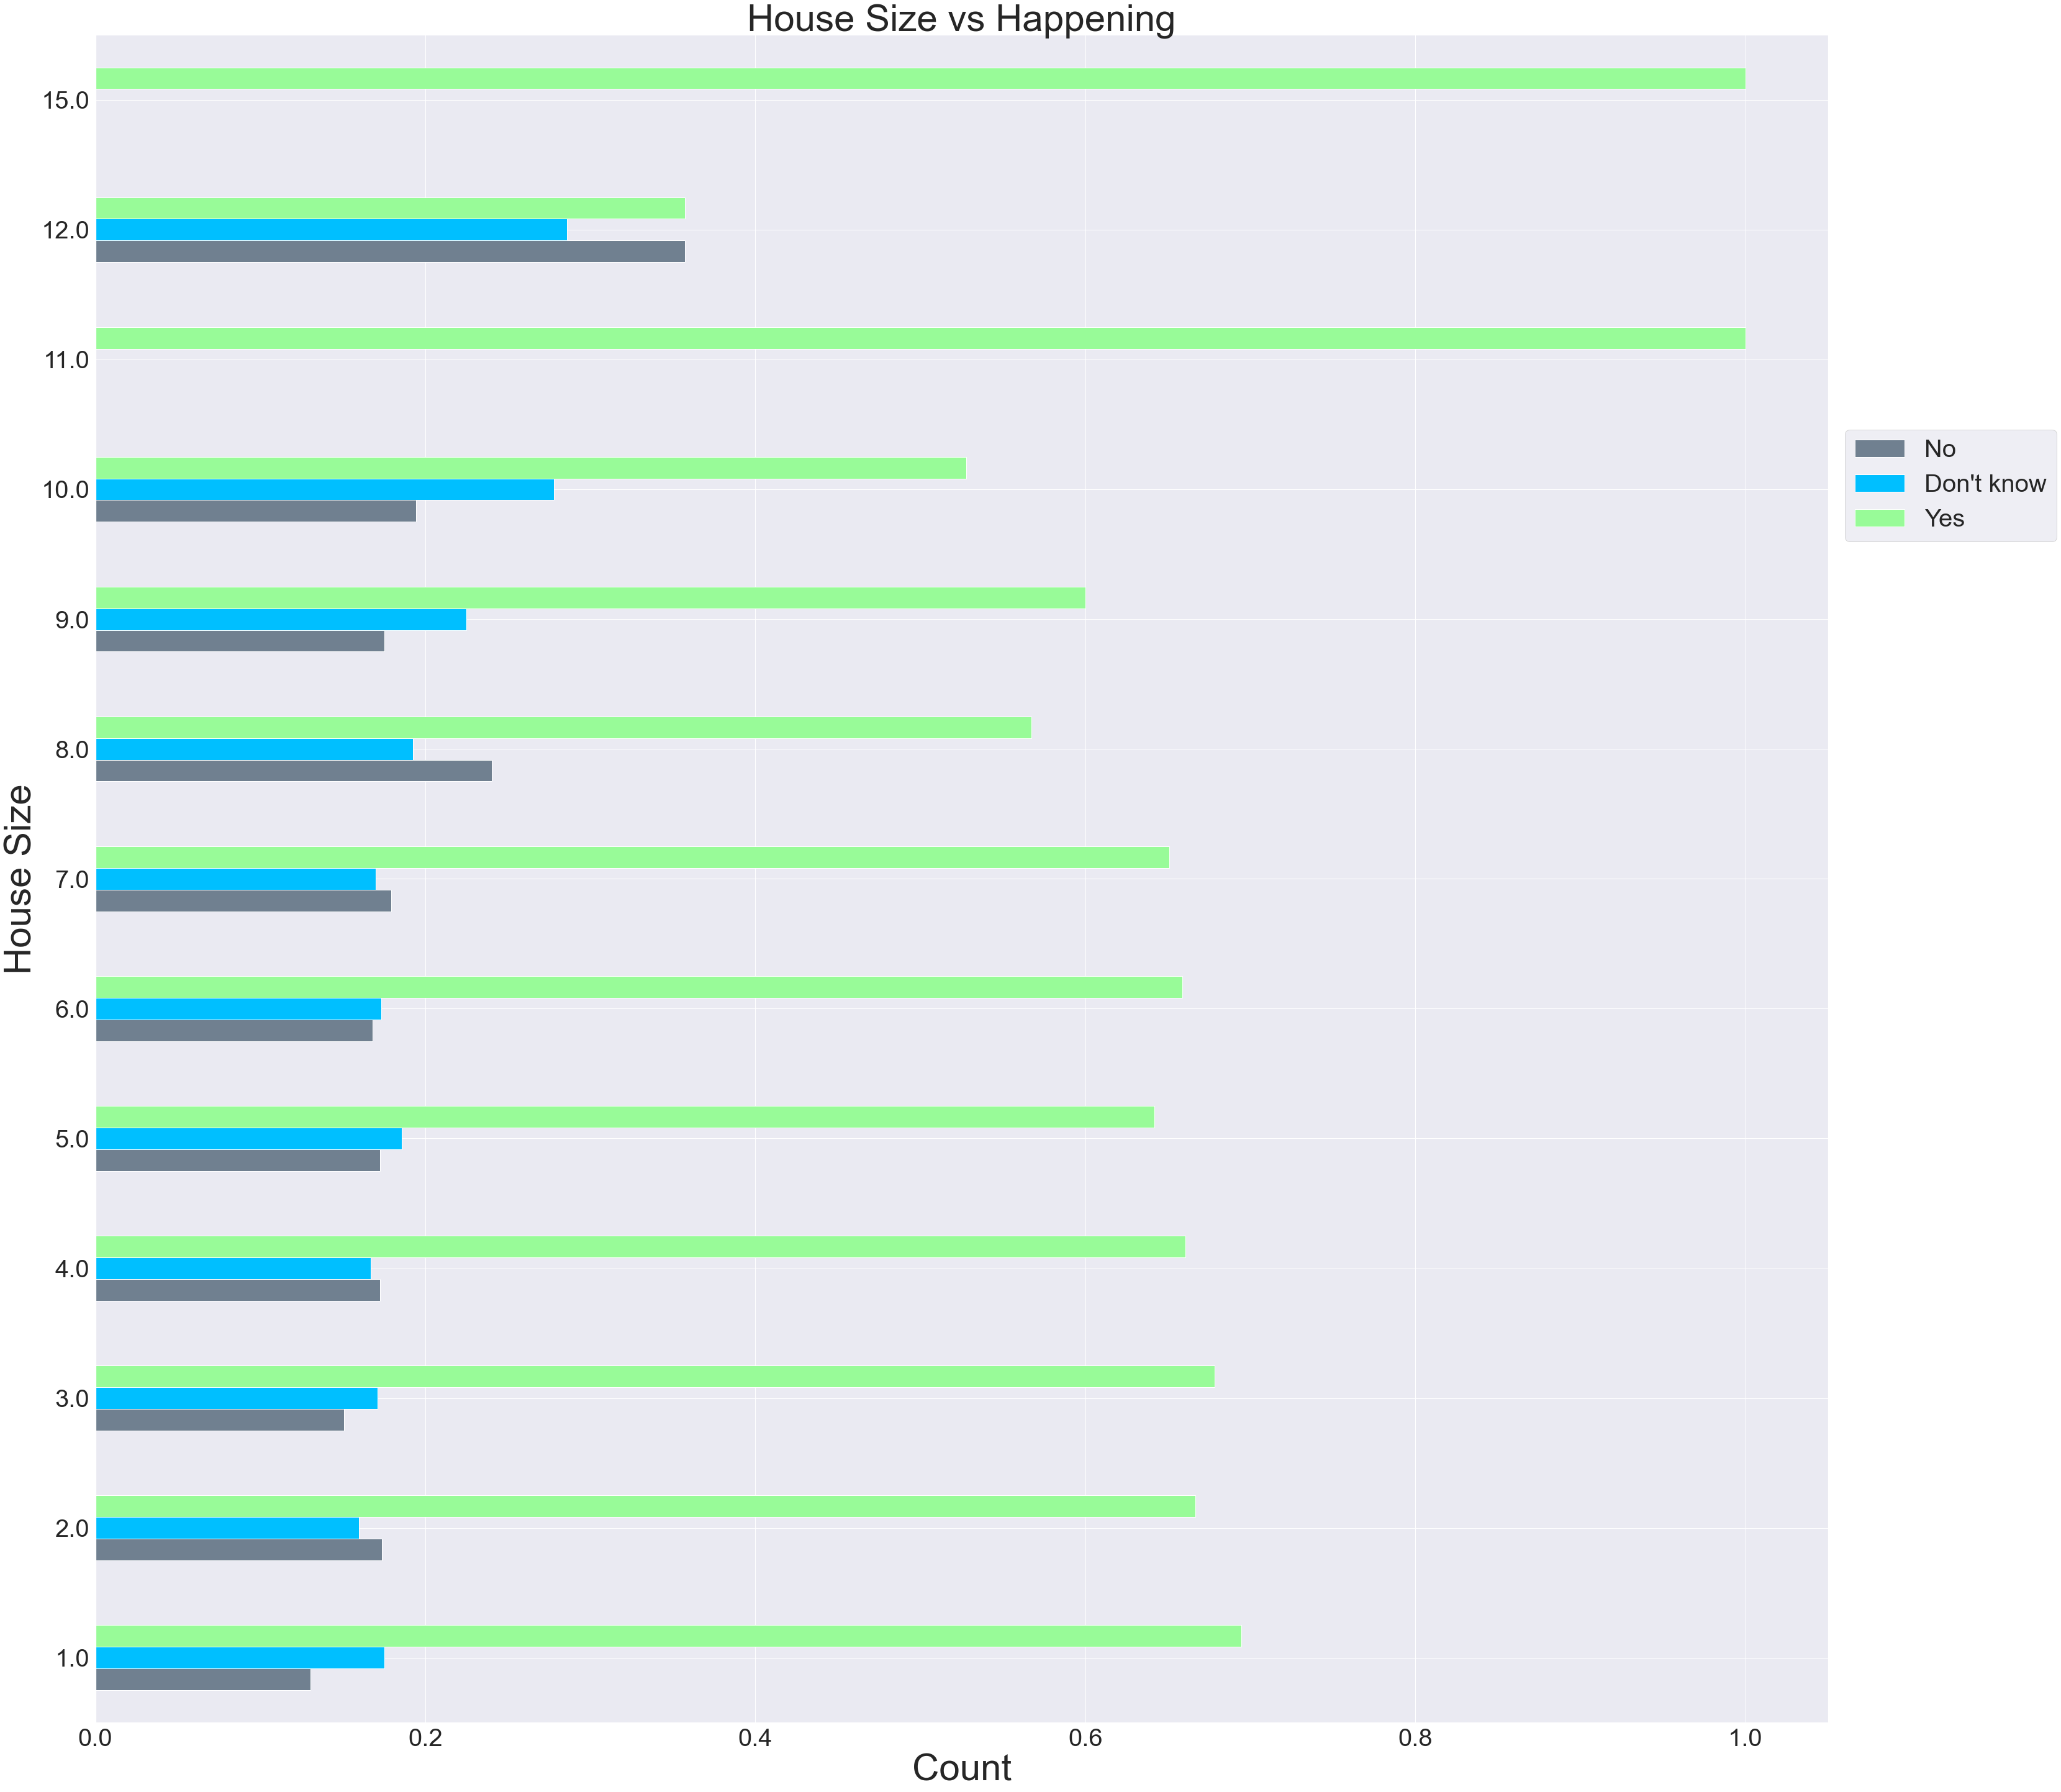

In [201]:
ax = df.groupby('house_size')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Size',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Size vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` vs house size.** 

In [202]:
df.house_ages0to1.value_counts(normalize=True)

0.0    0.961575
1.0    0.035713
2.0    0.002125
3.0    0.000226
4.0    0.000226
6.0    0.000090
7.0    0.000045
Name: house_ages0to1, dtype: float64

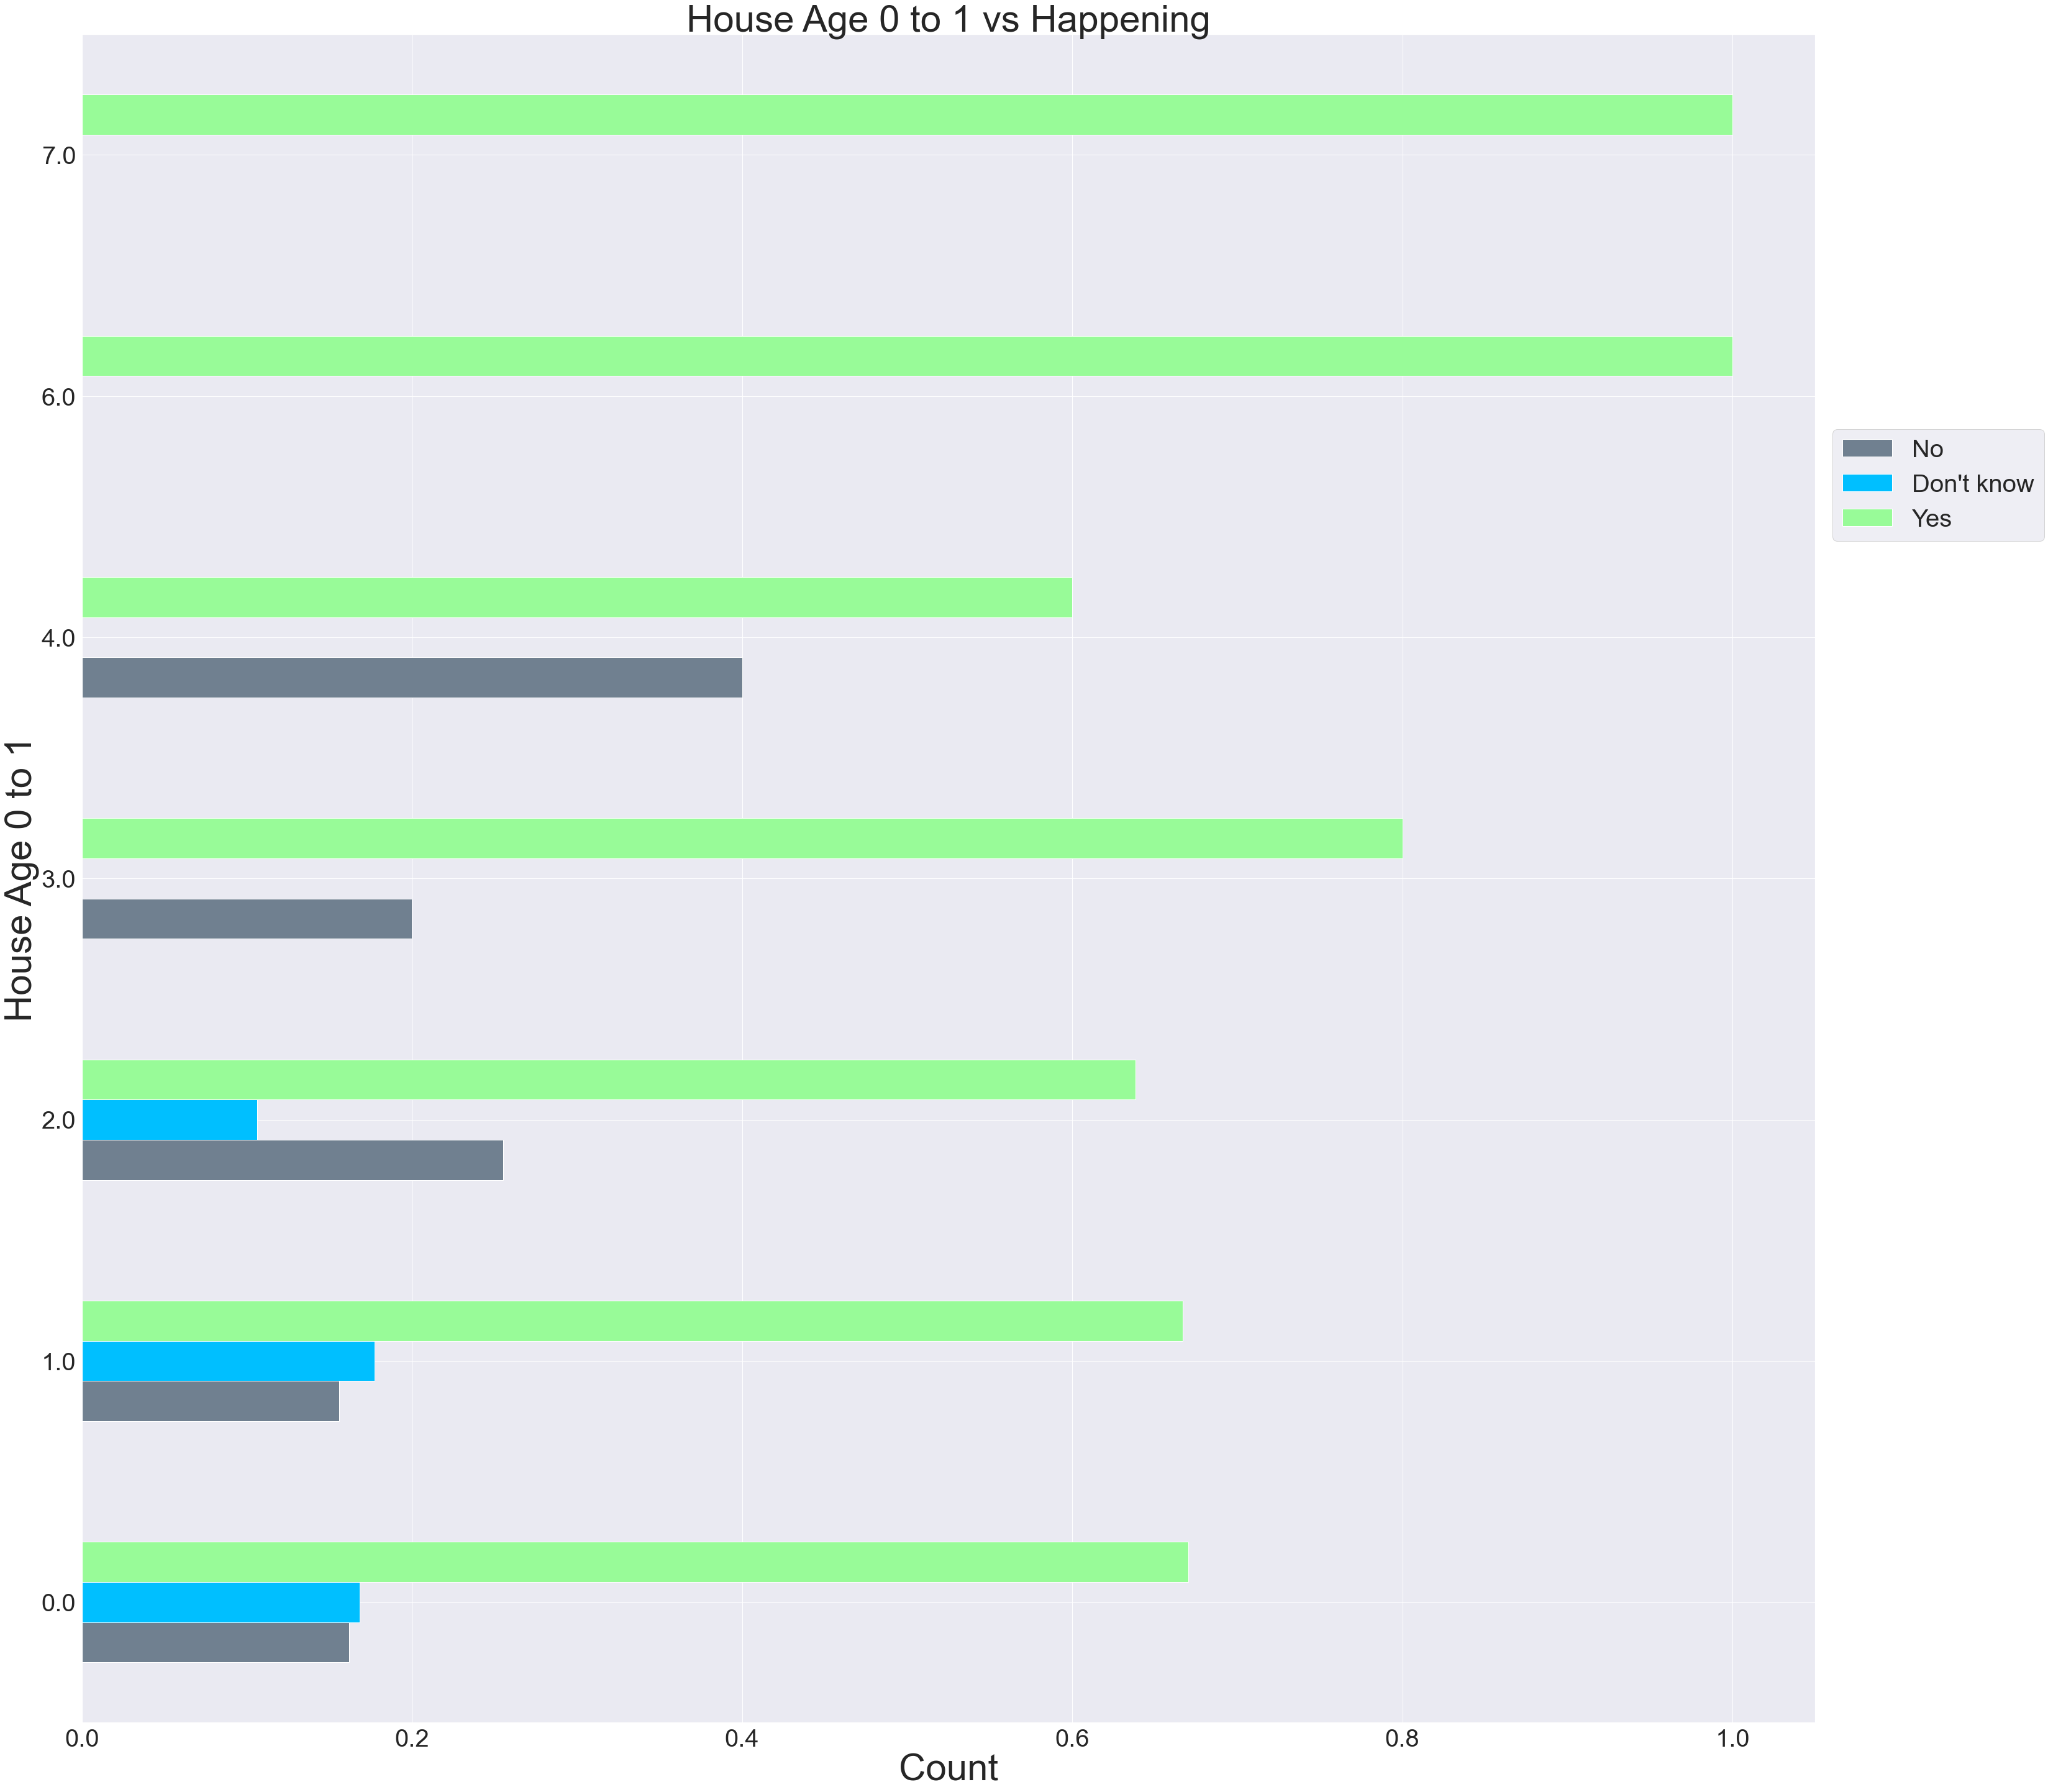

In [203]:
ax = df.groupby('house_ages0to1')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 0 to 1',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 0 to 1 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 0 to 1.**
- **0 is the dominant group** 

In [204]:
df.house_ages2to5.value_counts(normalize=True)

0.0    0.912843
1.0    0.069301
2.0    0.016636
3.0    0.001085
4.0    0.000136
Name: house_ages2to5, dtype: float64

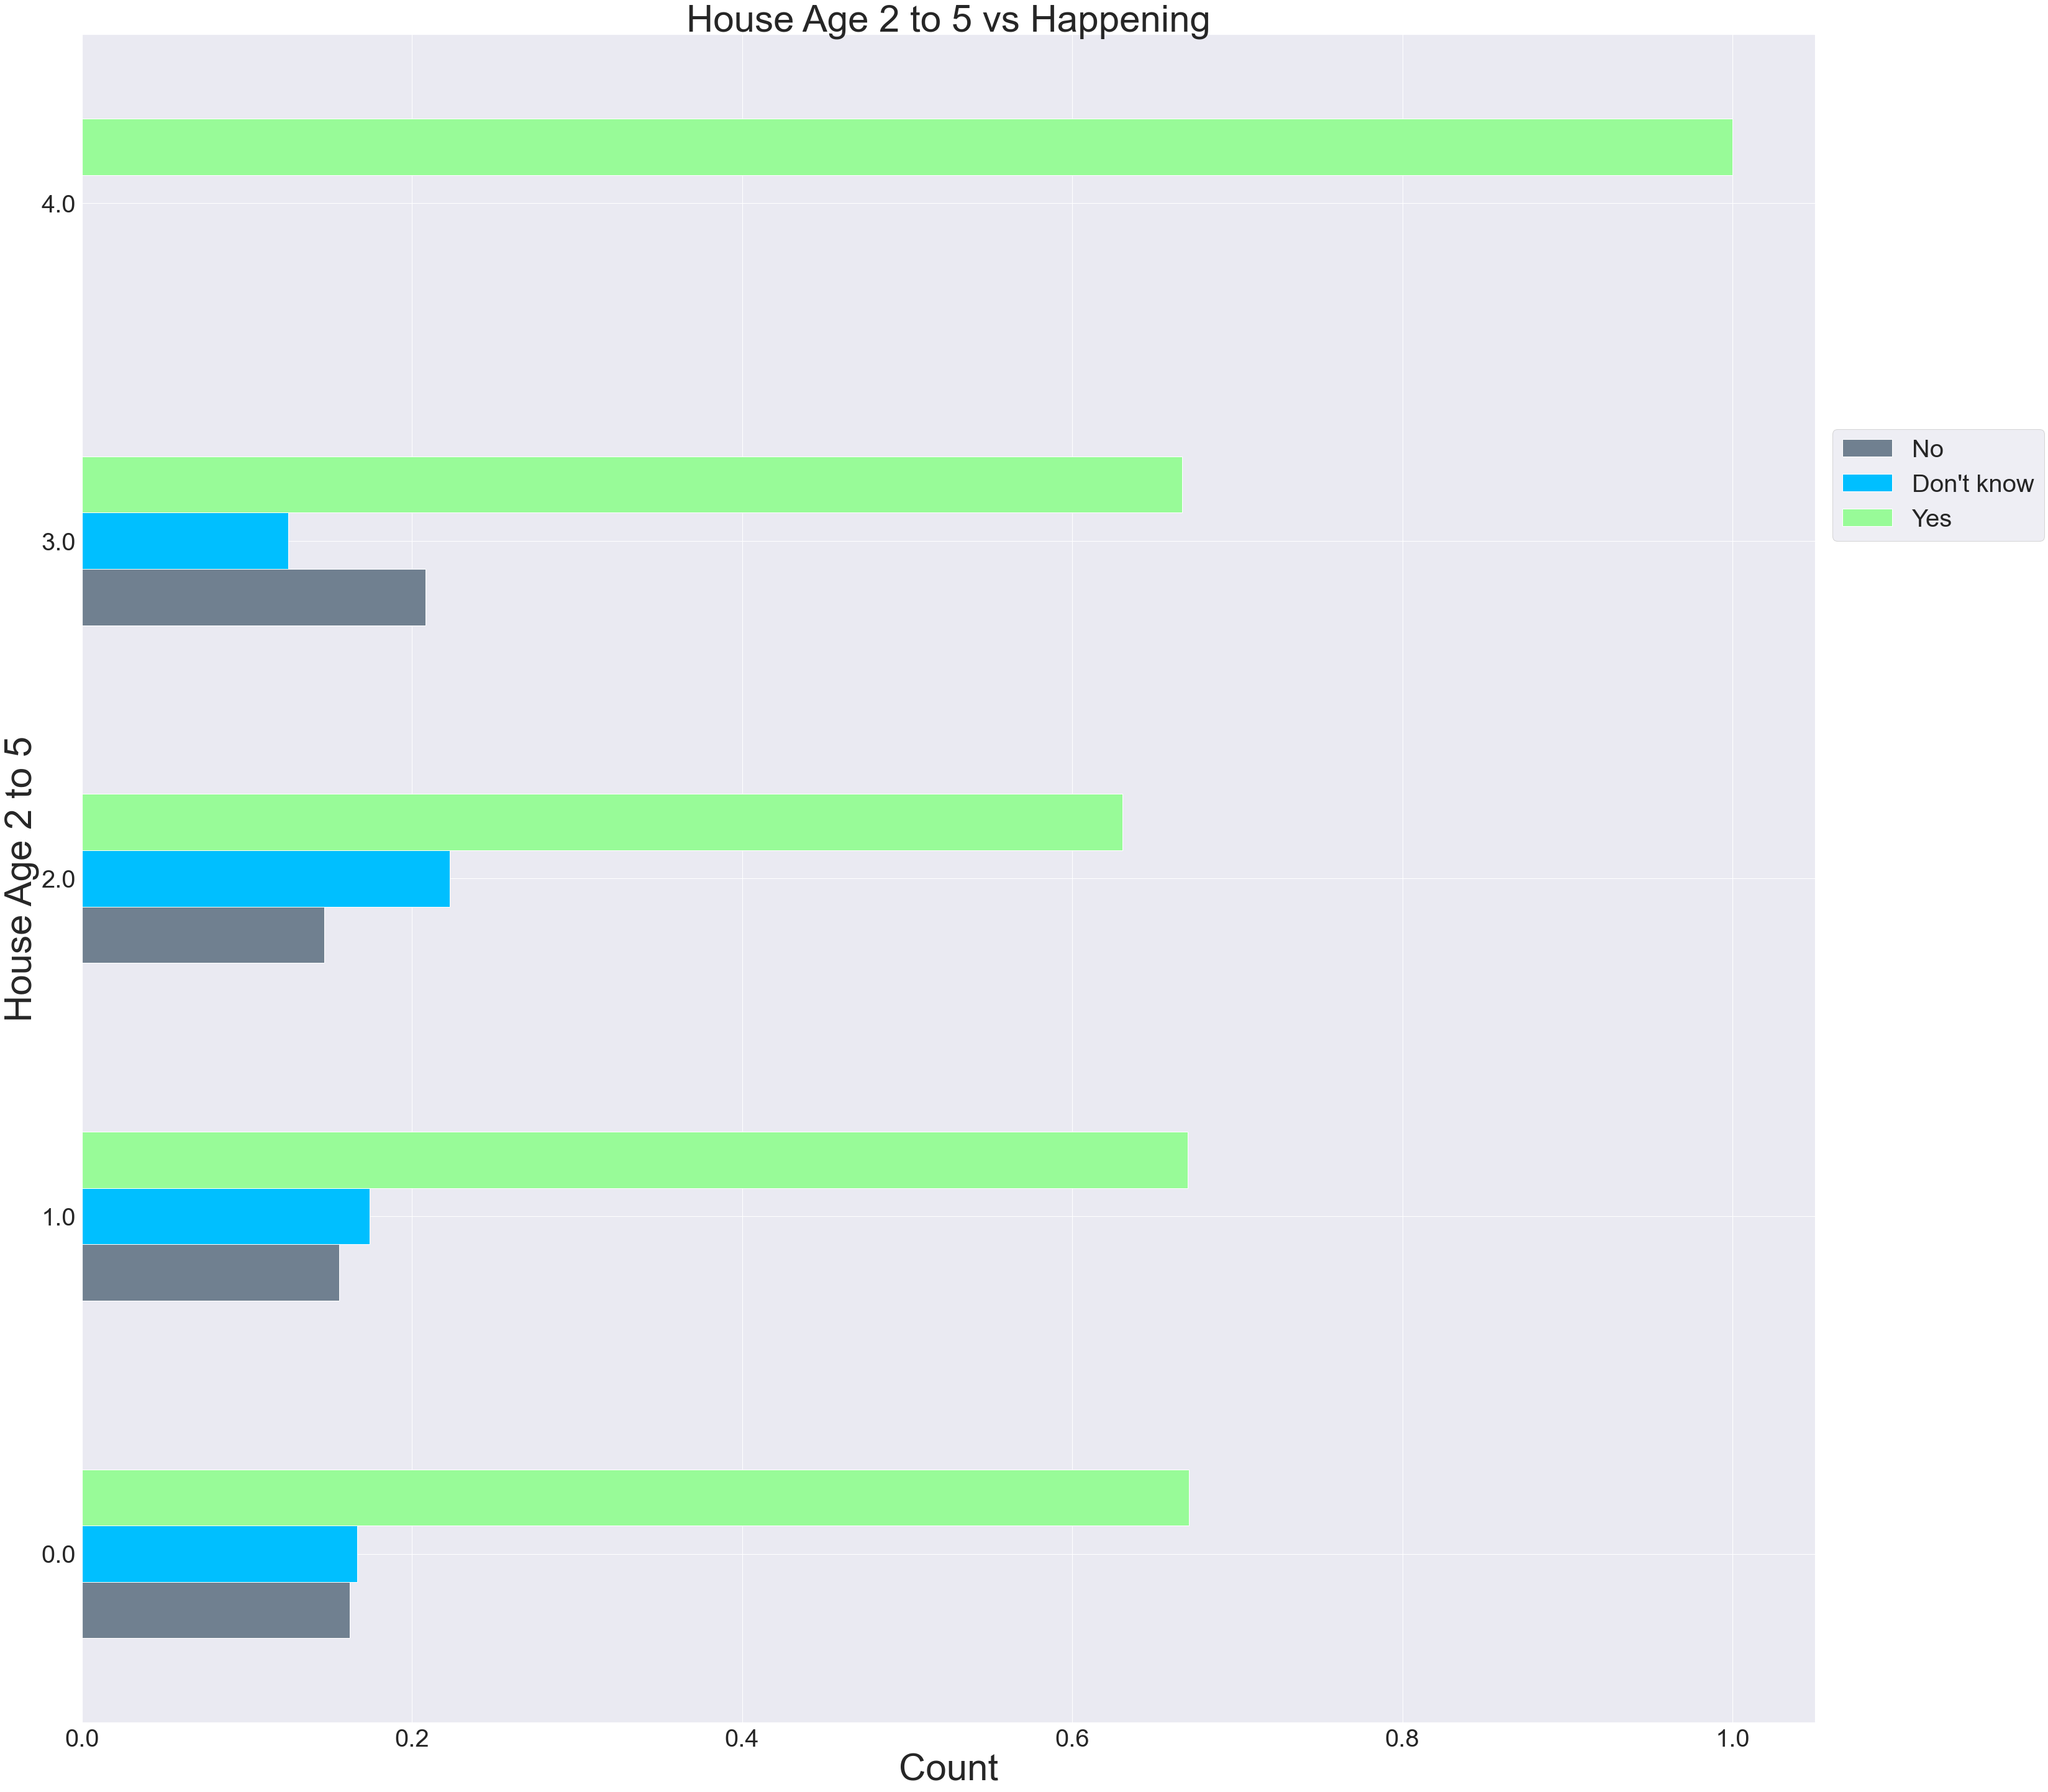

In [205]:
ax = df.groupby('house_ages2to5')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 2 to 5',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 2 to 5 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 2 to 5.**
- **0 is the dominant group** 

In [206]:
df.house_ages6to12.value_counts(normalize=True)

0.0    0.856381
1.0    0.094209
2.0    0.039781
3.0    0.008047
4.0    0.001401
5.0    0.000090
6.0    0.000090
Name: house_ages6to12, dtype: float64

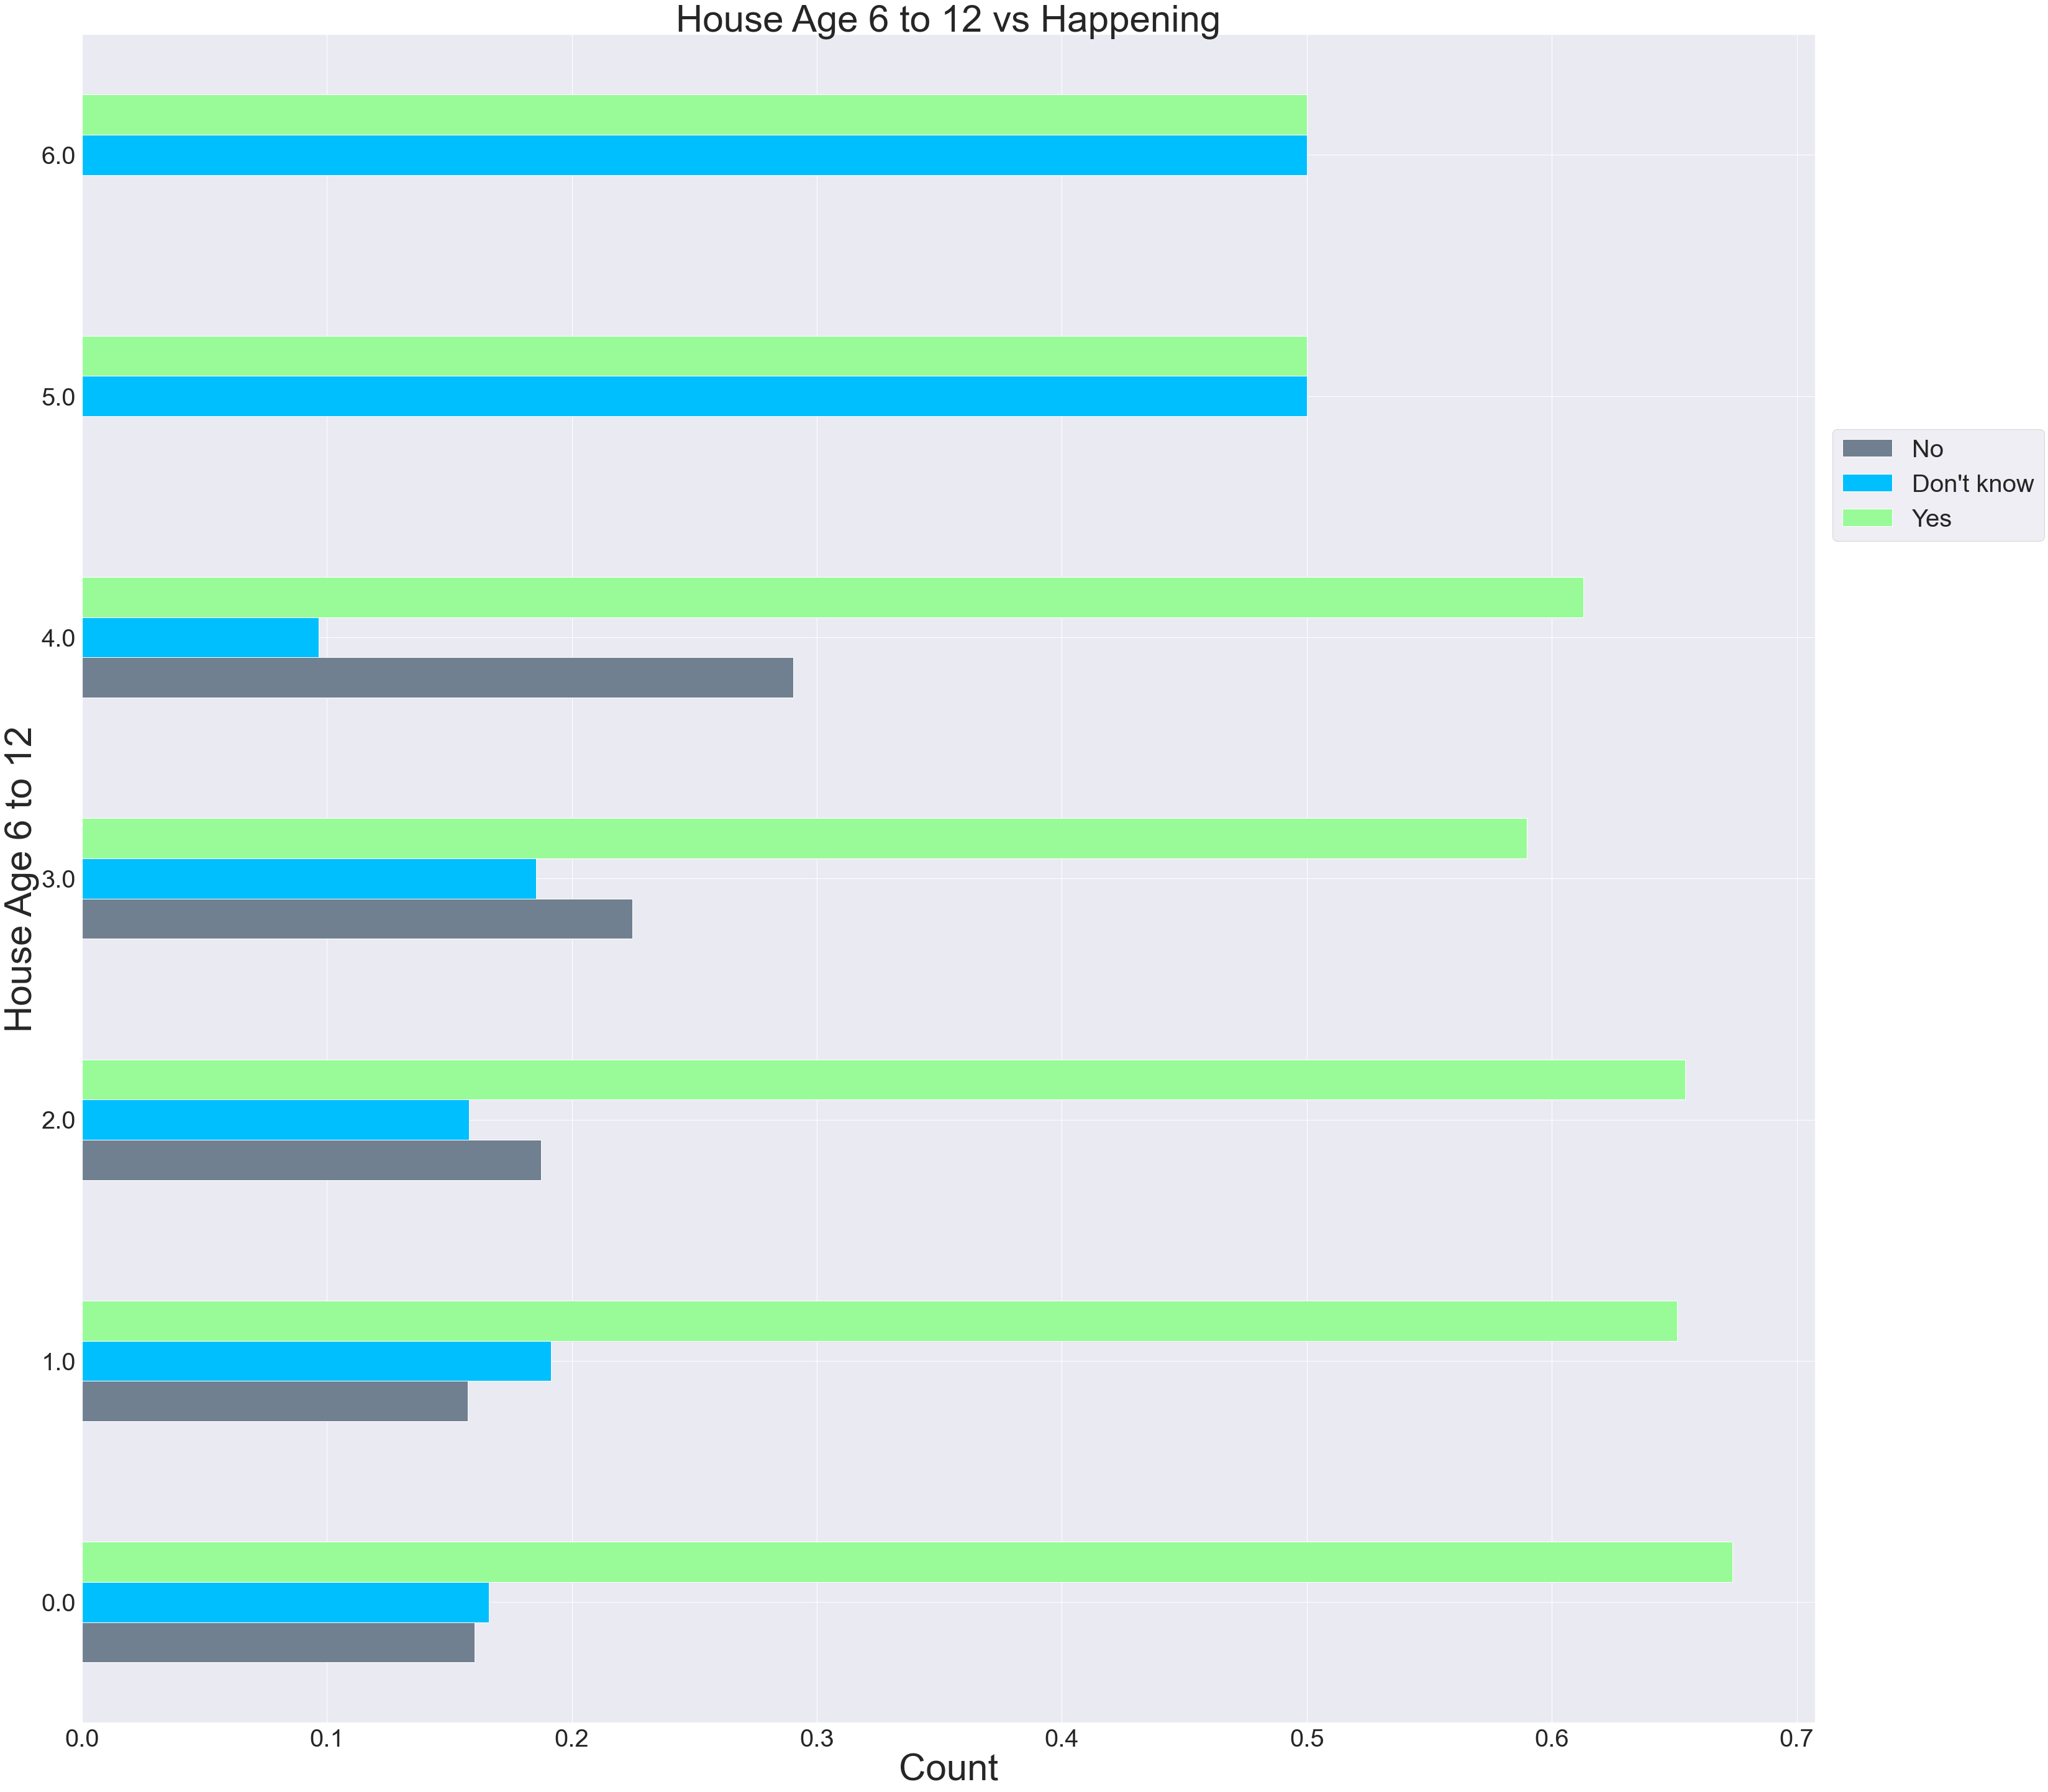

In [207]:
ax = df.groupby('house_ages6to12')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 6 to 12',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 6 to 12 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 6 to 12.** 
- **0 is the dominant group** 


In [208]:
df.house_ages13to17.value_counts(normalize=True)

0.0    0.853849
1.0    0.109760
2.0    0.031554
3.0    0.004159
4.0    0.000678
Name: house_ages13to17, dtype: float64

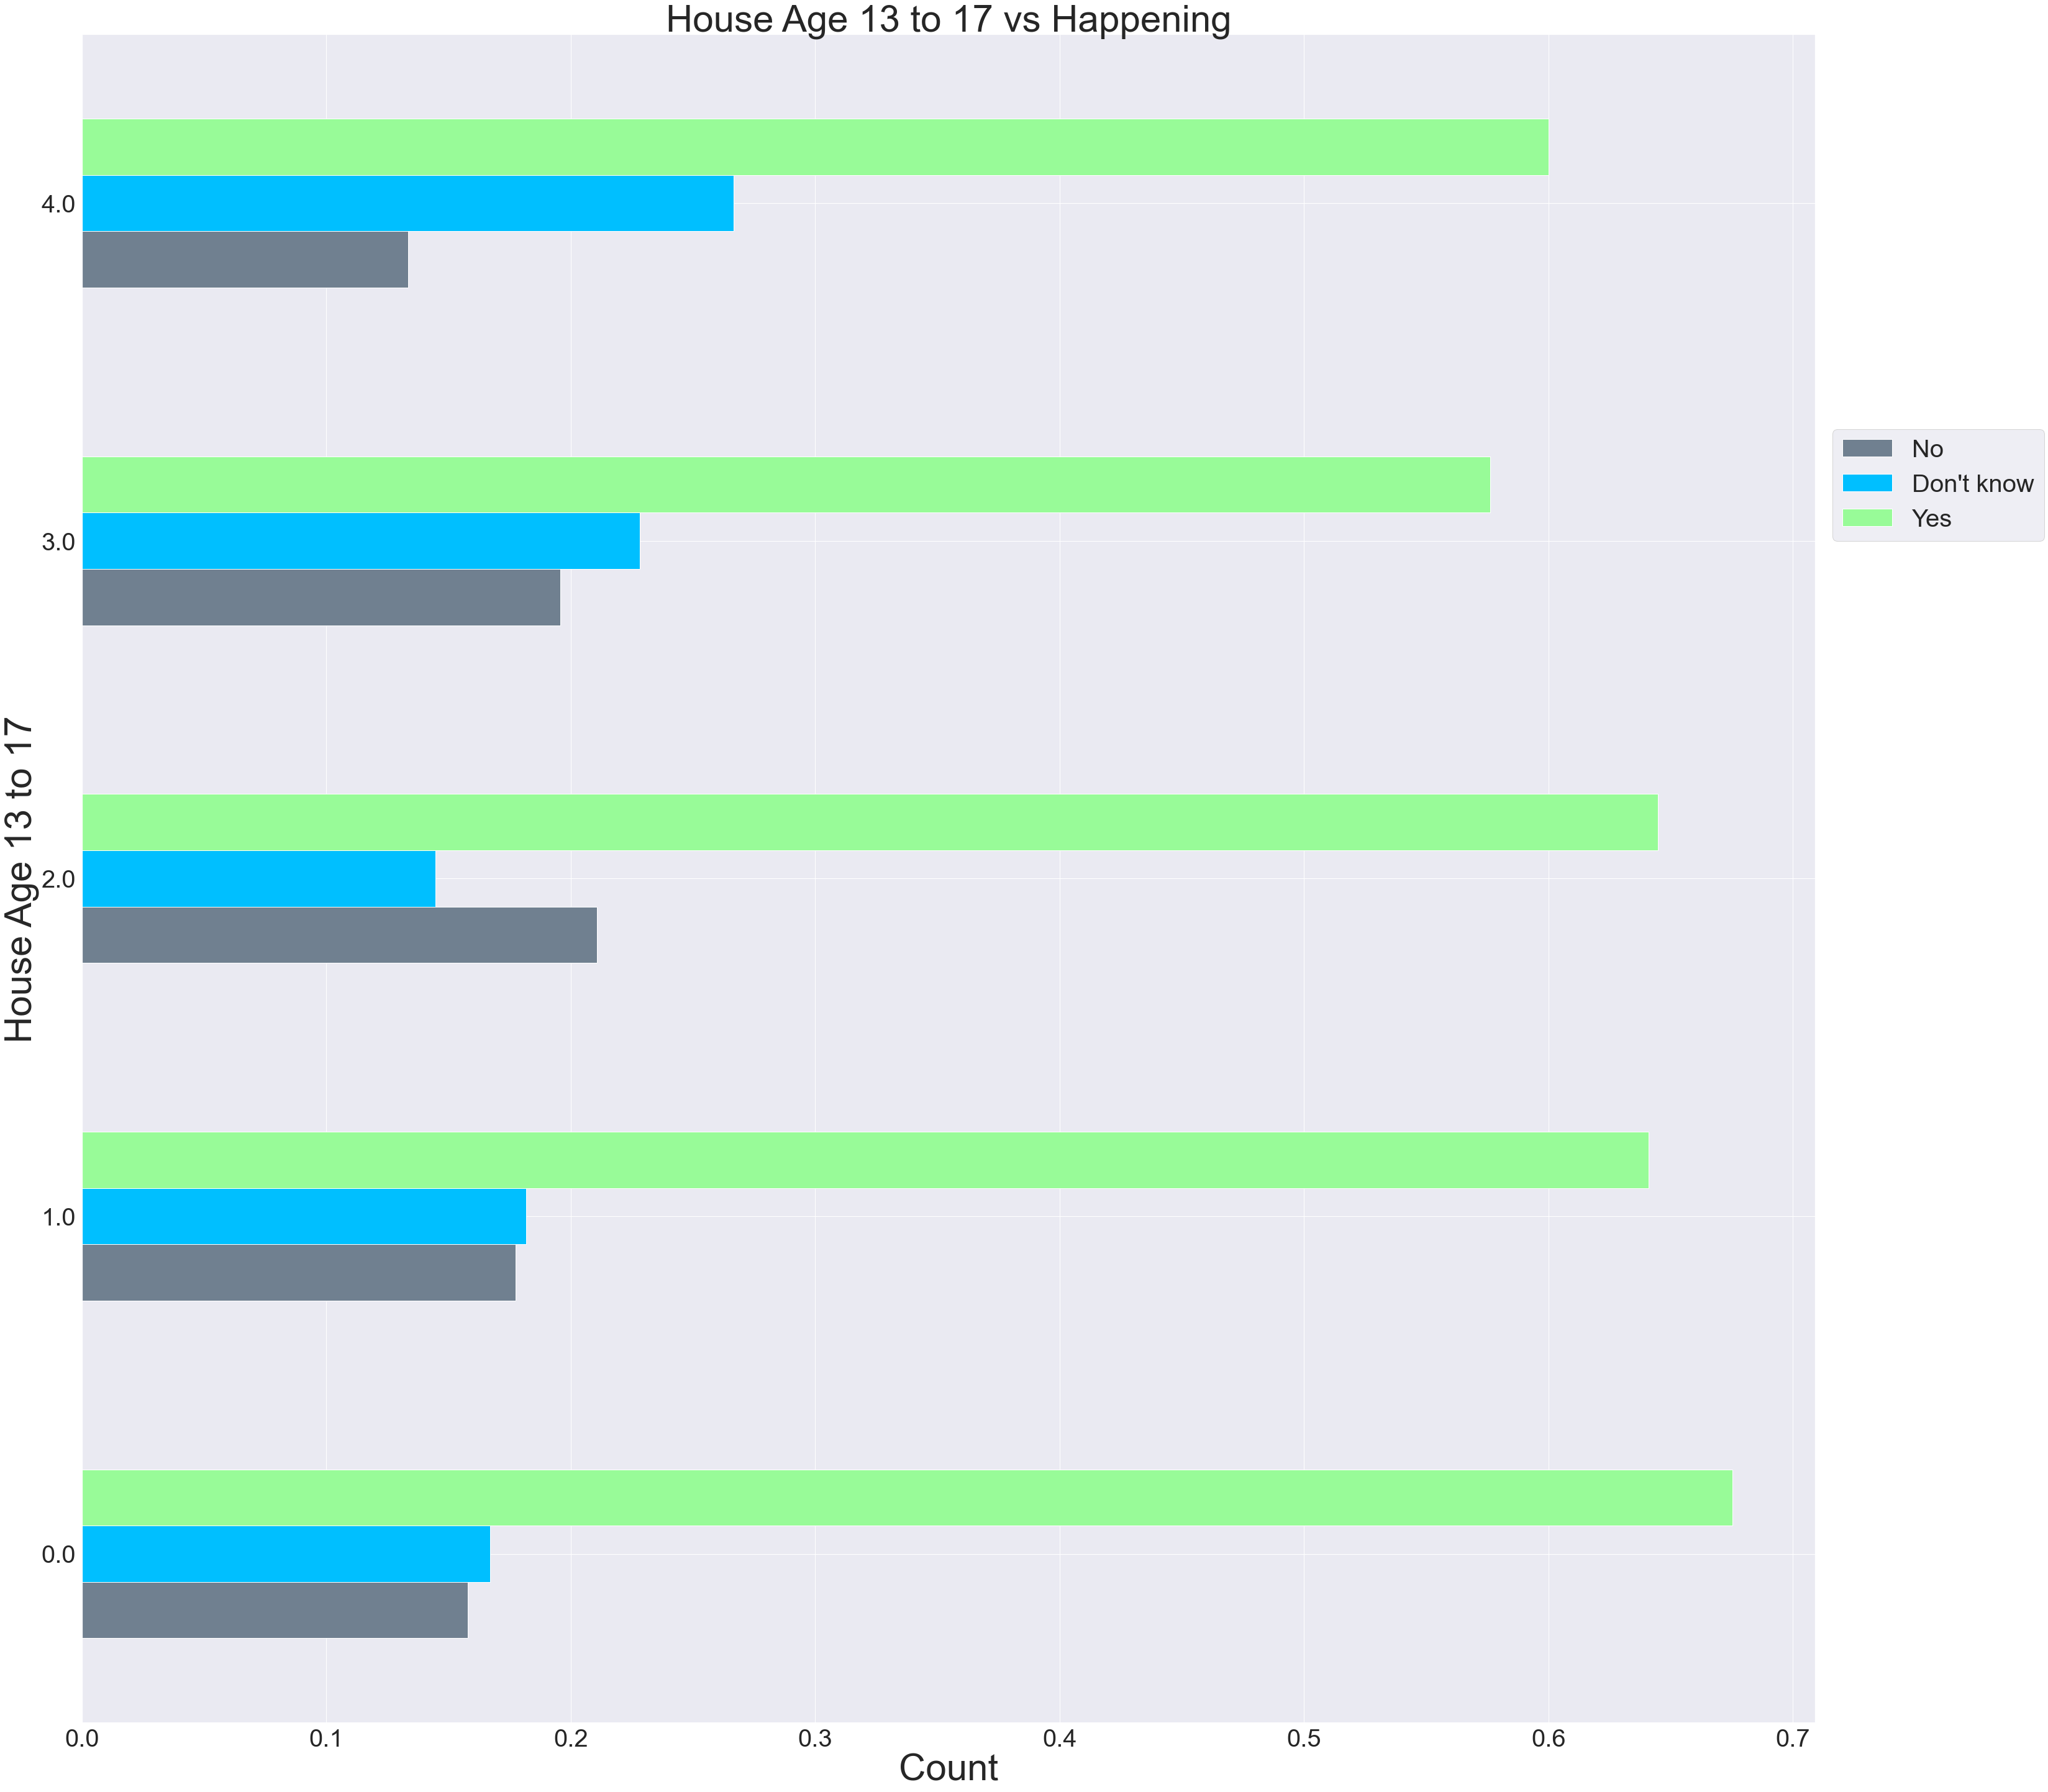

In [209]:
ax = df.groupby('house_ages13to17')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 13 to 17',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 13 to 17 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 13 to 17.** 
- **0 is the dominant group** 


In [210]:
df.house_ages18plus.value_counts(normalize=True)

2.0     0.556349
1.0     0.214999
3.0     0.147869
4.0     0.057638
5.0     0.015777
6.0     0.004204
7.0     0.002079
8.0     0.000588
12.0    0.000362
9.0     0.000090
10.0    0.000045
Name: house_ages18plus, dtype: float64

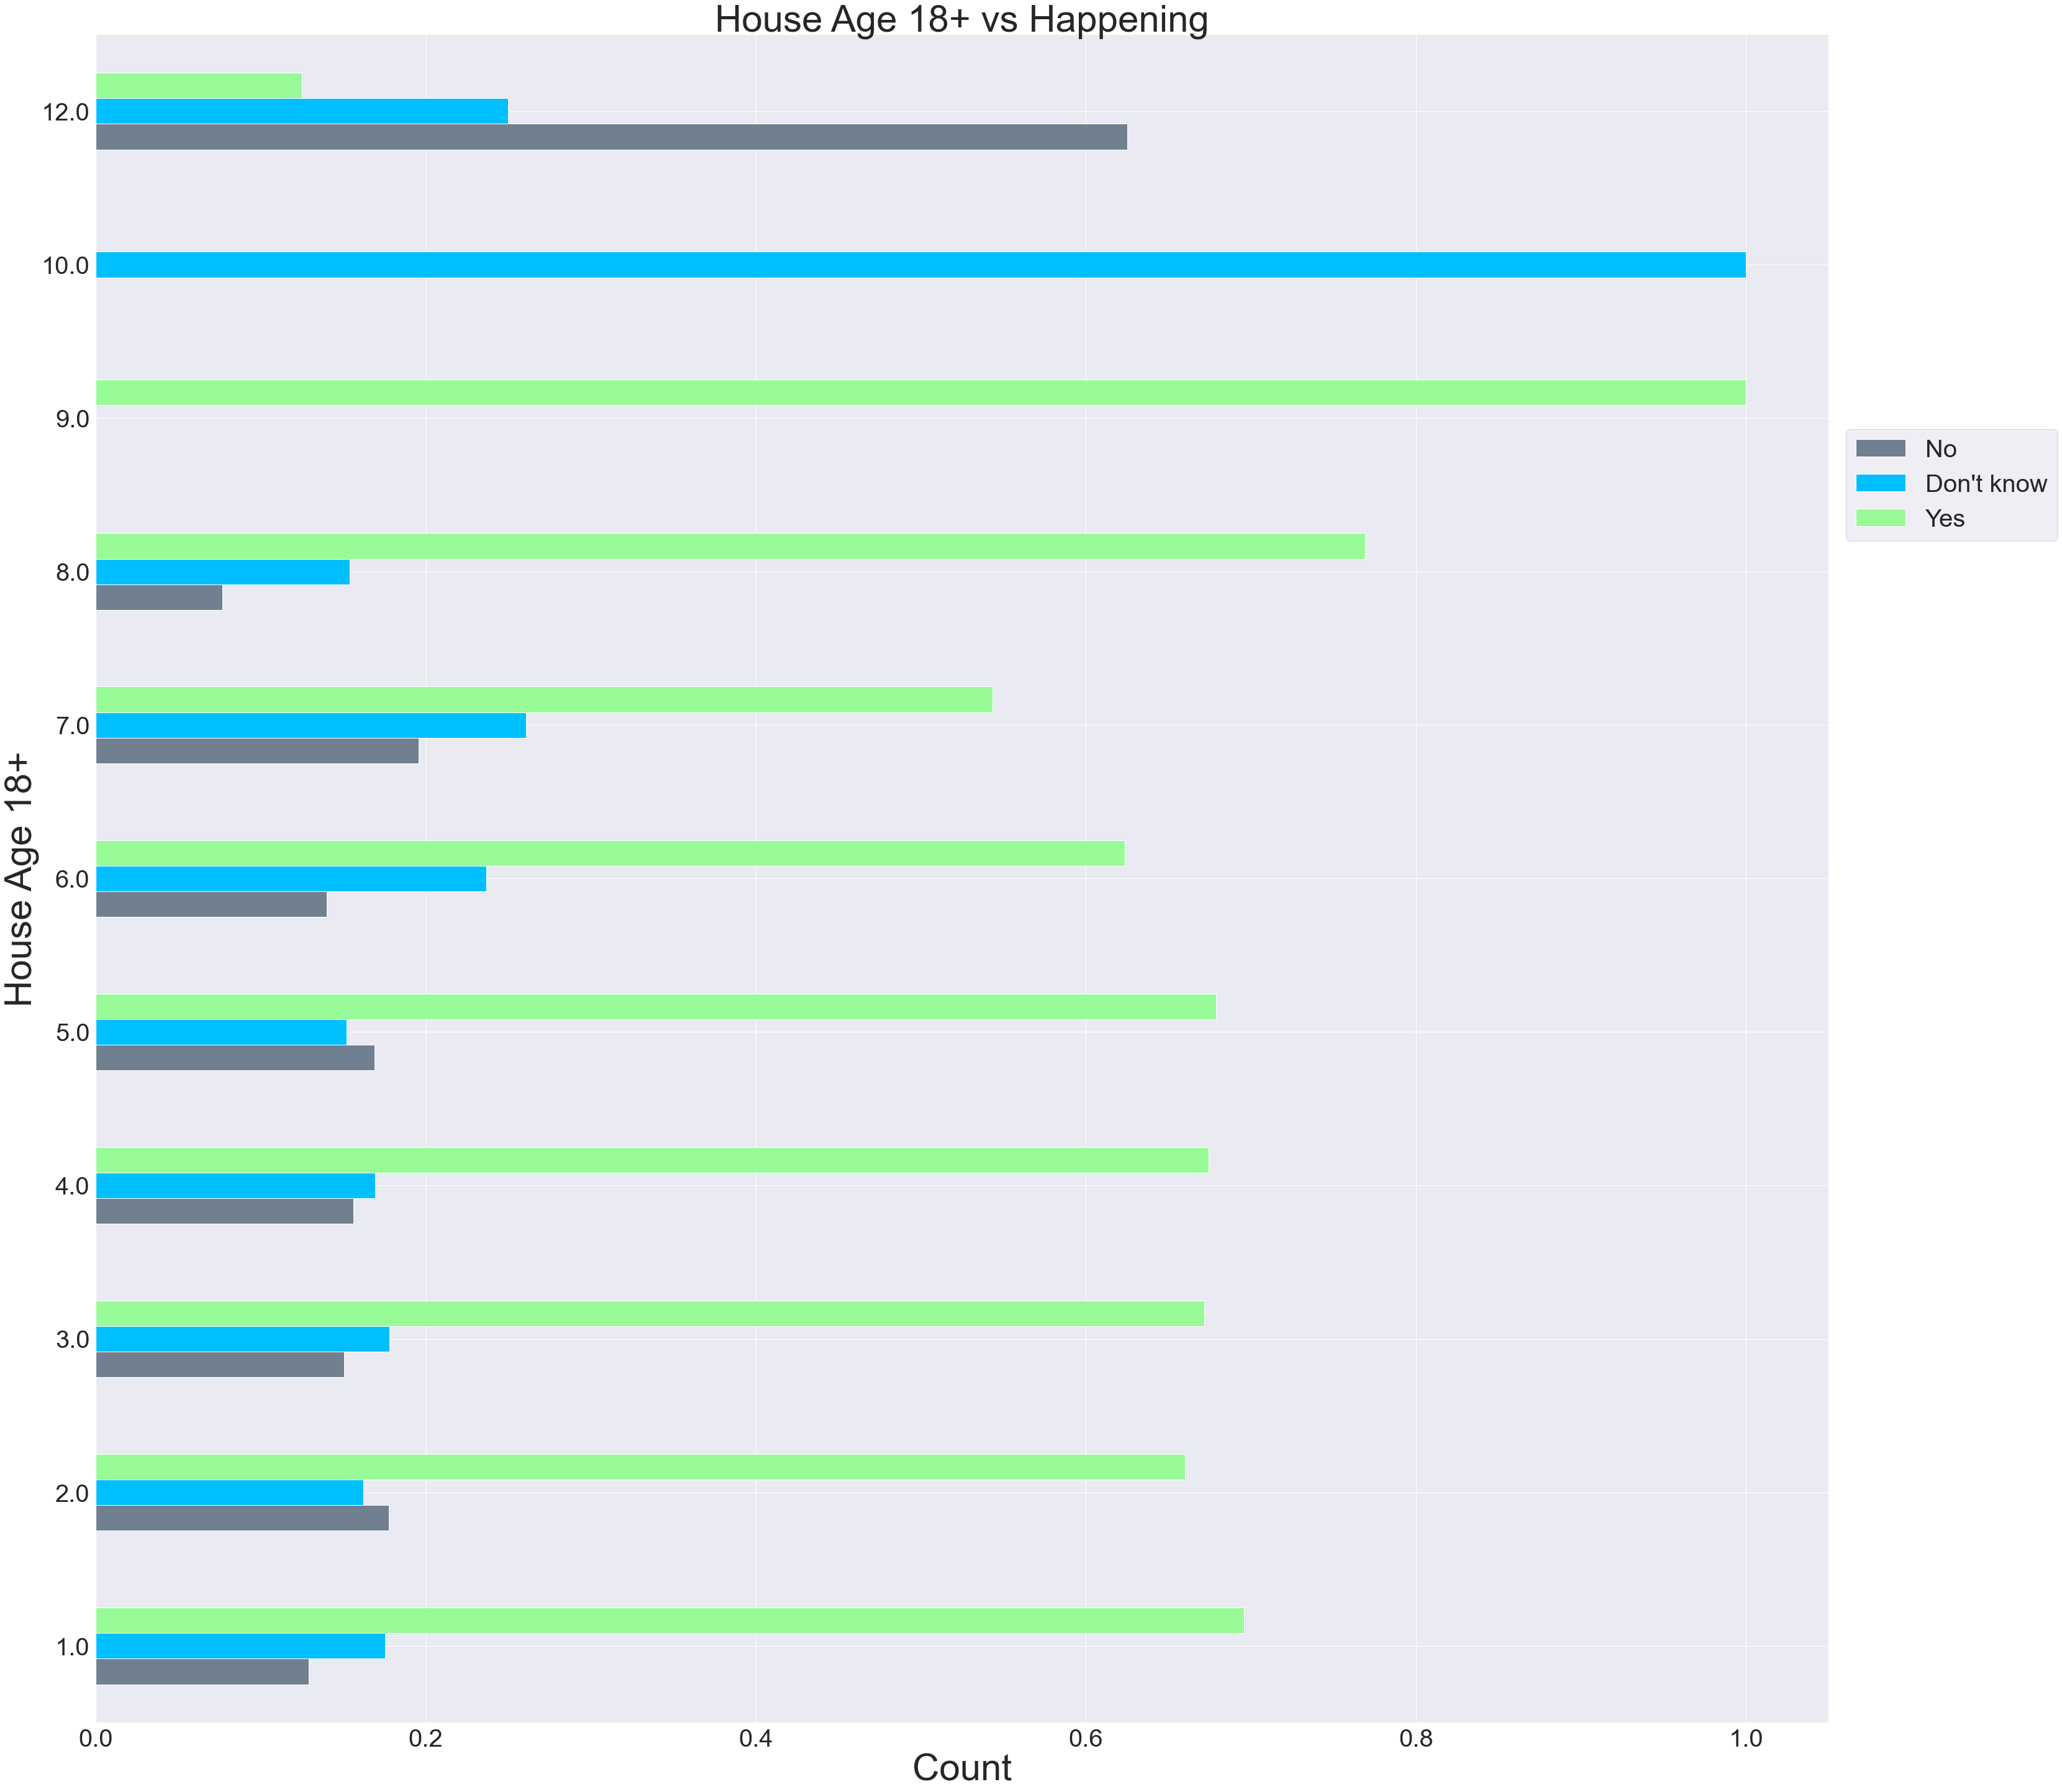

In [211]:
ax = df.groupby('house_ages18plus')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 18+',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 18+ vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 18+.** 
- **0 is the dominant group** 


In [212]:
df.house_type.value_counts(normalize=True)

One-family house detached from any other house                                    0.722752
Building with 2 or more apartments                                                0.155011
One-family house attached to one or more houses (such as a condo or townhouse)    0.075584
Mobile home                                                                       0.044166
Boat, RV, van, etc.                                                               0.002486
Name: house_type, dtype: float64

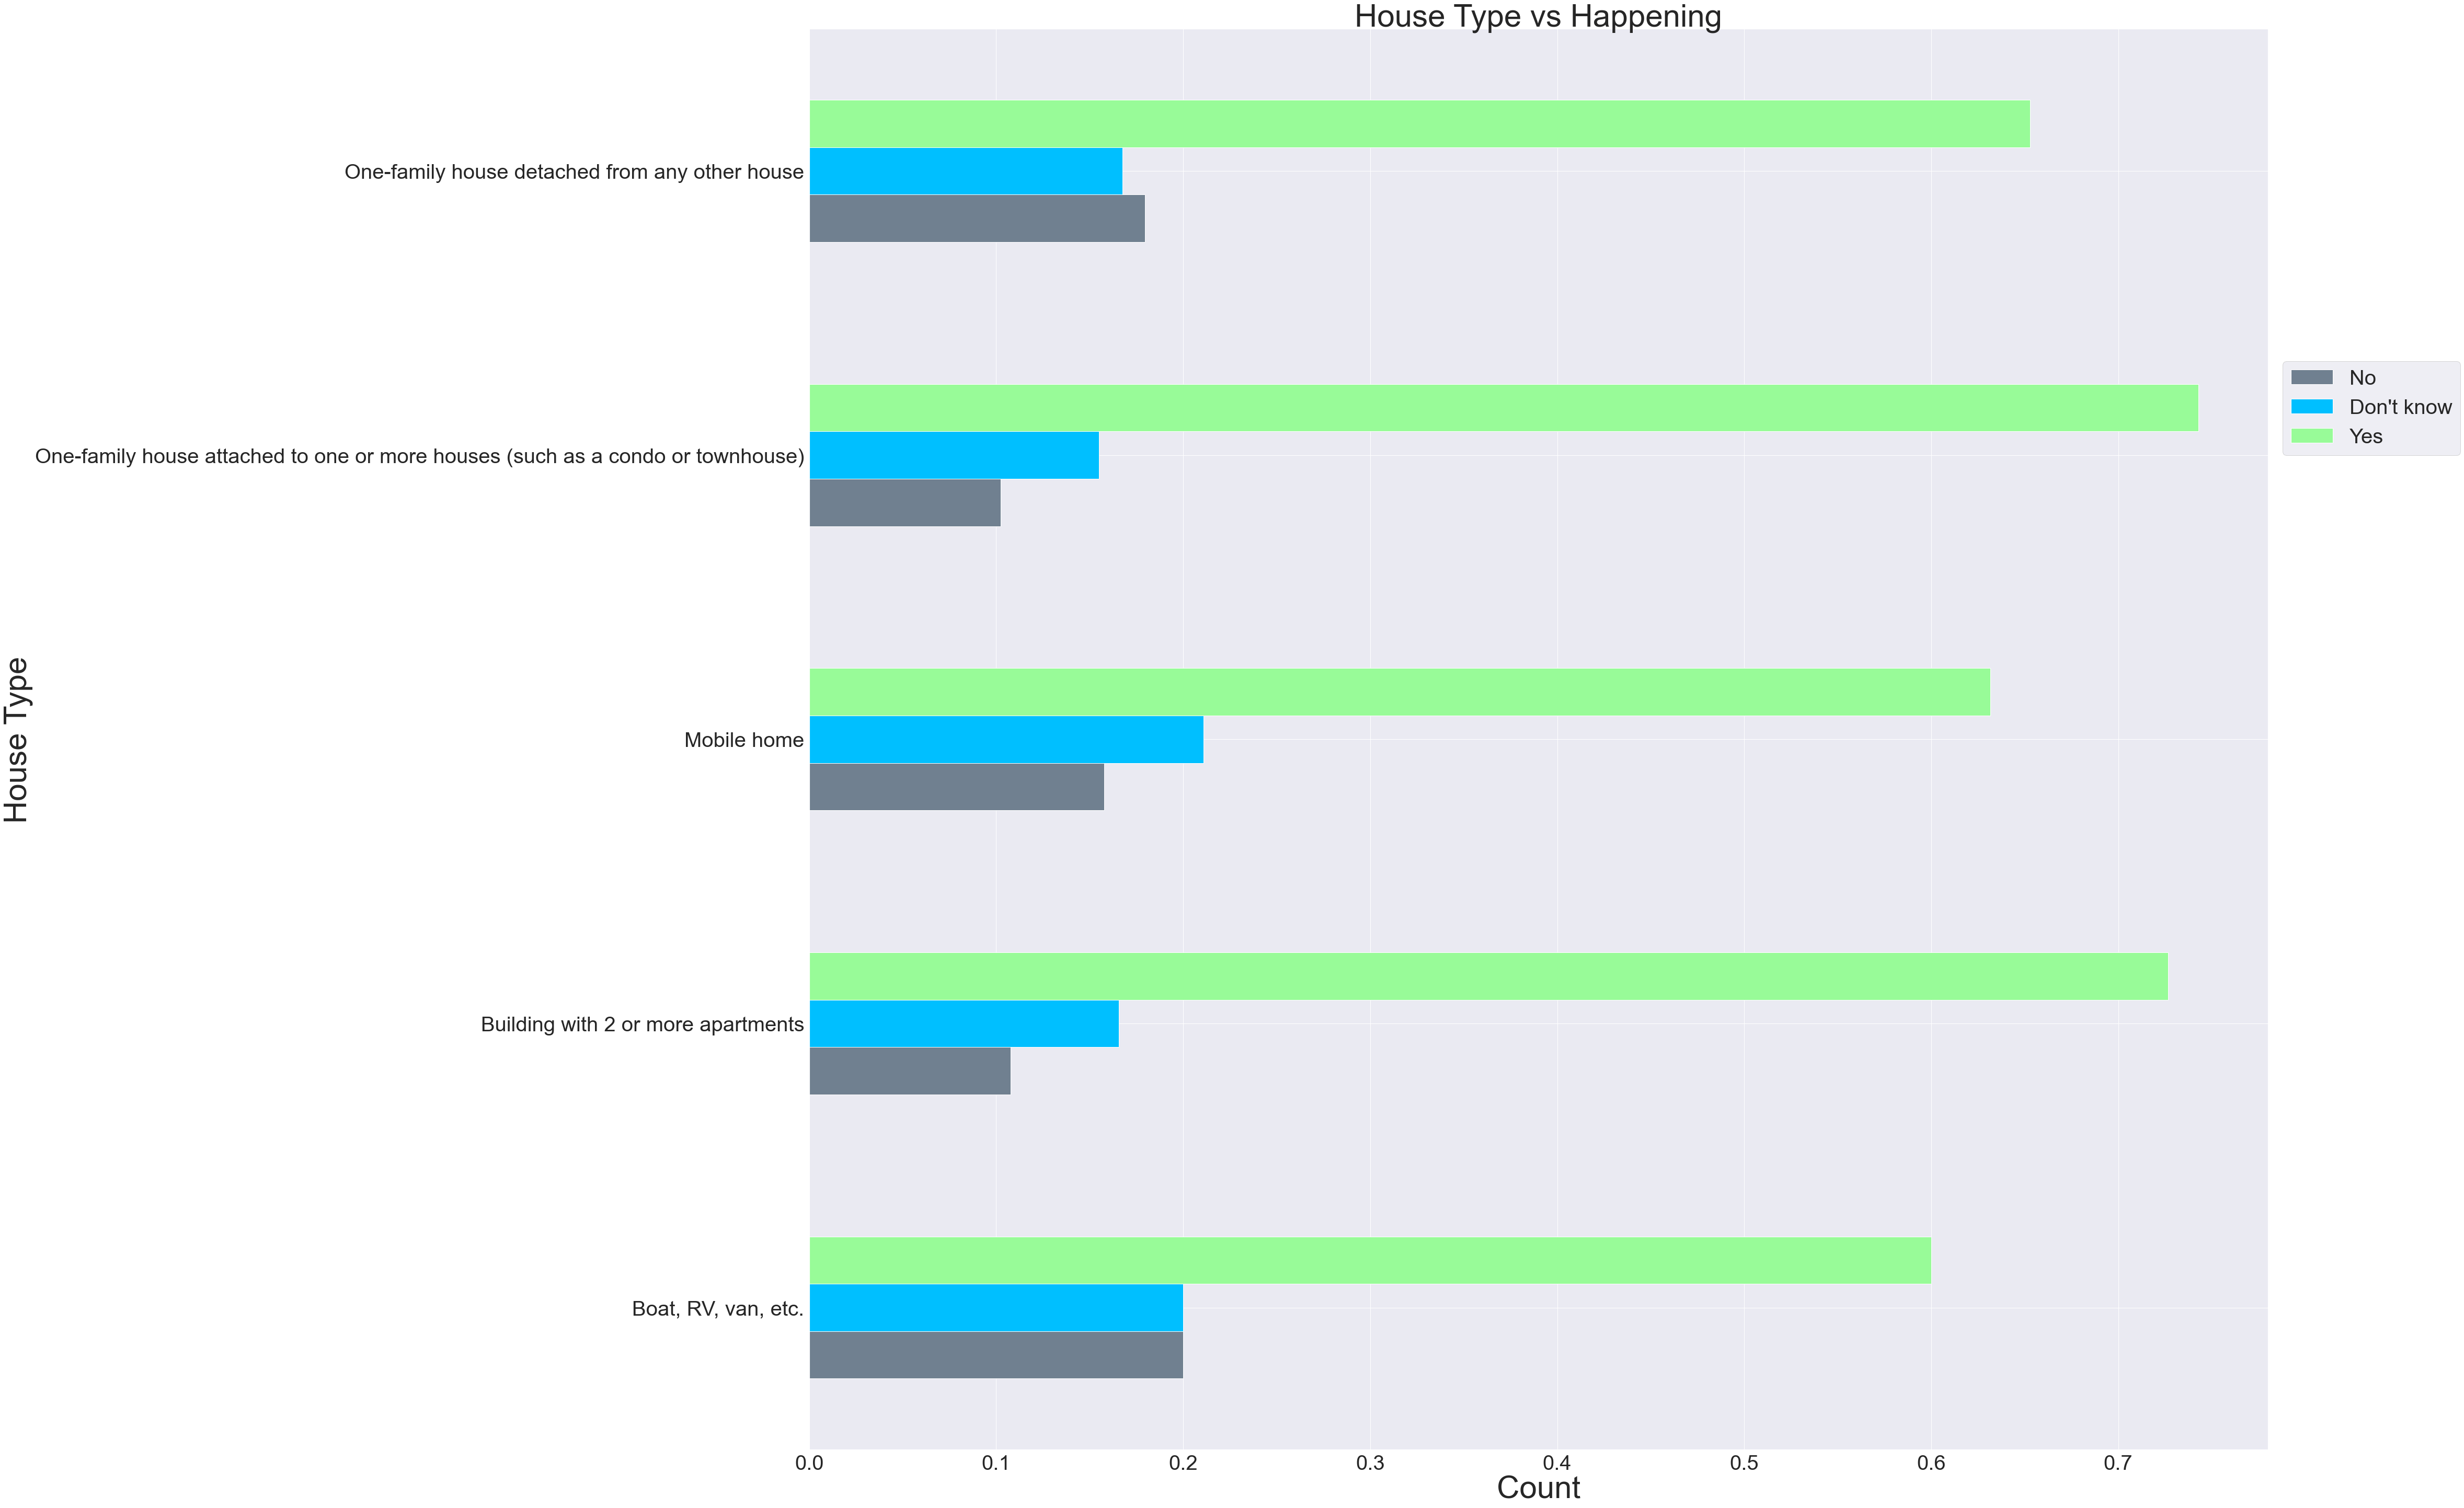

In [213]:
ax = df.groupby('house_type')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Type',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Type vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **One family house are pre-dominant.** 
- **People with mobile homes seem to have a higher proportion of non-believers of climate change** 


In [214]:
df.house_own.value_counts(normalize=True)

Owned by you or someone in your household    0.747254
Rented                                       0.229013
Occupied without payment of rent             0.023733
Name: house_own, dtype: float64

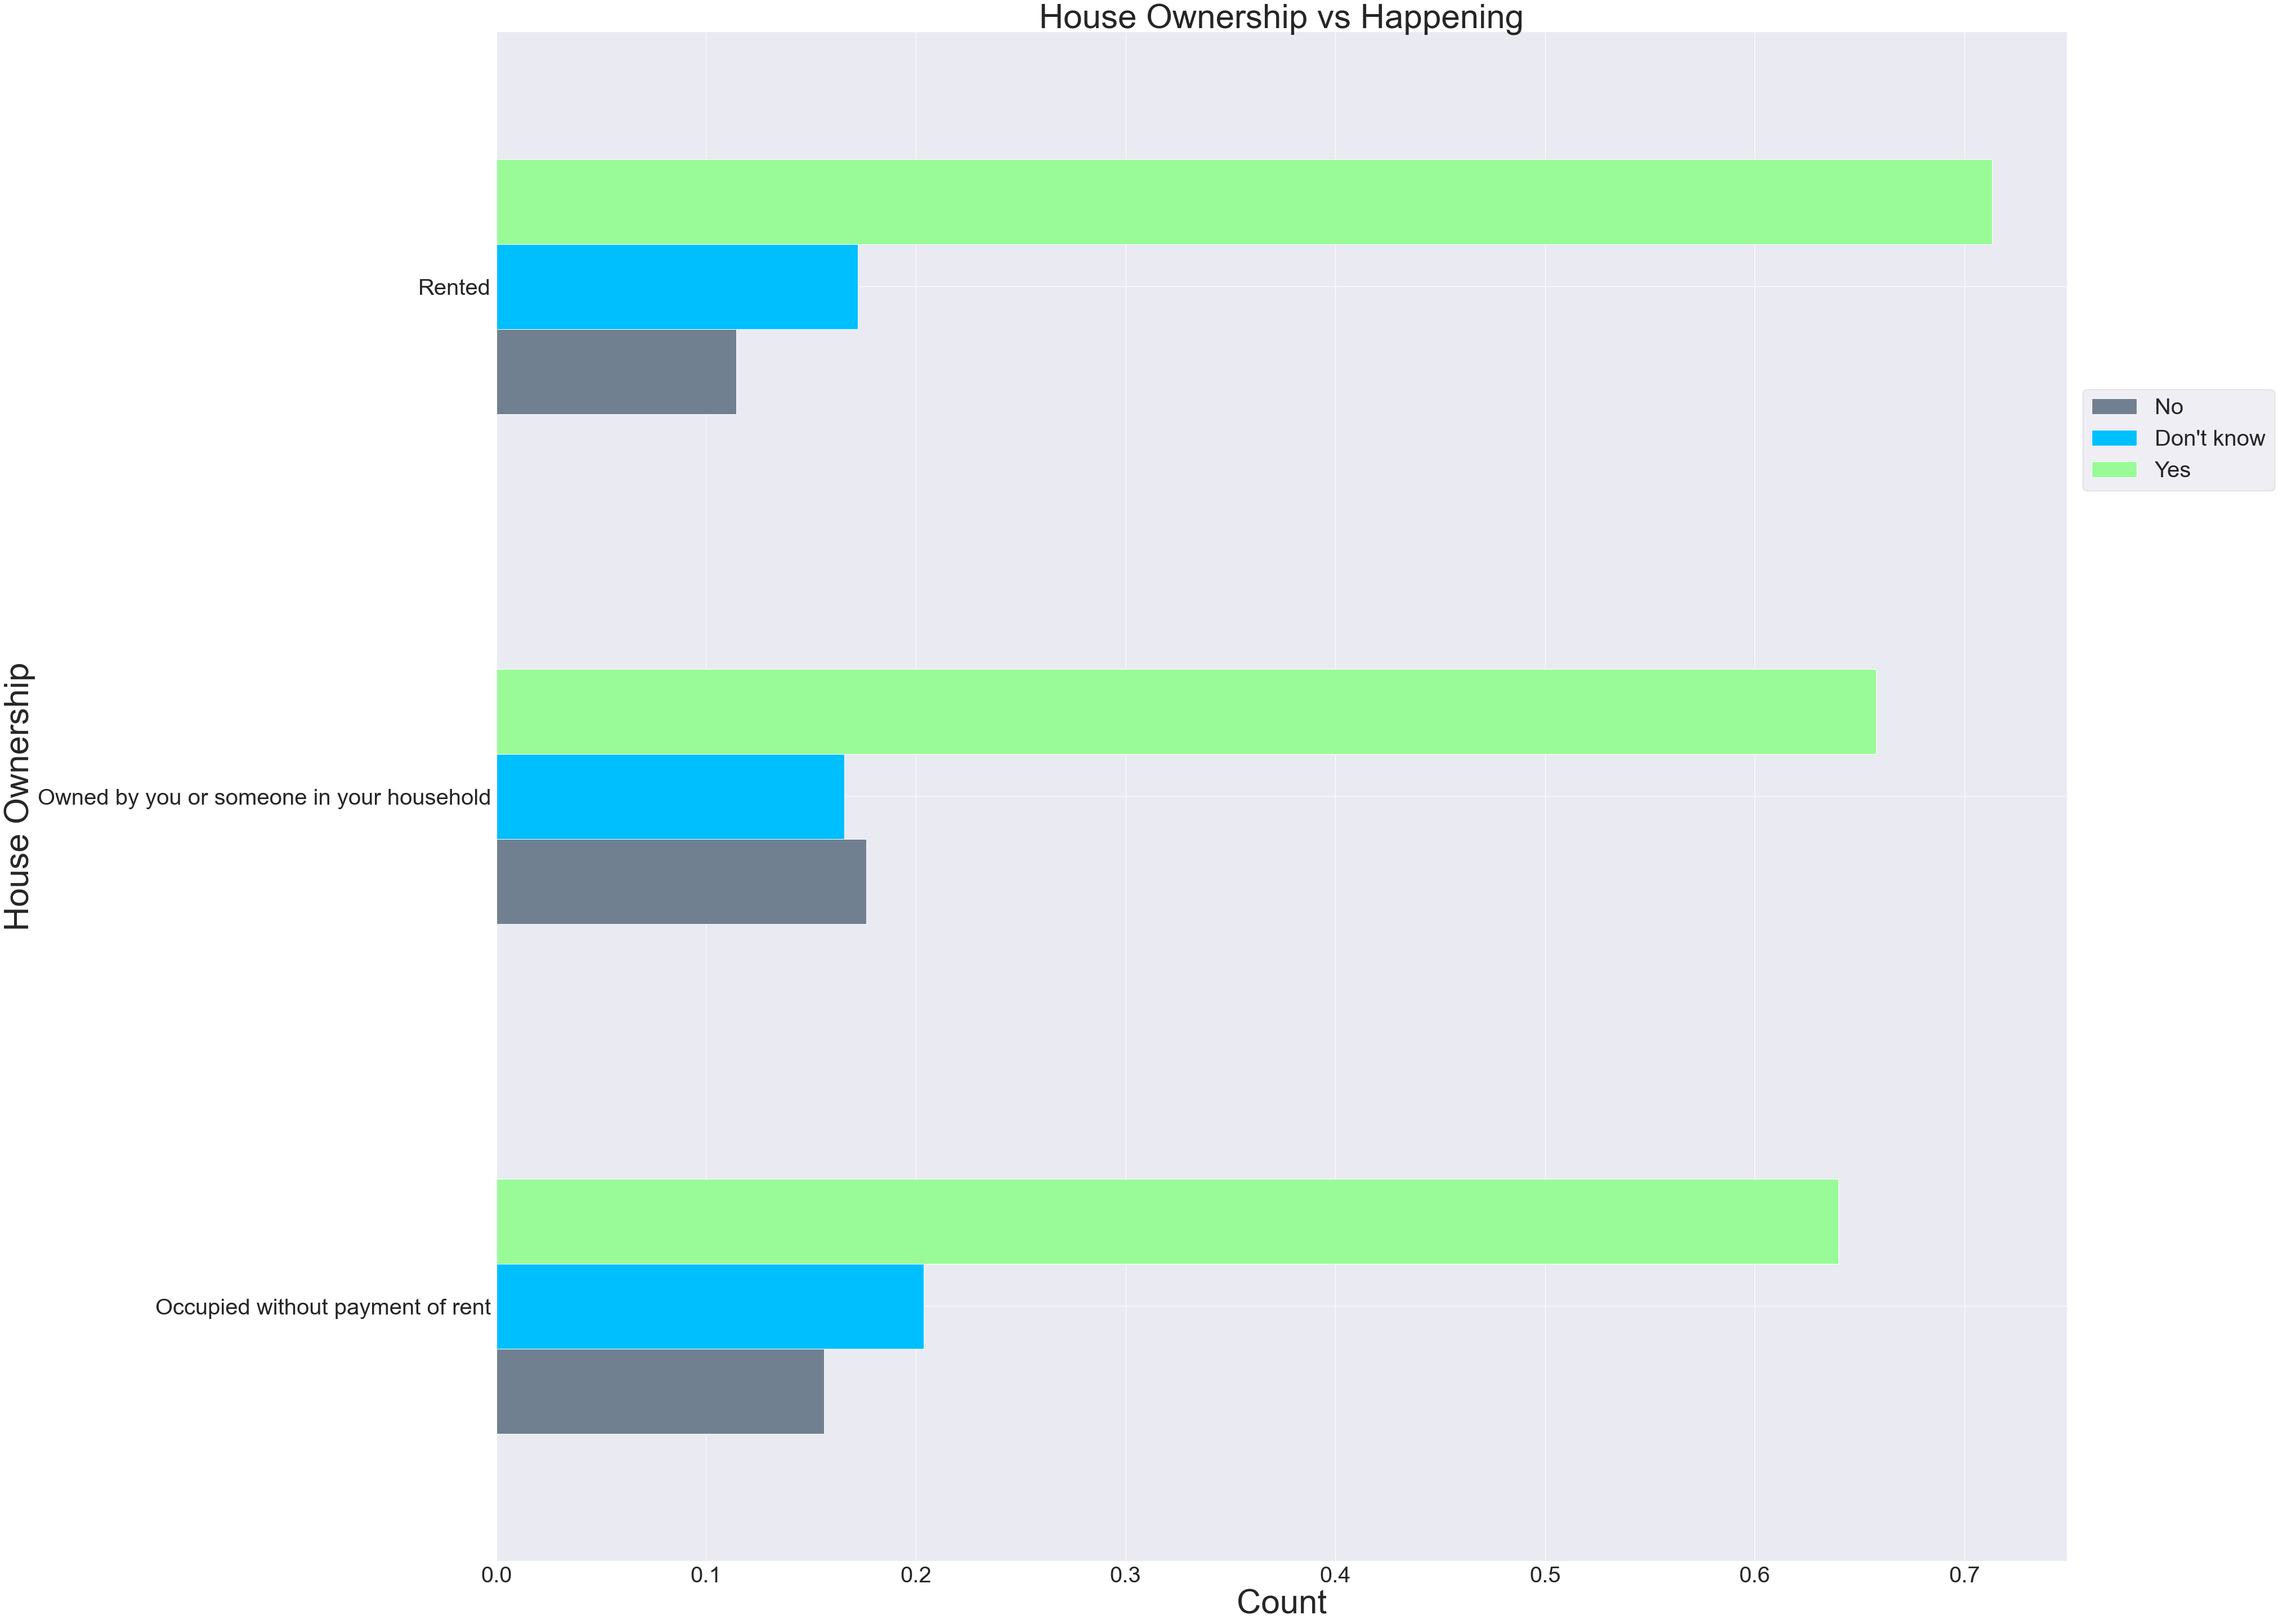

In [215]:
ax = df.groupby('house_own')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Ownership',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Ownership vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **houses owned by an individual or a family member are pre-dominant.** 


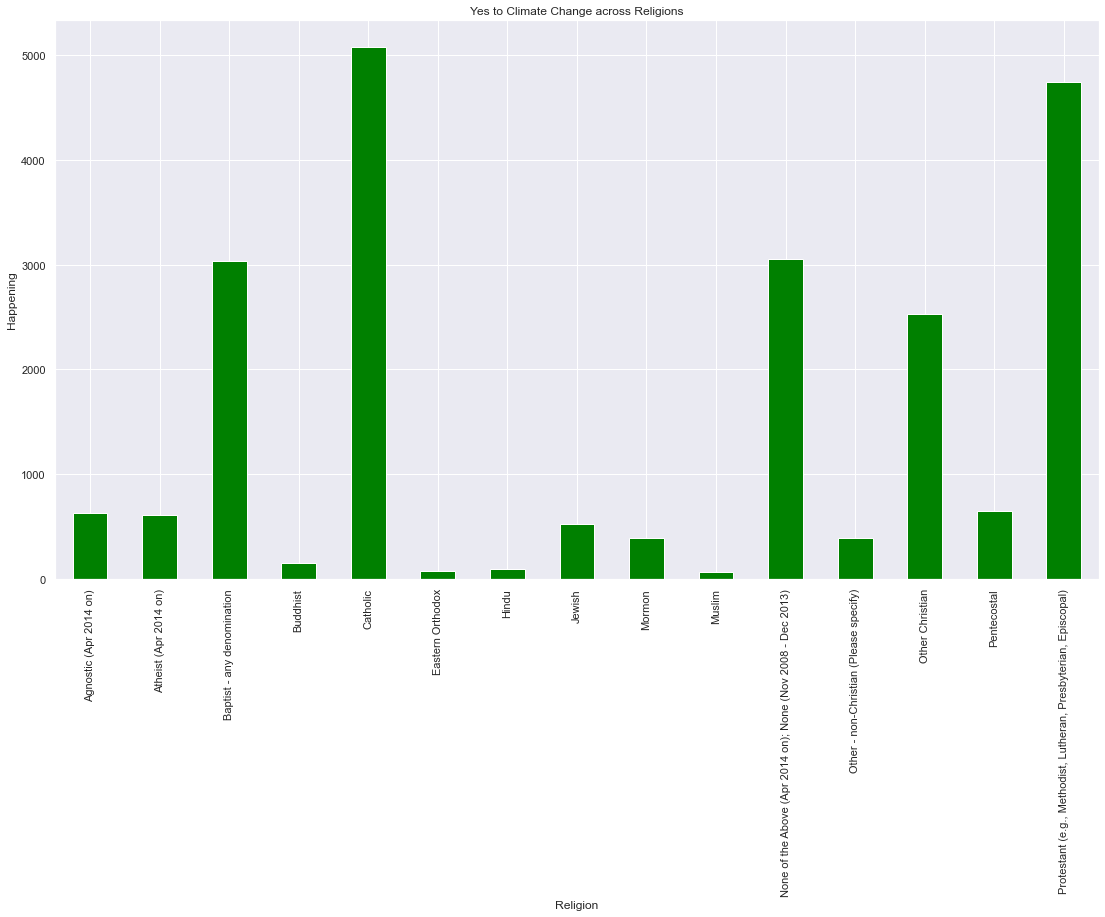

In [216]:
ax = df.groupby(['religion'])['happening'].count().plot(kind='bar',stacked = True, color='green')
ax.set_xlabel('Religion')
ax.set_ylabel('Happening')
ax.set_title('Yes to Climate Change across Religions');




- **This graph represents the believers in climate change across religions.** 
- **The numbers vary due to different population of respective religion people** 
- **As expected for American society Catholic and Protestant have highest number of counts followed by Atheists and Baptists**

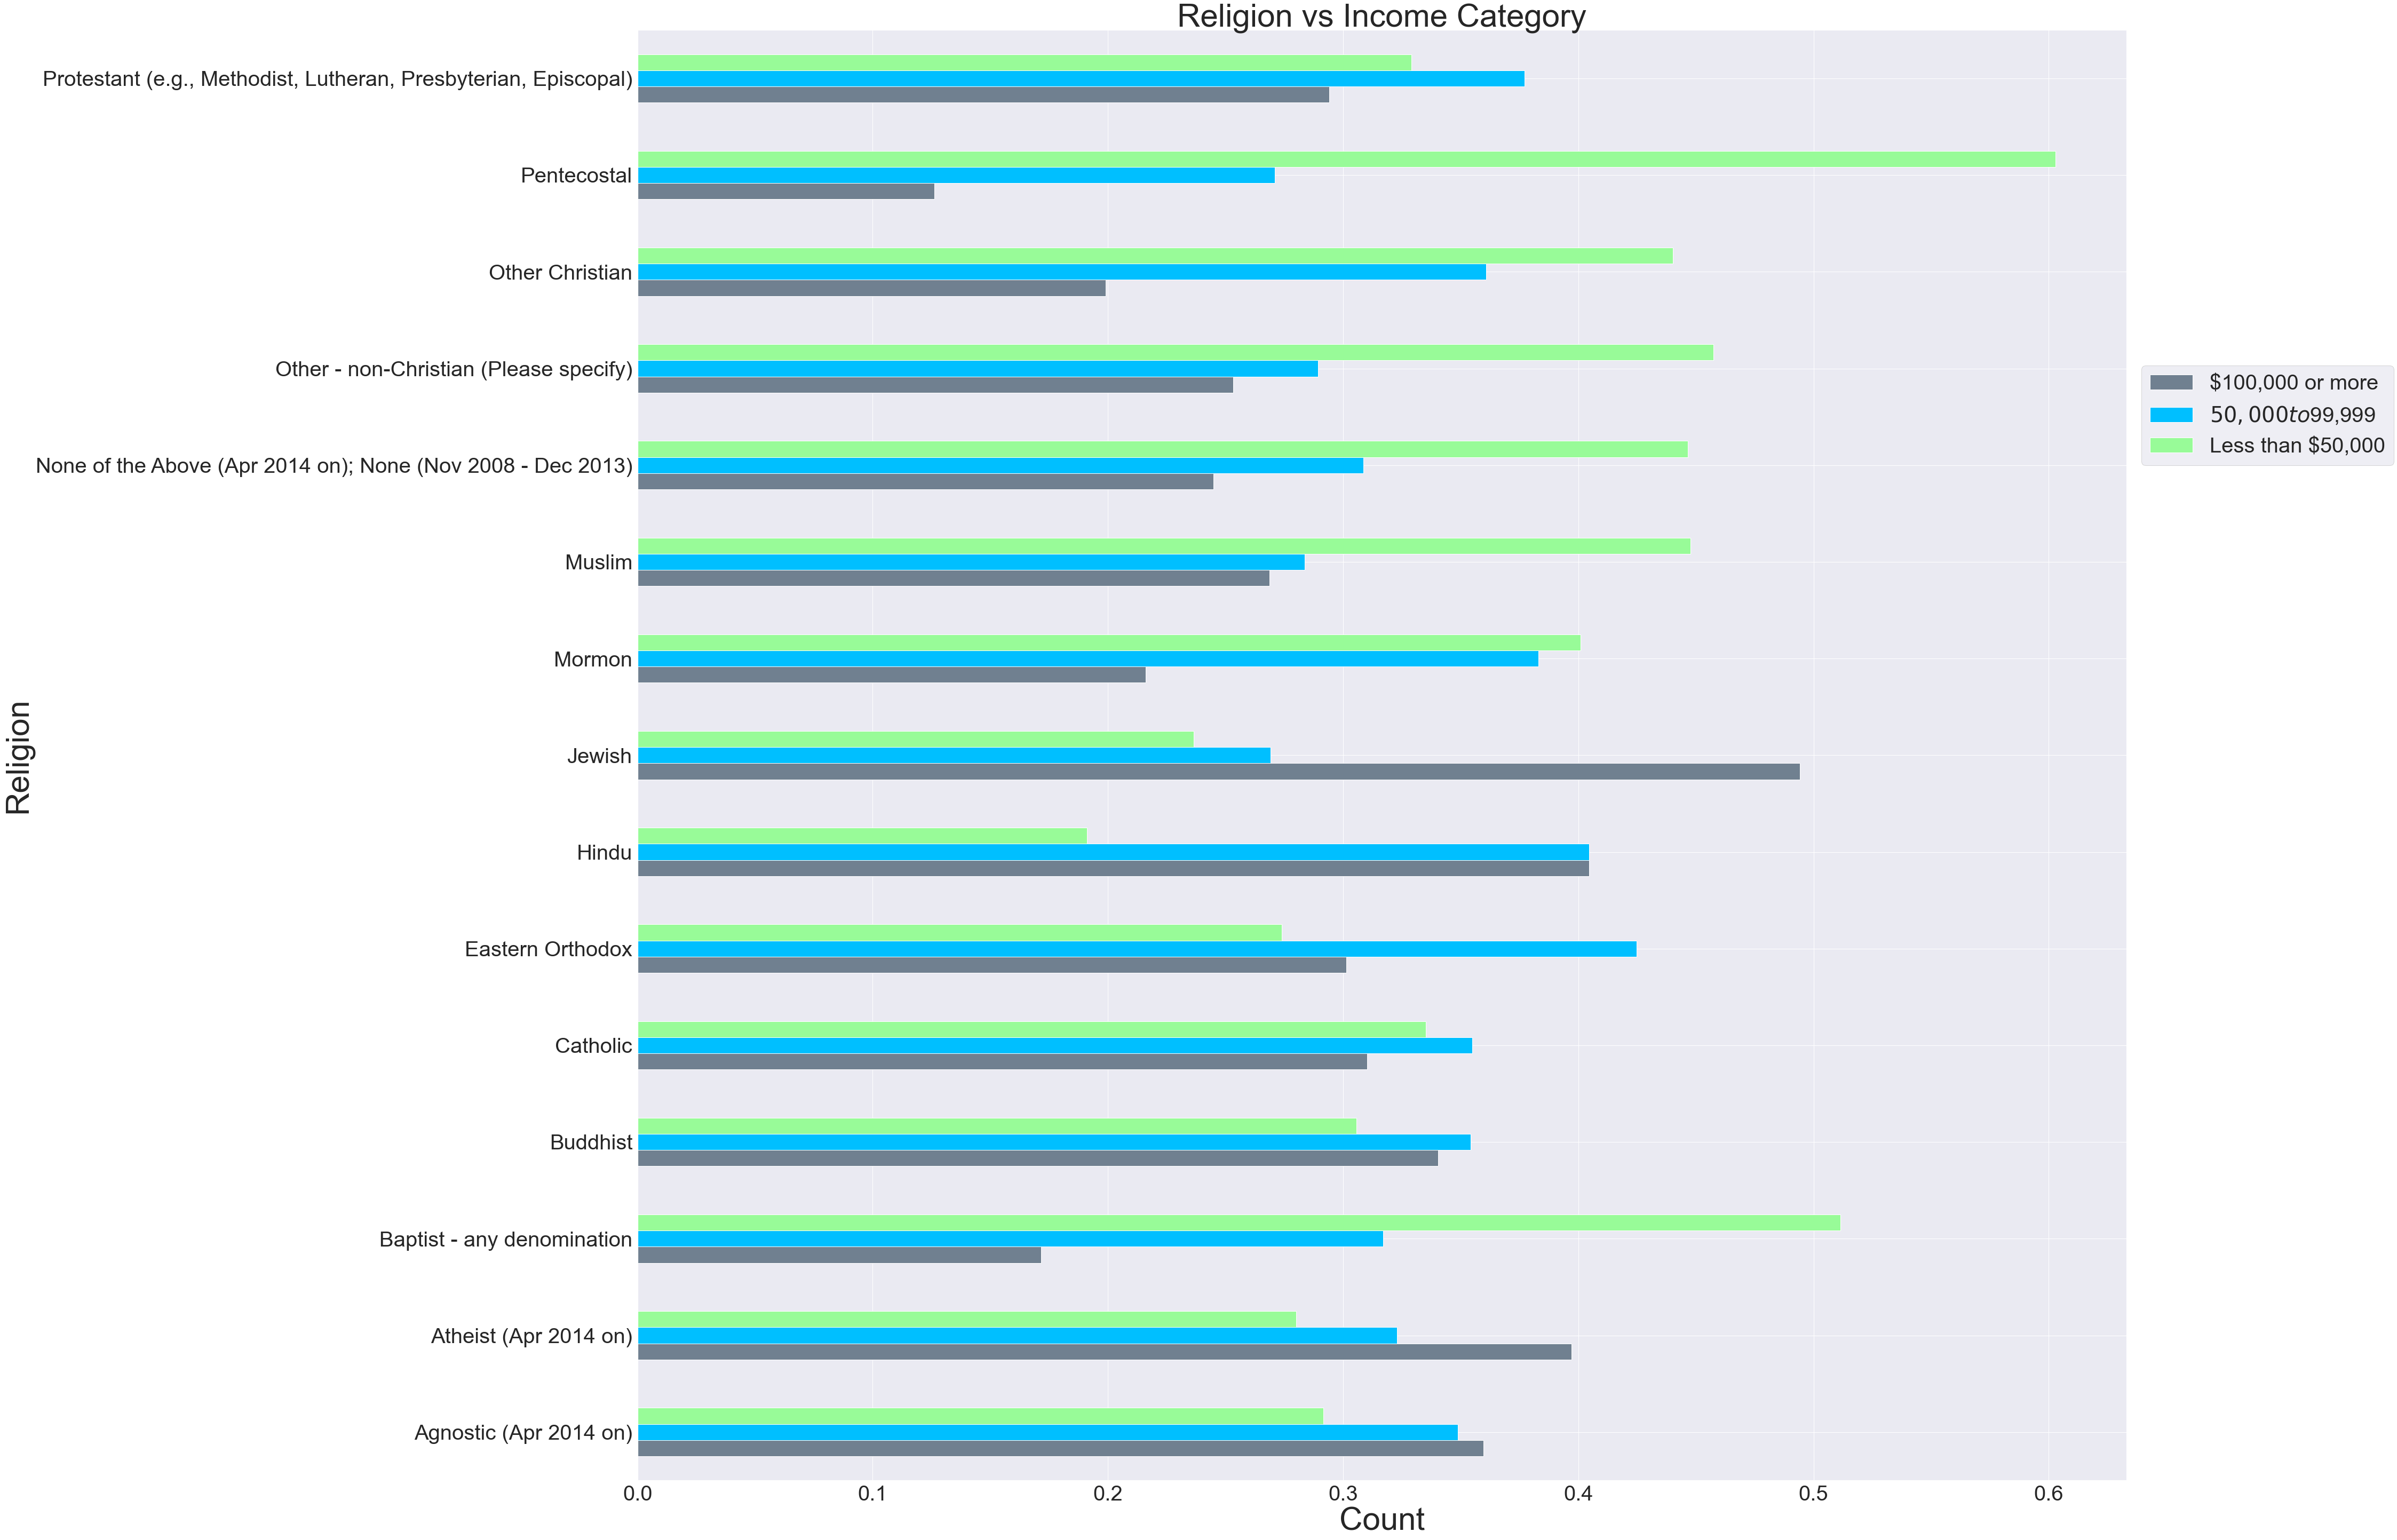

In [217]:
ax = df.groupby(['religion'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Religion',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Religion vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


- **High income category is prominent in Jewish, Atheist and Agnostic**
- **Middle income category is prominent in Protestant, Catholic, Eastern Orthodox**
- **Low Income category is predominant in all other religions**


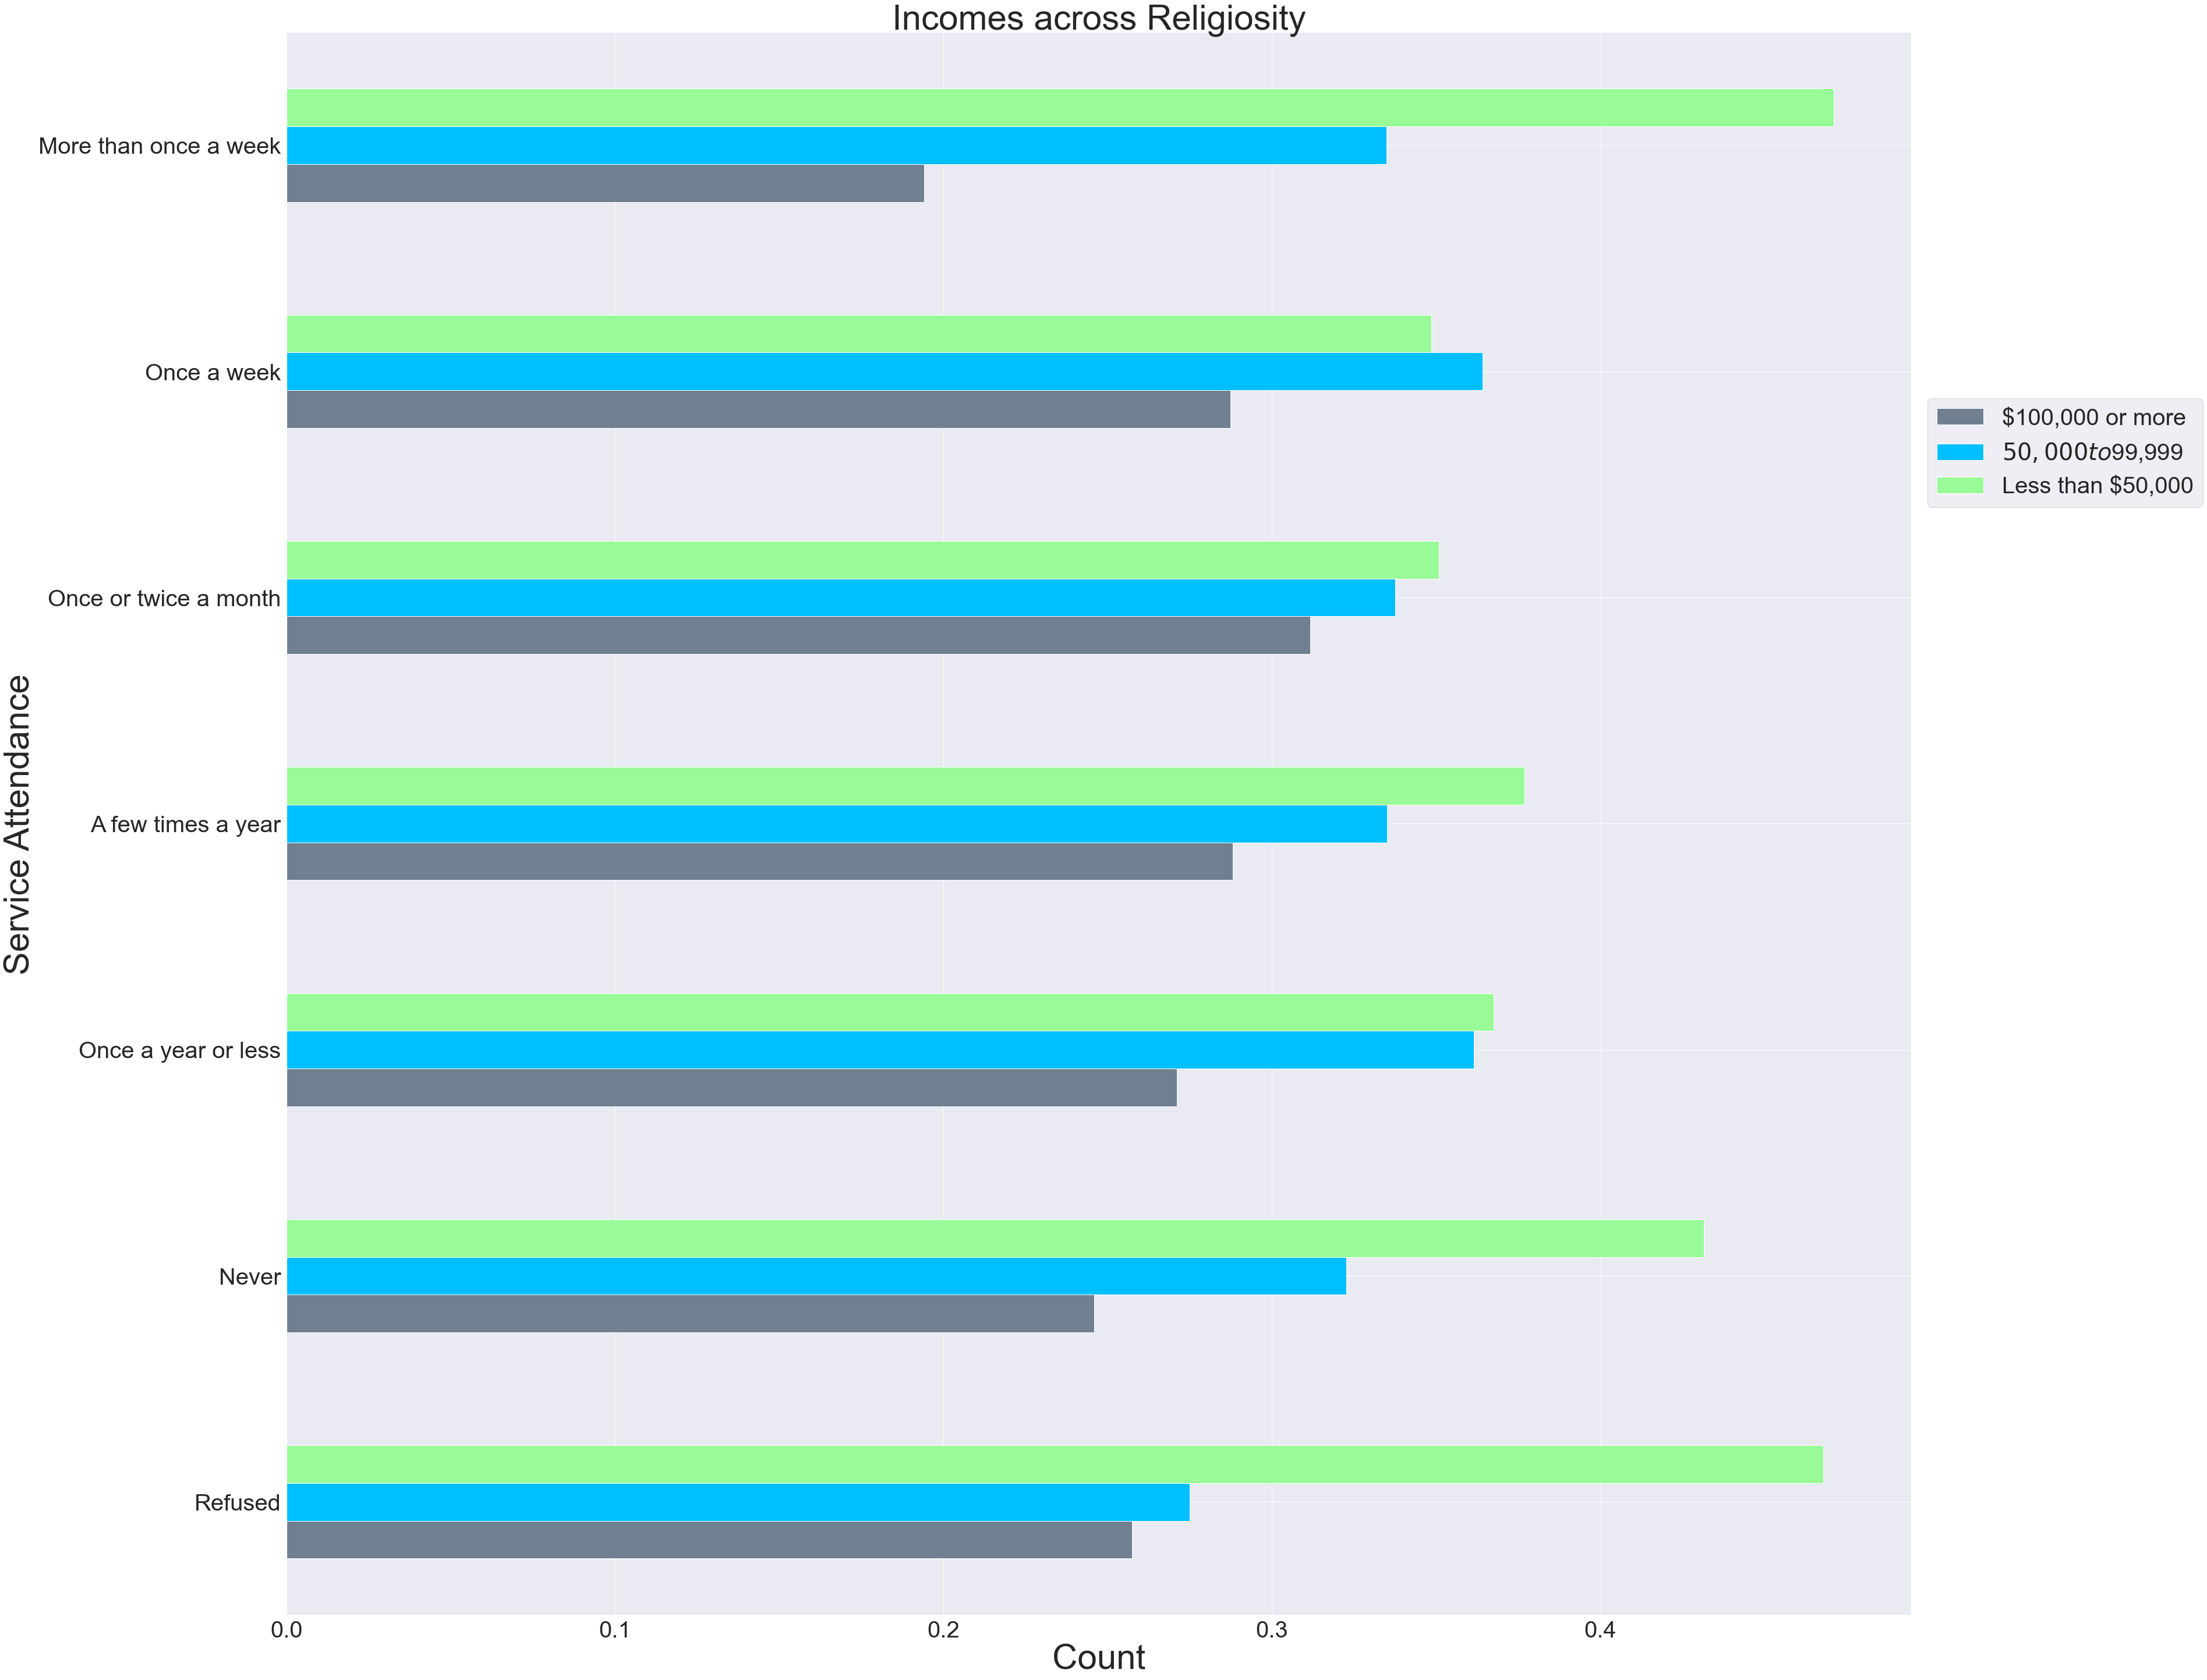

In [218]:
ax = df.groupby(['service_attendance'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
                color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Service Attendance',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Incomes across Religiosity',fontsize=60)
plt.setp(ax.get_xticklabels(), fontsize=40)
ax.set_yticklabels(['Refused','Never','Once a year or less','A few times a year','Once or twice a month','Once a week','More than once a week'],fontsize=40);
#-1. Refused
# 1. Never
# 2. Once a year or less
# 3. A few times a year
# 4. Once or twice a month
# 5. Once a week
# 6. More than once a week


- **To my surprise people who never go for service attendance(marked 1) have the most people in low income category**
- **Low income category is most represented across various groups**


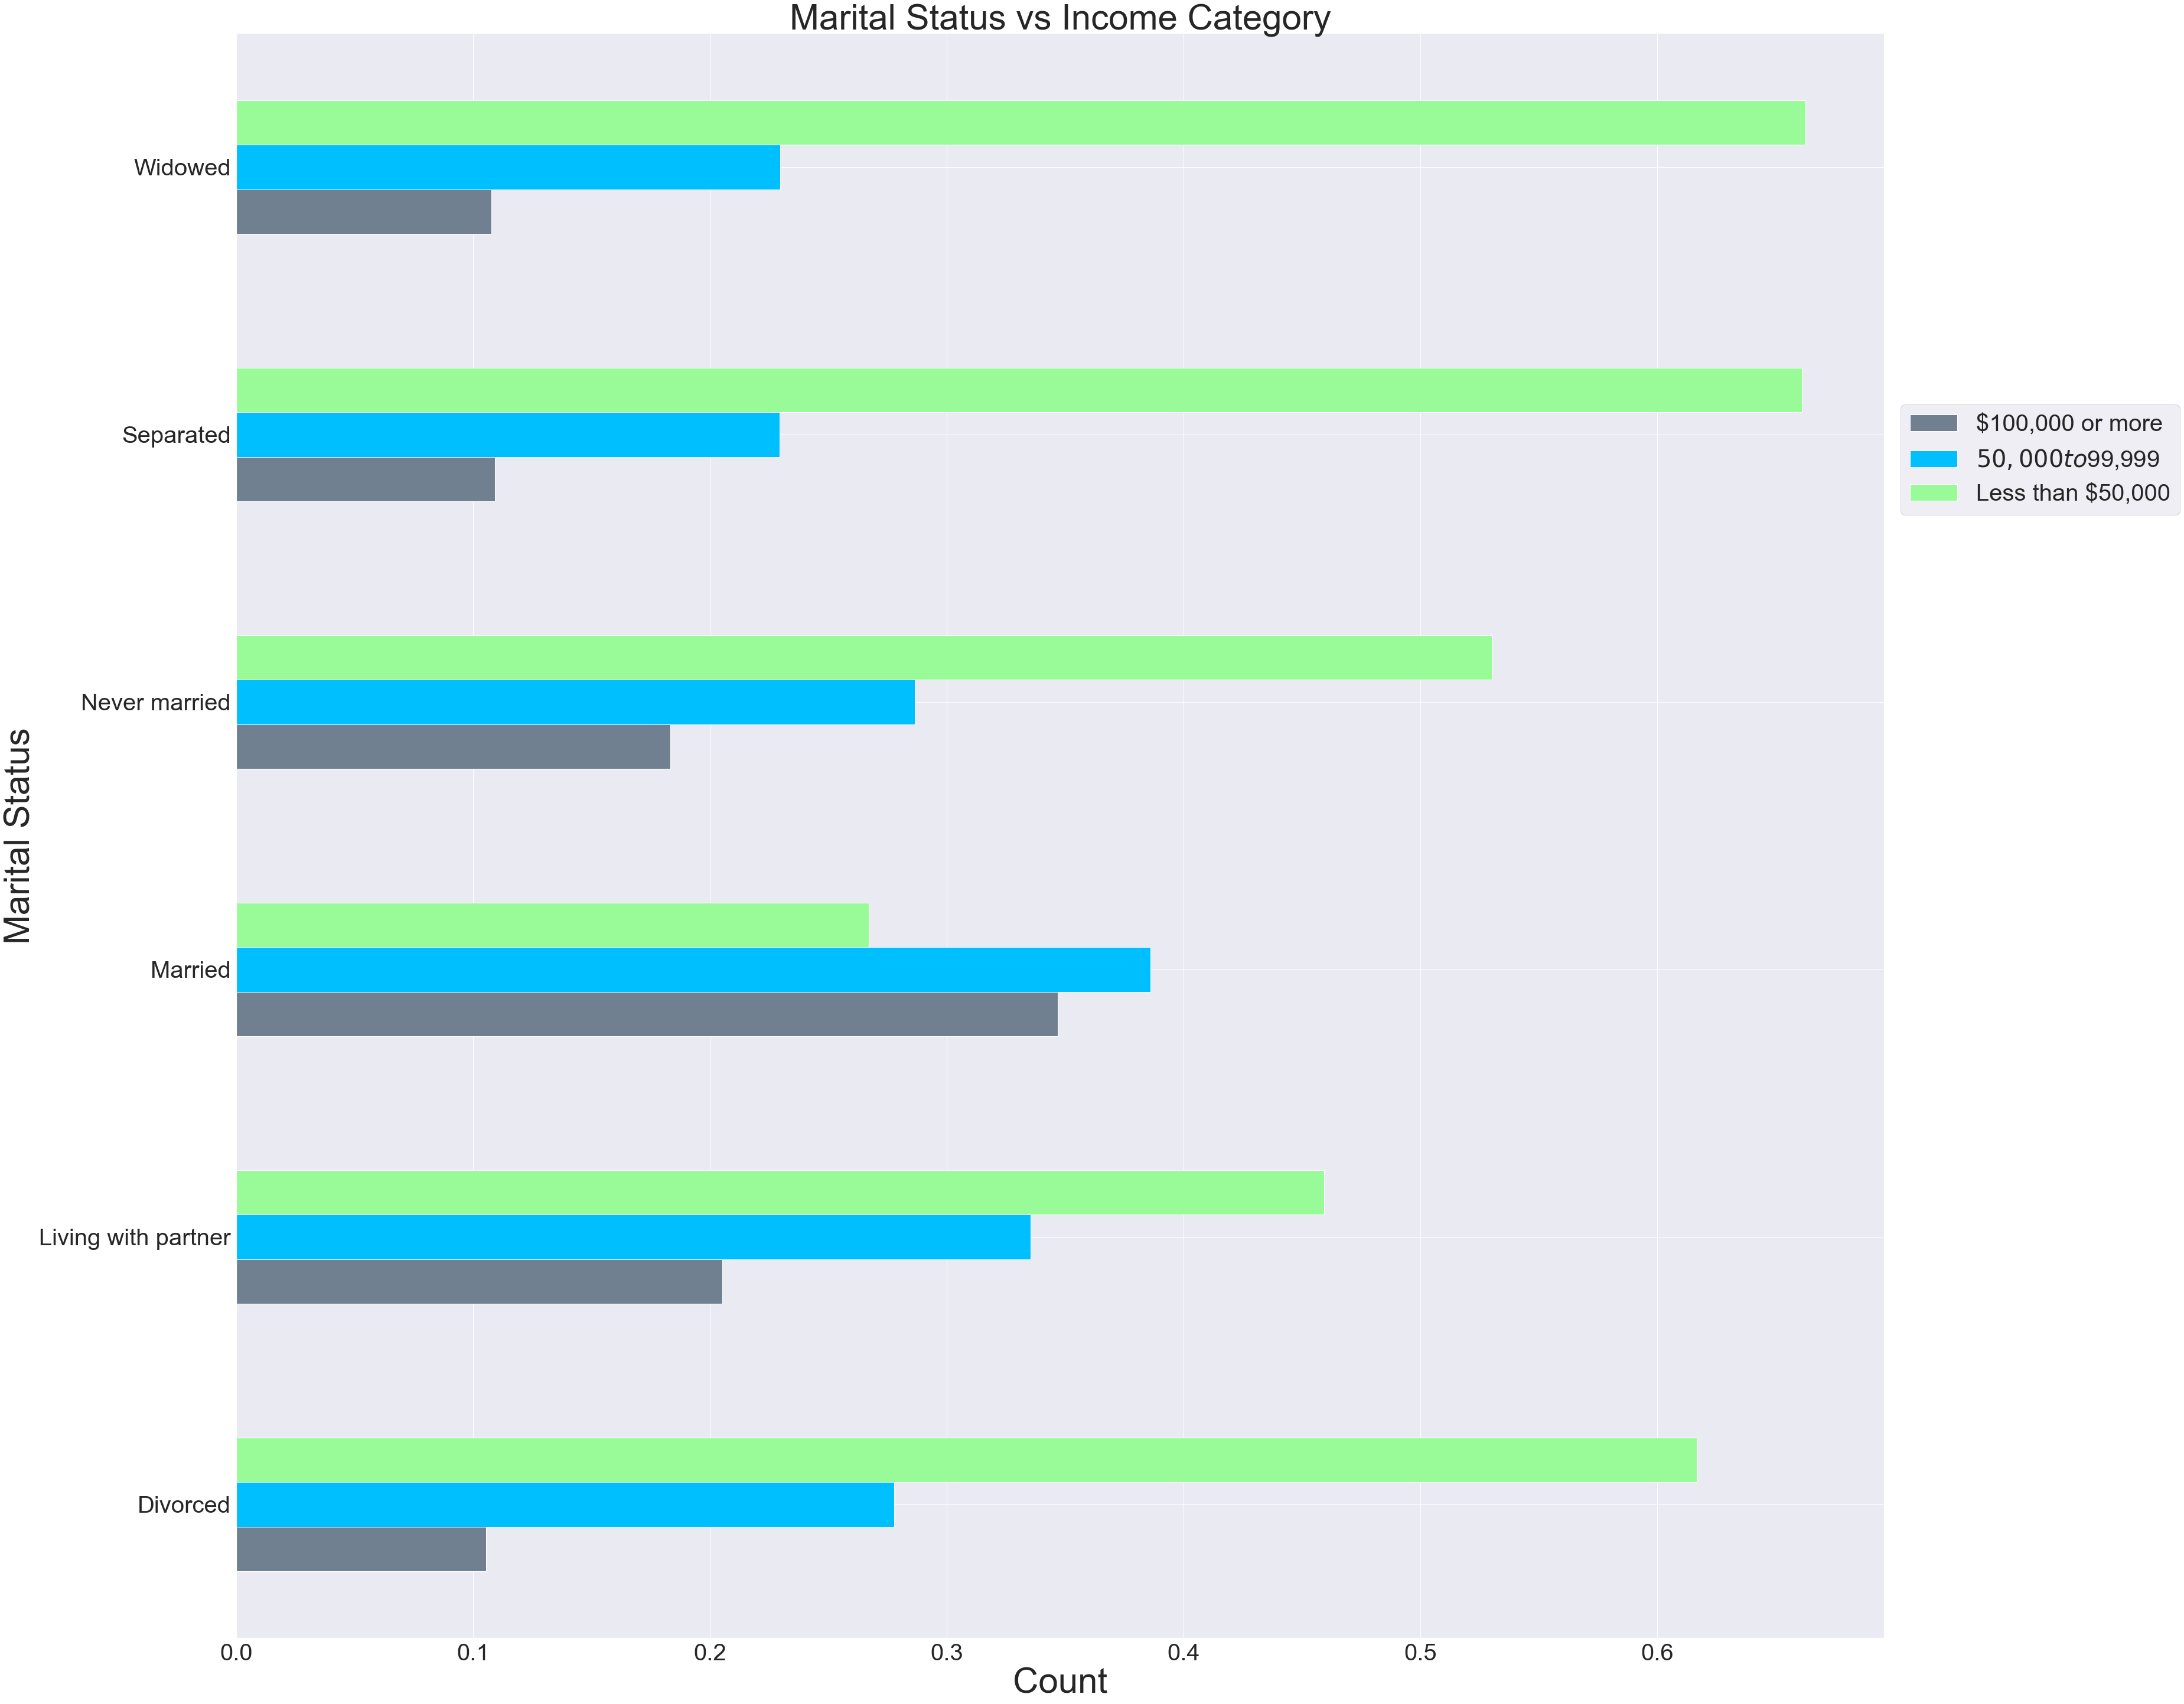

In [219]:
ax = df.groupby(['marit_status'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Marital Status',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Marital Status vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

- **Low Income category has most people lying in it except for the Married group where Middle Income is predominant**
- **Married people are likely to have more income than the rest**


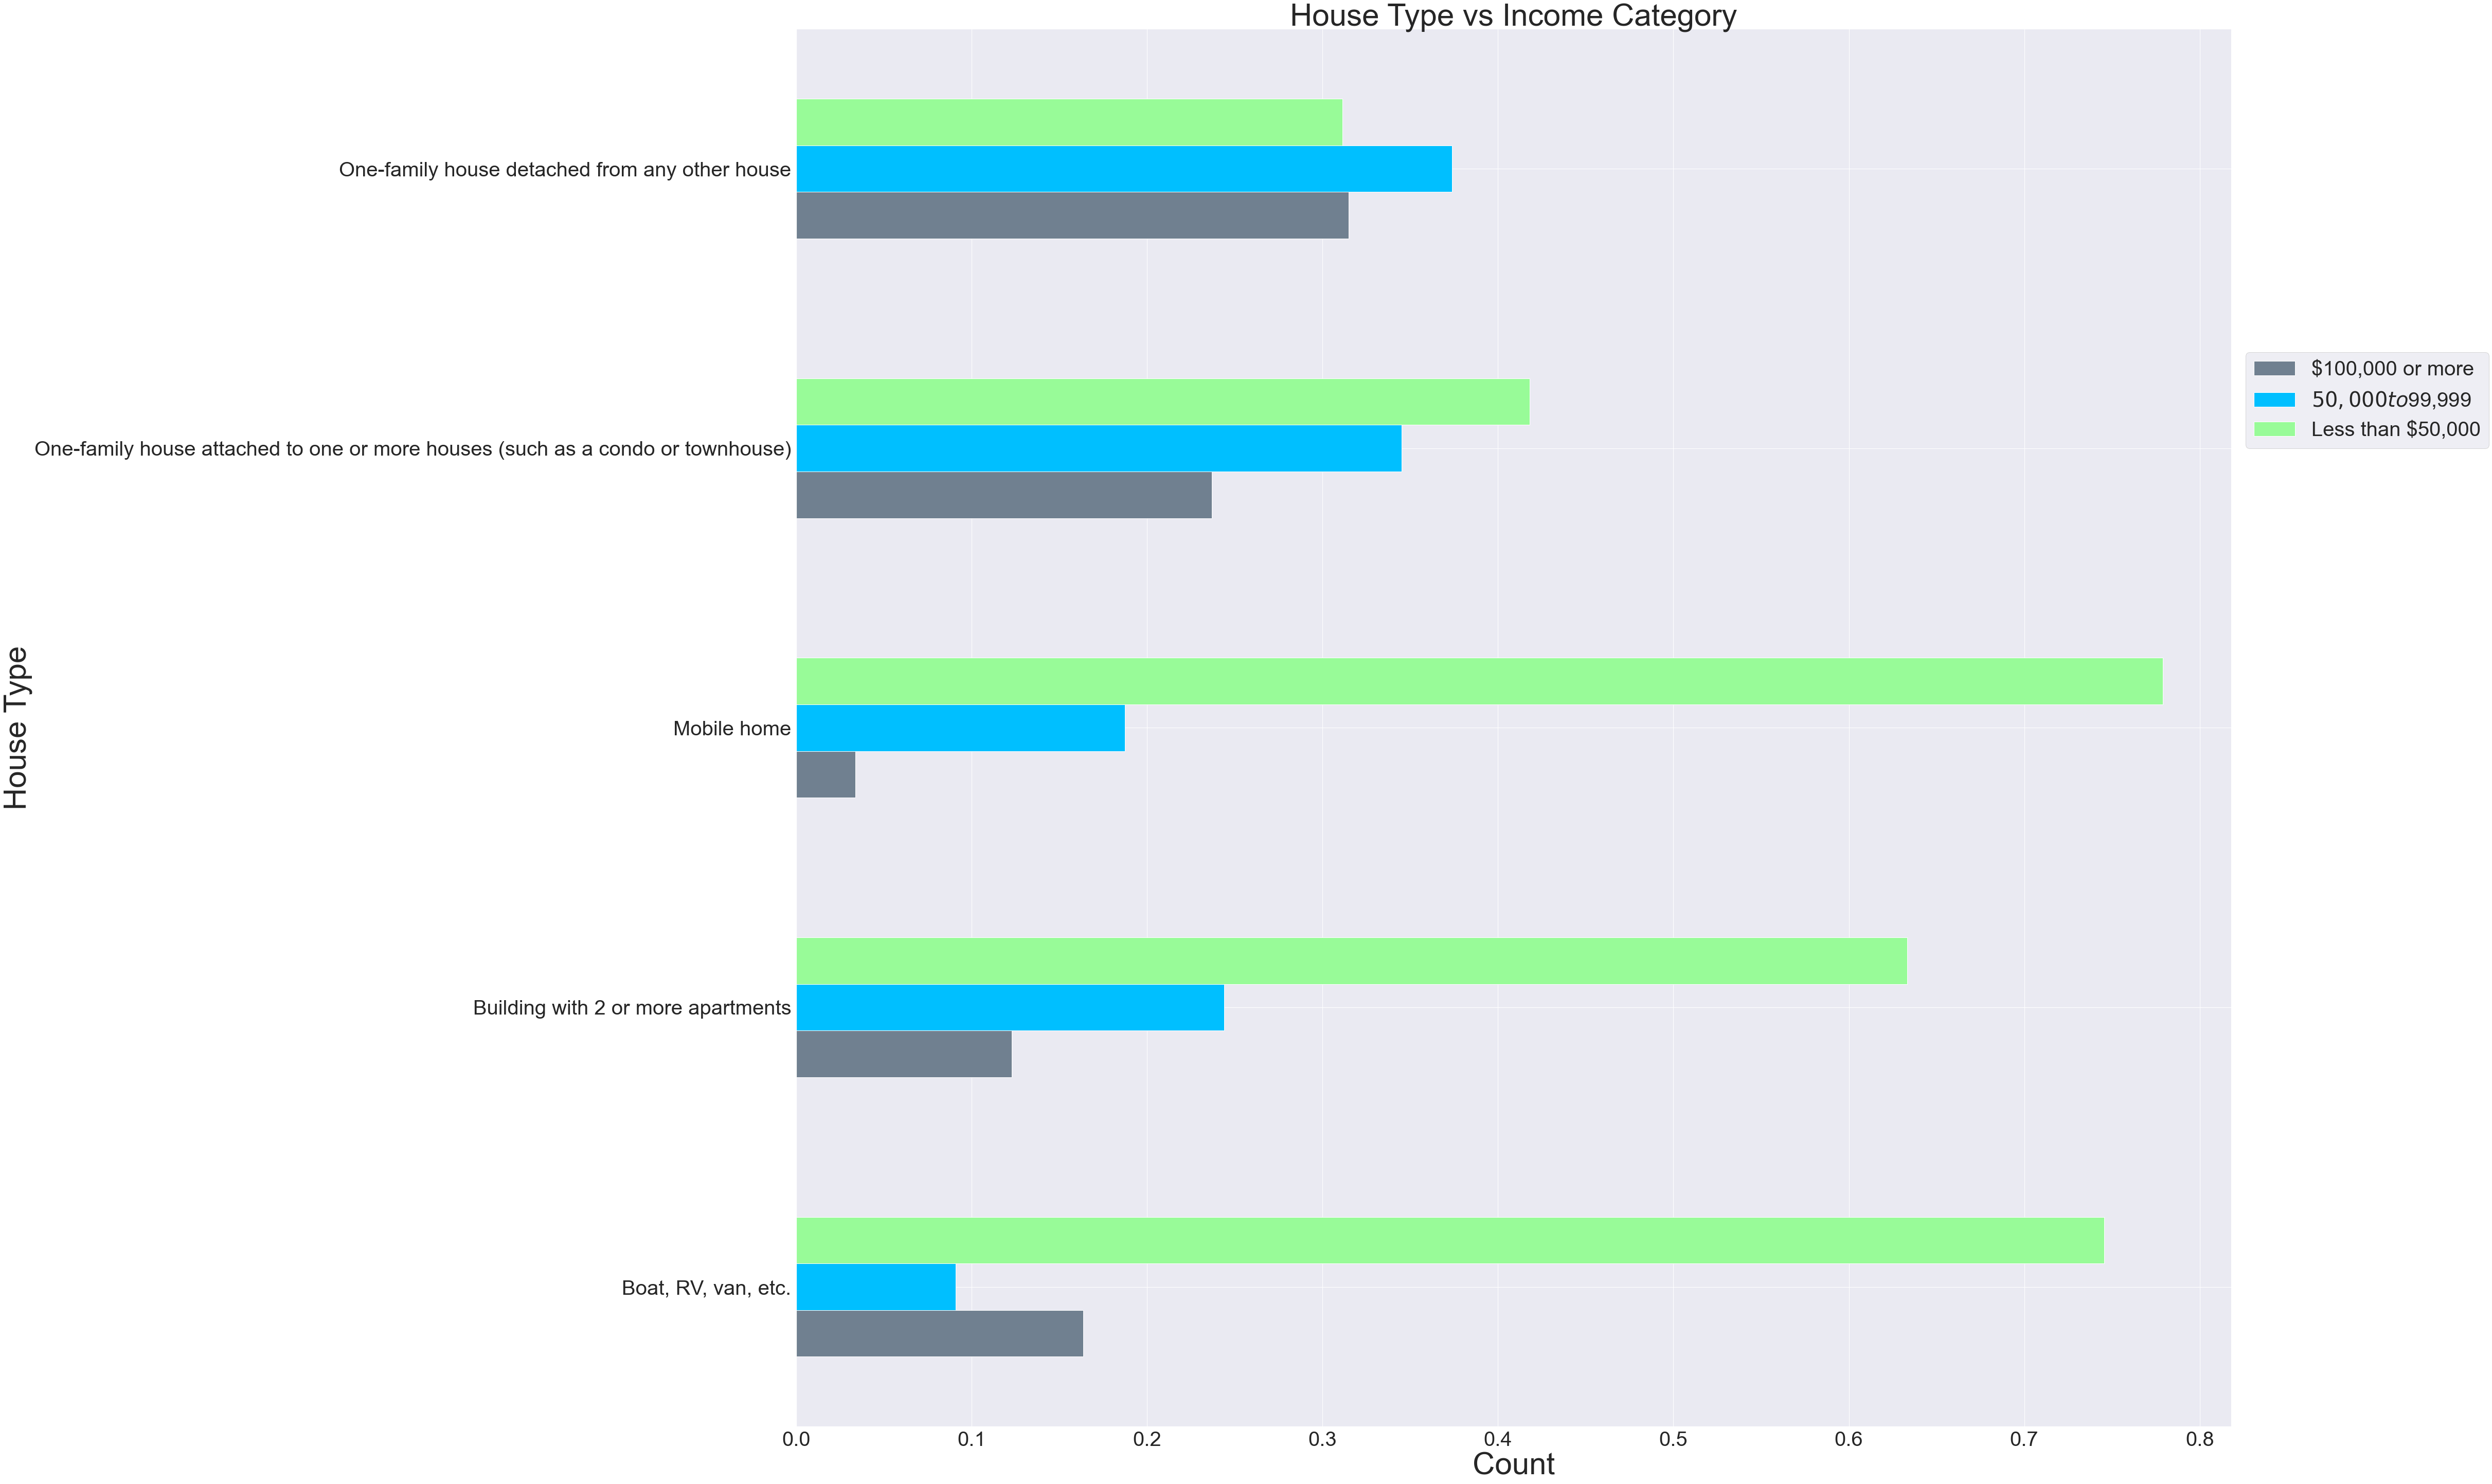

In [220]:
ax = df.groupby(['house_type'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Type',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Type vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

**- Middle income people are more likely to own a One-Family house**

In [221]:
my_columns=['religion','religion_other_nonchristian', 'evangelical', 'service_attendance',
       'marit_status', 'employment', 'house_head', 'house_size',
       'house_ages0to1', 'house_ages2to5', 'house_ages6to12',
       'house_ages13to17', 'house_ages18plus', 'house_type', 'house_own']

In [222]:
df[my_columns].dtypes

religion                        object
religion_other_nonchristian     object
evangelical                     object
service_attendance               int64
marit_status                    object
employment                      object
house_head                      object
house_size                     float64
house_ages0to1                 float64
house_ages2to5                 float64
house_ages6to12                float64
house_ages13to17               float64
house_ages18plus               float64
house_type                      object
house_own                       object
dtype: object

In [223]:
df['service_attendance']=df['service_attendance'].astype(np.int64)
df['house_size']=df['house_size'].astype(np.int64)
df['house_ages0to1']=df['house_ages0to1'].astype(np.int64)
df['house_ages2to5']=df['house_ages2to5'].astype(np.int64)
df['house_ages6to12']=df['house_ages6to12'].astype(np.int64)
df['house_ages13to17']=df['house_ages13to17'].astype(np.int64)
df['house_ages18plus']=df['house_ages18plus'].astype(np.int64)

In [224]:
df[my_columns].corr()

service_attendance  house_size  house_ages0to1  \
service_attendance            1.000000    0.075357        0.020434   
house_size                    0.075357    1.000000        0.247457   
house_ages0to1                0.020434    0.247457        1.000000   
house_ages2to5                0.030145    0.413976        0.193167   
house_ages6to12               0.064439    0.559622        0.062334   
house_ages13to17              0.063341    0.509097       -0.015429   
house_ages18plus              0.029062    0.733831        0.036673   

                    house_ages2to5  house_ages6to12  house_ages13to17  \
service_attendance        0.030145         0.064439          0.063341   
house_size                0.413976         0.559622          0.509097   
house_ages0to1            0.193167         0.062334         -0.015429   
house_ages2to5            1.000000         0.237052          0.018766   
house_ages6to12           0.237052         1.000000          0.212759   
house_ages13to17          0.018766         0.212759          1.000000   
house_ages18plus          0.057096         0.061203          0.136016   

                    house_ages18plus  
service_attendance          0.029062  
house_size                  0.733831  
house_ages0to1              0.036673  
house_ages2to5              0.057096  
house_ages6to12             0.061203  
house_ages13to17            0.136016  
house_ages18plus            1.000000

In [225]:
df[my_columns].describe()

service_attendance    house_size  house_ages0to1  house_ages2to5  \
count        22121.000000  22121.000000    22121.000000    22121.000000   
mean             3.108991      2.672167        0.042403        0.106370   
std              1.776227      1.473739        0.231379        0.369418   
min             -1.000000      1.000000        0.000000        0.000000   
25%              1.000000      2.000000        0.000000        0.000000   
50%              3.000000      2.000000        0.000000        0.000000   
75%              5.000000      4.000000        0.000000        0.000000   
max              6.000000     15.000000        7.000000        4.000000   

       house_ages6to12  house_ages13to17  house_ages18plus  
count     22121.000000      22121.000000      22121.000000  
mean          0.204512          0.188057          2.130826  
std           0.558462          0.498900          0.949859  
min           0.000000          0.000000          1.000000  
25%           0.000000          0.000000          2.000000  
50%           0.000000          0.000000          2.000000  
75%           0.000000          0.000000          2.000000  
max           6.000000          4.000000         12.000000

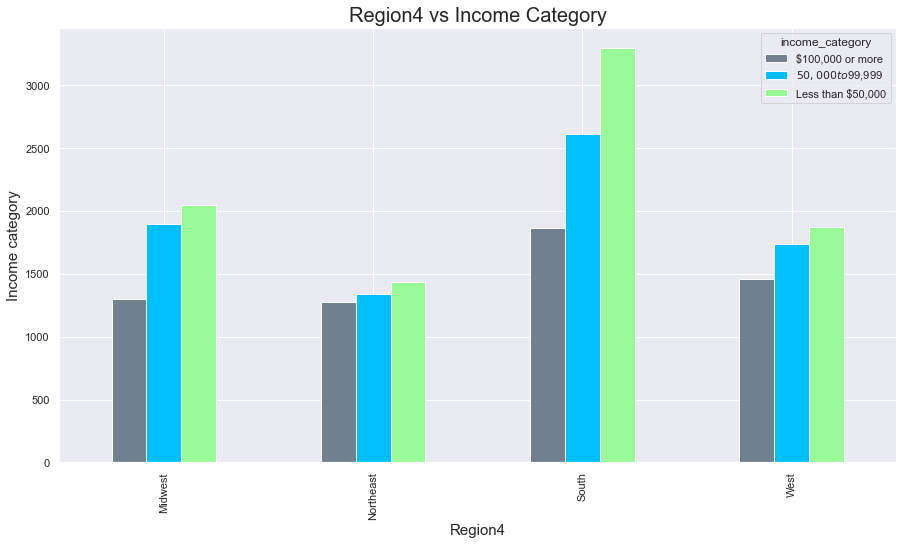

In [226]:
ax= pd.crosstab(index=df['region4'],columns=df['income_category']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_xlabel('Region4',fontsize=15)
ax.set_ylabel('Income category',fontsize=15)
ax.set_title('Region4 vs Income Category',fontsize=20);

- **Low income category is predominant**
- **High income is less represented across regions**

In [227]:
# ax= pd.crosstab(index=df['region9'],columns=df['income_category']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
# ax.set_xlabel('Region9',fontsize=15)
# ax.set_ylabel('Income category',fontsize=15)
# ax.set_title('Region9 vs Income Category',fontsize=20);

- **Low Income is predominant across regions except New England and West-North Central**
- **High income is predominant in New England**
- **Stark  inequality in East South Central region**
- **Pacific region has almost uniform distribution of low, medium and high income categories**

In [228]:
df[['house_size','house_ages18plus']].corr()

house_size  house_ages18plus
house_size          1.000000          0.733831
house_ages18plus    0.733831          1.000000

- **Very high correlation between house_size and house_ages18plus might drop one of them**
- **Keep `children` as defined below and either of `house_size` or `house_ages18plus`and leave out `house_ages0to1`, `house_ages2to5`, `house_ages6to12`, `house_ages13to17`**

In [229]:
df[['house_ages0to1', 'house_ages2to5', 'house_ages6to12',
       'house_ages13to17', 'house_ages18plus','house_size']]

house_ages0to1  house_ages2to5  house_ages6to12  house_ages13to17  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   
...               ...             ...              ...               ...   
22116               0               0                0                 0   
22117               0               1                3                 0   
22118               0               0                0                 0   
22119               0               1                0                 0   
22120               1               0                0                 0   

       house_ages18plus  house_size  
0                     3           3  
1                     2           2  
2                     2           2  
3                     2           2  
4                     2           2  
...                 ...         ...  
22116                 2           2  
22117                 4           8  
22118                 2           2  
22119                 4           5  
22120                 2           3  

[22121 rows x 6 columns]

In [230]:
df['children'] =df['house_ages0to1']+df['house_ages2to5']+df['house_ages6to12']+df['house_ages13to17']

In [231]:
df['children'].describe()

count    22121.000000
mean         0.541341
std          1.009772
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: children, dtype: float64

- **All good with `children` column**

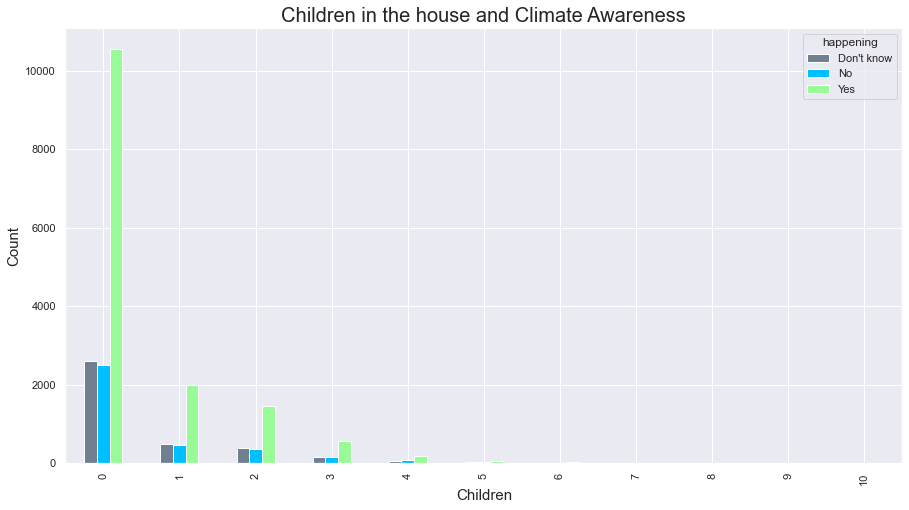

In [232]:
ax= pd.crosstab(index=df['children'],columns=df['happening']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_xlabel('Children', fontsize=15)
ax.set_ylabel('Count',fontsize=15)
ax.set_title('Children in the house and Climate Awareness', fontsize=20);

- **Seems like having more children reduces the climate awareness or that people with more climate awareness are having less children**
- **I was expecting a reverse relationship too that people having children would want to leave a better world for their children so would be more aware, I don't know the exact relationship**

In [233]:
columns_to_keep=['religion', 'service_attendance','marit_status', 'employment', 'house_head',
                 'house_size',  'house_ages18plus','children', 'house_type', 'house_own']

**These are the columns I would like to keep after EDA*

In [246]:
df.to_csv('../data/survey_data_before_pre_processing.csv', index=False)